# Team Based Model

## Imports

In [236]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


from tqdm import tqdm
from nba_api.stats.static import players, teams

import sys

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from src.data.make_team_dataset import load_team_data


from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV, LogisticRegression, ElasticNet
from sklearn.linear_model import Ridge, Lasso, SGDRegressor
from sklearn.pipeline import make_pipeline

import lightgbm as lgb

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import LinearSVR, SVC
import xgboost as xgb
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import confusion_matrix
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [237]:
pd.options.display.max_columns=230
pd.options.display.max_rows=100

## Gather Team Level Basic, Advanced, and Scoring Data

In [238]:
team_data = load_team_data()

In [239]:
from src.data.make_team_dataset import clean_team_data

clean_team_df = clean_team_data(team_data)



In [240]:
clean_team_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,E_TM_TOV_PCT,TM_TOV_PCT,EFG_PCT,TS_PCT,USG_PCT,E_USG_PCT,E_PACE,PACE,PACE_PER40,POSS,PIE,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,HOME_GAME
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,0,240,34,74,0.459,2,9,0.222,28,40,0.700,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,0.529,1.00,14.1,0.289,0.667,0.478,18.256,18.9,0.473,0.535,1.0,0.197,98.32,95.5,79.58,95.0,0.446,0.878,0.122,0.653,0.163,0.061,0.102,0.286,0.204,0.490,0.563,0.438,0.000,1.000,0.529,0.471,1
1,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,1,240,43,88,0.489,6,11,0.545,14,16,0.875,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,0.674,1.81,20.7,0.333,0.711,0.522,16.320,16.7,0.523,0.558,1.0,0.195,98.32,95.5,79.58,96.0,0.554,0.875,0.125,0.698,0.396,0.170,0.085,0.132,0.208,0.302,0.622,0.378,1.000,0.000,0.674,0.326,0
2,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,0,240,31,85,0.365,3,10,0.300,17,26,0.654,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,0.774,1.60,17.7,0.276,0.698,0.477,15.084,15.3,0.382,0.425,1.0,0.196,99.76,98.0,81.67,98.0,0.488,0.882,0.118,0.683,0.171,0.110,0.110,0.207,0.256,0.512,0.750,0.250,1.000,0.000,0.774,0.226,1
3,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,1,240,32,78,0.410,2,7,0.286,20,32,0.625,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,0.500,0.84,12.6,0.302,0.724,0.523,18.985,19.4,0.423,0.467,1.0,0.202,99.76,98.0,81.67,98.0,0.512,0.910,0.090,0.698,0.279,0.070,0.163,0.233,0.140,0.419,0.467,0.533,1.000,0.000,0.500,0.500,0
4,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,240,36,80,0.450,4,17,0.235,9,13,0.692,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,0.528,1.12,15.6,0.239,NaN,NaN,18.139,18.1,0.475,0.496,1.0,0.199,93.06,94.0,78.33,94.0,0.359,0.788,0.213,0.753,0.447,0.141,0.106,0.106,0.259,0.306,0.469,0.531,1.000,0.000,0.528,0.472,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51343,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,1,240,35,79,0.443,14,39,0.359,18,21,0.857,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,0.714,1.67,19.5,0.289,0.783,0.538,16.088,16.3,0.532,0.578,1.0,0.200,93.84,92.0,76.67,92.0,0.559,0.506,0.494,0.412,0.078,0.412,0.069,0.176,0.186,0.333,0.619,0.381,0.857,0.143,0.714,0.286,0
51344,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,1,240,38,83,0.458,14,33,0.424,21,22,0.955,9,26,35,26,7,3,13,19,111,3,114.8,119.4,114.6,114.9,0.2,4.5,0.684,2.00,19.7,0.267,0.667,0.467,13.446,14.0,0.542,0.599,1.0,0.199,95.46,93.5,77.92,93.0,0.512,0.602,0.398,0.432,0.144,0.378,0.036,0.189,0.180,0.288,0.542,0.458,0.929,0.071,0.684,0.316,0
51345,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900405,2020-10-09,LAL vs. MIA,0,240,38,82,0.463,14,38,0.368,18,21,0.857,12,29,41,21,10,5,15,21,108,-3,114.6,114.9,114.8,119.4,-0.2,-4.5,0.553,1.40,16.5,0.333,0.733,0.533,15.917,16.0,0.549,0.592,1.0,0.200,95.46,93.5,77.92,94.0,0.488,0.537,0.463,0.444,0.056,0.389,0.231,0.167,0.130,0.389,0.458,0.542,0.714,0.286,0.553,0.447,1
51346,2019-20,42019,1610612748,MIA,Miami Heat,41900406,2020-10-11,MIA vs. LAL,0,240,35,79,0.443,10,28,0.357,13,22,0.591,9,32,41,25,4,4,15,18,93,-13,98.2,100.0,109.1,112.8,-

In [241]:
from src.data.make_team_dataset import prep_for_aggregation
ready_for_agg_df = prep_for_aggregation(clean_team_df)
ready_for_agg_df

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,TEAM_SCORE,point_diff,WL,MIN,RECORD,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,E_OFF_RATING,OFF_RATING,E_DEF_RATING,DEF_RATING,E_NET_RATING,NET_RATING,POSS,PIE,PTS_2PT_MR,PTS_FB,PTS_OFF_TOV,PTS_PAINT,AST_2PM,UAST_2PM,AST_3PM,UAST_3PM
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2
1,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0
2,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0
3,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0
4,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,85,-13,0,240,0,32,63,4,17,9,13,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.0,0.359,37,9,22,26,15,16,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51343,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,0,102,6,1,240,1,21,40,14,39,18,21,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,92.0,0.559,7,7,18,33,12,8,11,2
51344,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,0,111,3,1,240,1,24,50,14,33,21,22,9,26,35,26,7,3,13,19,111,3,114.8,119.4,114.6,114.9,0.2,4.5,93.0,0.512,15,3,19,31,13,10,13,0
51345,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900405,2020-10-09,LAL vs. MIA,1,108,-3,0,240,0,24,44,14,38,18,21,12,29,41,21,10,5,15,21,108,-3,114.6,114.9,114.8,119.4,-0.2,-4.5,94.0,0.488,6,24,14,42,10,13,9,4
51346,2019-20,42019,1610612748,MIA,Miami Heat,41900406,2020-10-11,MIA vs. LAL,1,93,-13,0,240,0,25,51,10,28,13,22,9,32,41,25,4,4,15,18,93,-13,98.2,100.0,109.1,112.8,-10.9,-12.8,93.0,0.456,6,7,14,43,18,7,7,3


In [242]:
from src.data.make_team_dataset import create_matchups

matchups = create_matchups(ready_for_agg_df)
matchups

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,SEASON_YEAR_opp,SEASON_ID_opp,TEAM_ID_opp,TEAM_ABBREVIATION_opp,TEAM_NAME_opp,GAME_DATE_opp,MATCHUP_opp,HOME_GAME_opp,TEAM_SCORE_opp,point_diff_opp,WL_opp,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp
1,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0
2,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0,2000-01,22000,1610612745,HOU,Houston Rockets,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2
5,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0
6,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0,2000-01,22000,1610612751,BKN,New Jersey Nets,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0
9,2000-01,22000,1610612754,IND,Indiana Pacers,20000009,2000-10-31,IND @ SAS,0,85,-13,0,240,0,32,63,4,17,9,13,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.0,0.359,37,9,22,26,15,16,4,0,2000-01,22000,1610612759,SAS,San Antonio Spurs,2000-10-31,SAS vs. IND,1,98,13,1,240,1,29,56,4,8,28,35,5,32,37,17,6,4,18,22,98,13,106.1,104.3,90.7,90.4,15.4,13.8,94.0,0.641,42,5,14,15,12,16,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102678,2019-20,42019,1610612747,LAL,Los Angeles Lakers,41900404,2020-10-06,LAL @ MIA,0,102,6,1,240,1,21,40,14,39,18,21,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,92.0,0.559,7,7,18,33,12,8,11,2,2019-20,42019,1610612748,MIA,Miami Heat,2020-10-06,MIA vs. LAL,1,96,-6,0,240,0,21,43,11,32,21,26,7,32,39,18,8,3,15,21,96,-6,101.7,104.3,109.4,110.9,-7.7,-6.5,92.0,0.441,9,4,12,31,6,14,11,0
102681,2019-20,42019,1610612748,MIA,Miami Heat,41900405,2020-10-09,MIA @ LAL,0,111,3,1,240,1,24,50,14,33,21,22,9,26,35,26,7,3,13,19,111

In [243]:
test = matchups.loc[(matchups['SEASON_YEAR_team'] == '2000-01') & (matchups['TEAM_ABBREVIATION_team'] == 'HOU')].sort_values('GAME_DATE_team')
test['FG3M_2_avg'] = test['FG3M_team'].expanding().mean()
test['FG3M_2_SMA_2'] = test['FG3M_team'].rolling(window=2).mean()
test['FG3M_2'] = test['FG3M_team'].ewm(span=2, adjust=True).mean()
test['FG3M_3'] = test['FG3M_team'].ewm(span=1.5, adjust=True).mean()
test['FG3M_19'] = test['FG3M_team'].ewm(span=19, adjust=True).mean()
test['FG3M_10'] = test['FG3M_team'].ewm(span=10, adjust=True).mean()

test[['FG3M_team', 'FG3M_2_avg', 'FG3M_2_SMA_2', 'FG3M_2', 'FG3M_3', 'FG3M_10', 'FG3M_19']].head(10)
# test['FG3M_team']

,FG3M_team,FG3M_2_avg,FG3M_2_SMA_2,FG3M_2,FG3M_3,FG3M_10,FG3M_19
1,2,2.000000,NaN,2.000000,2.000000,2.000000,2.000000
85,12,7.000000,7.0,9.500000,10.333333,7.500000,7.263158
182,5,6.333333,8.5,6.384615,6.032258,6.495017,6.428044
193,6,6.250000,5.5,6.125000,6.006410,6.331931,6.303577
217,4,5.800000,5.0,4.702479,4.400768,5.662497,5.741056
290,5,5.666667,4.5,4.901099,4.880184,5.490424,5.582900
365,2,5.142857,3.5,2.966148,2.576007,4.649372,4.896130
386,4,5.000000,3.0,3.655488,3.715204,4.501636,4.738785
409,8,5.333333,6.0,6.551976,7.143043,5.262758,5.271159
473,2,5.000000,5.0,3.517274,3.028608,4.577396,4.768925


## Add Betting Data 

In [244]:
from src.data.make_betting_dataset import clean_spread_data

spread_df = pd.read_csv('../data/all_spreads_sbr.csv', parse_dates=['game_date'])
clean_spread = clean_spread_data(spread_df)
clean_spread
clean_spread[['away_team', 'home_team', 'game_date', 'home_spread_mode', 'away_spread_mode']]

,away_team,home_team,game_date,home_spread_mode,away_spread_mode
0,CHI,MIA,2006-10-31,-4.5,4.5
1,PHX,LAL,2006-10-31,8.0,-8.5
2,TOR,BKN,2006-11-01,-7.5,7.0
3,NYK,MEM,2006-11-01,-5.0,5.0
4,ATL,PHI,2006-11-01,-6.0,5.5
...,...,...,...,...,...
18423,MIN,MEM,2021-04-02,-7.0,7.0
18424,ATL,NOP,2021-04-02,1.5,-1.5
18425,CHI,UTA,2021-04-02,-11.0,11.0
18426,OKC,PHX,2021-04-02,-14.0,14.0


In [245]:
from src.data.make_betting_dataset import clean_moneyline_data

ml_df = pd.read_csv('../data/all_moneylines_sbr.csv', parse_dates=['game_date'])
clean_moneylines = clean_moneyline_data(ml_df)



In [246]:
for col in clean_moneylines.columns[3:11]:
    clean_moneylines[col] = clean_moneylines[col].astype(str).apply(lambda x: convert_to_float(x))
    clean_moneylines[col] = clean_moneylines[col].astype(float)
    
clean_moneylines['away_ml_mode'] = clean_moneylines.iloc[:, 3:7].mode(axis=1)[0]
clean_moneylines['home_ml_mode'] = clean_moneylines.iloc[:, 7:11].mode(axis=1)[0]

clean_moneylines

,away_team,home_team,game_date,away_ml1,away_ml2,away_ml3,away_ml4,home_ml1,home_ml2,home_ml3,home_ml4,away_ml_mode,home_ml_mode
0,CHI,MIA,2006-10-31,180.0,NaN,180.0,NaN,-220.0,NaN,-210.0,NaN,180.0,-220.0
1,PHX,LAL,2006-10-31,-380.0,NaN,-350.0,NaN,290.0,NaN,290.0,NaN,-380.0,290.0
2,LAC,PHX,2006-11-01,165.0,NaN,155.0,NaN,-190.0,NaN,-175.0,NaN,155.0,-190.0
3,LAL,GSW,2006-11-01,245.0,NaN,250.0,NaN,-290.0,NaN,-300.0,NaN,245.0,-300.0
4,NYK,MEM,2006-11-01,NaN,NaN,185.0,NaN,NaN,NaN,-215.0,NaN,185.0,-215.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18437,MIN,MEM,2021-04-02,230.0,205.0,234.0,215.0,-280.0,-245.0,-285.0,-265.0,205.0,-285.0
18438,ATL,NOP,2021-04-02,-125.0,-102.0,-117.0,-115.0,105.0,-118.0,-102.0,-105.0,-125.0,-118.0
18439,CHI,UTA,2021-04-02,475.0,660.0,506.0,505.0,-750.0,-1000.0,-700.0,-655.0,475.0,-1000.0
18440,OKC,PHX,2021-04-02,725.0,700.0,797.0,780.0,-1300.0,-1100.0,-1300.0,-1080.0,700.0,-1300.0


In [247]:
def add_moneyline_data(df=matchups):
    df = df.copy()
    df['home_team'] = df['MATCHUP_team'].apply(lambda x: x[:3] if 'vs' in x else x[-3:])
    df['away_team'] = df['MATCHUP_team'].apply(lambda x: x[:3] if '@' in x else x[-3:])
    df[['home_team', 'away_team', 'MATCHUP_team']]
    
    df = pd.merge(df, clean_moneylines[['away_team', 'home_team', 'game_date', 'away_ml_mode', 'home_ml_mode']], how='left', 
         left_on=['home_team', 'away_team', 'GAME_DATE_team'], right_on=['home_team', 'away_team', 'game_date'])    

    
    return df


matchups = add_moneyline_data(matchups)


In [248]:
def convert_american_to_decimal(x):
    if x > 0:
        return 1 + x/100
    if x < 0:
        return 1 - (100/x)
    
convert_american_to_decimal(200)


3.0

In [249]:
matchups['away_ml_mode'] = matchups['away_ml_mode'].apply(convert_american_to_decimal)
matchups['home_ml_mode'] = matchups['home_ml_mode'].apply(convert_american_to_decimal)


In [250]:
def add_spread_data(df=matchups):
    df = df.copy()
    df['home_team'] = df['MATCHUP_team'].apply(lambda x: x[:3] if 'vs' in x else x[-3:])
    df['away_team'] = df['MATCHUP_team'].apply(lambda x: x[:3] if '@' in x else x[-3:])
    df[['home_team', 'away_team', 'MATCHUP_team']]
    
    df = pd.merge(df, clean_spread[['away_team', 'home_team', 'game_date', 'away_spread_mode', 'home_spread_mode']], how='left', 
         left_on=['home_team', 'away_team', 'GAME_DATE_team'], right_on=['home_team', 'away_team', 'game_date'])    
    
    df['team_covered'] = df.apply(lambda row: int(row['point_diff_team'] + row['home_spread_mode'] > 0) 
                                          if row['HOME_GAME_team'] == 1 else int(row['point_diff_team'] + row['away_spread_mode'] > 0), axis=1)

    return df


matchups = add_spread_data(matchups)


In [446]:
matchups['ml'] = matchups.apply(lambda row: row['home_ml_mode'] if row['HOME_GAME_team'] == 1 else row['away_ml_mode'], axis=1)

matchups['spread'] = matchups.apply(lambda row: row['home_spread_mode'] if row['HOME_GAME_team'] == 1 else -row['home_spread_mode'], axis=1)


matchups.iloc[:, 13:]

,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,SEASON_YEAR_opp,SEASON_ID_opp,TEAM_ID_opp,TEAM_ABBREVIATION_opp,TEAM_NAME_opp,GAME_DATE_opp,MATCHUP_opp,HOME_GAME_opp,TEAM_SCORE_opp,point_diff_opp,WL_opp,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,home_team,away_team,game_date_x,away_ml_mode,home_ml_mode,game_date_y,away_spread_mode,home_spread_mode,team_covered,spread,ml
0,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,2000-10-31,MIN @ HOU,0,106,8,1,240,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0,HOU,MIN,NaT,NaN,NaN,NaT,NaN,NaN,0,NaN,NaN
1,1,37,77,6,11,14,16,13,31,44,29,7,1,16,25,106,8,108.1,110.4,99.4,103.2,8.7,7.3,96.0,0.554,41,9,22,32,23,13,6,0,2000-01,22000,1610612745,HOU,Houston Rockets,2000-10-31,HOU vs. MIN,1,98,-8,0,240,0,32,65,2,9,28,40,11,27,38,18,9,7,18,17,98,-8,99.4,103.2,108.1,110.4,-8.7,-7.3,95.0,0.446,15,9,19,48,18,14,0,2,HOU,MIN,NaT,NaN,NaN,NaT,NaN,NaN,0,NaN,NaN
2,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,2000-10-31,CLE @ BKN,0,86,4,1,240,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0,BKN,CLE,NaT,NaN,NaN,NaT,NaN,NaN,0,NaN,NaN
3,1,30,71,2,7,20,32,11,41,52,16,5,8,19,27,86,4,85.9,87.8,82.5,83.7,3.5,4.1,98.0,0.512,23,14,12,36,14,15,2,0,2000-01,22000,1610612751,BKN,New Jersey Nets,2000-10-31,BKN vs. CLE,1,82,-4,0,240,0,28,75,3,10,17,26,12,35,47,24,9,8,15,31,82,-4,82.5,83.7,85.9,87.8,-3.5,-4.1,98.0,0.488,14,9,20,41,21,7,3,0,BKN,CLE,NaT,NaN,NaN,NaT,NaN,NaN,0,NaN,NaN
4,0,32,63,4,17,9,13,9,26,35,19,5,4,17,32,85,-13,90.7,90.4,106.1,104.3,-15.4,-13.8,94.0,0.359,37,9,22,26,15,16,4,0,2000-01,22000,1610612759,SAS,San Antonio Spurs,2000-10-31,SAS vs. IND,1,98,13,1,240,1,29,56,4,8,28,35,5,32,37,17,6,4,18,22,98,13,106.1,104.3,90.7,90.4,15.4,13.8,94.0,0.641,42,5,14,15,12,16,4,0,SAS,IND,NaT,NaN,NaN,NaT,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51339,1,21,40,14,39,18,21,10,32,42,25,5,4,15,14,102,6,109.4,110.9,101.7,104.3,7.7,6.5,92.0,0.559,7,7,18,33,12,8,11,2,2019-20,42019,1610612748,MIA,Miami Heat,2020-10-06,MIA vs. LAL,1,96,-6,0,240,0,21,43,11,32,21,26,7,32,39,18,8,3,15,21,96,-6,101.7,104.3,109.4,110.9,-7.7,-6.5,92.0,0.441,9,4,12,31,6,14,11,0,MIA,LAL,2020-10-06,1.273973,3.520000,2020-10-06,-7.5,7.5,0,-7.5,1.273973
51340,1,24,50,14,33,21,22,9,26,35,26,7,3,13,19,111,3,114.8,119.4,114.6,114.9,0.2,4.5,93.0,0.512,15,3,19,31,13,10,13,0,2019-20,42019,1610612747,LAL,Los Angeles Lakers,2020-10-09,LAL vs. MIA,1,108,-3,0,240,0,24,44,14,38,18,21,12,29,41,21,10,5,15,21,108,-3,114.6,114.9,114.8,119.4,-0.2,-4.5,94.0,0.488,6,24,14,42,10,13,9,4,LAL,MIA,2020-10-09,3.070000,1.289855,2020-10-09,7.5,-7.5,1,7.5,3.070000
51341,0,24,44,14,38,18,21,12,29,41,21,10,5,15,21,108,-3,114.6,114.9,114.8,11

In [472]:
def get_team_and_opp_ewm(df, min_periods=5, span=19, adjust=True):
    df = df.copy()
        
    df = df[['SEASON_YEAR_team', 'SEASON_ID_team', 'TEAM_ID_team',
       'TEAM_ABBREVIATION_team', 'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team',
       'MATCHUP_team', 'TEAM_SCORE_team', 'point_diff_team', 'spread', 
       'ml', 'HOME_GAME_team', 'team_covered',
        'RECORD_team', 'FG2M_team', 'FG2A_team',
       'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
       'DREB_team', 'REB_team', 'AST_team', 'STL_team', 'BLK_team', 'TOV_team',
       'PF_team', 'PTS_team', 'PLUS_MINUS_team', 'E_OFF_RATING_team',
       'OFF_RATING_team', 'E_DEF_RATING_team', 'DEF_RATING_team',
       'E_NET_RATING_team', 'NET_RATING_team', 'POSS_team', 'PIE_team',
       'PTS_2PT_MR_team', 'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team',
       'AST_2PM_team', 'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team',
       'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
       'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
       'AST_opp', 'STL_opp', 'BLK_opp', 'TOV_opp', 'PF_opp', 'PTS_opp',
       'PLUS_MINUS_opp', 'E_OFF_RATING_opp', 'OFF_RATING_opp',
       'E_DEF_RATING_opp', 'DEF_RATING_opp', 'E_NET_RATING_opp',
       'NET_RATING_opp', 'POSS_opp', 'PIE_opp', 'PTS_2PT_MR_opp', 'PTS_FB_opp',
       'PTS_OFF_TOV_opp', 'PTS_PAINT_opp', 'AST_2PM_opp', 'UAST_2PM_opp',
       'AST_3PM_opp', 'UAST_3PM_opp']]



    team_dfs = []
    for season in tqdm(df['SEASON_YEAR_team'].unique(), desc='Progress'):
        season_df = df.loc[df['SEASON_YEAR_team'] == season]
        for team in df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            team_record = team_df['RECORD_team'].shift(1).expanding().mean()
            ATS_rec = team_df['team_covered'].shift(1).expanding().mean()
            records_df = pd.DataFrame({'WL_record':team_record, 
                                      'ATS_record':ATS_rec})
            
            team_df.iloc[:, 13:] = team_df.iloc[:, 13:].shift(1).ewm(span = span, min_periods=min_periods).mean()

            team_df = pd.concat([team_df, records_df], axis=1)
            
            team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)
        
    return new_df

avg_data_ewm_19 = get_team_and_opp_ewm(matchups, min_periods=5, span=19)

Progress: 100%|████████████████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.09it/s]


In [474]:
avg_data_ewm_19.loc[(avg_data_ewm_19['TEAM_ABBREVIATION_team'] == 'HOU') 
                   & (avg_data_ewm_19['SEASON_YEAR_team'] == '2010-11'), ['MATCHUP_team','point_diff_team', 'RECORD_team',
                                                                          'team_covered', 'spread', 'WL_record', 
                                                                          'ATS_record']].head(20)

avg_data_ewm_19.iloc[:, 11:]

,ml,HOME_GAME_team,team_covered,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,WL_record,ATS_record
0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
2,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.000000
3,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,0.000000
4,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51339,1.526316,0,0.513506,0.508290,30.244968,57.069727,12.456844,34.461516,17.973064,26.123816,11.628356,37.449961,49.078318,28.394135,7.959156,3.893251,17.494164,20.786189,115.833531,1.343672,106.493675,109.521323,105.941969,107.963408,0.540888,1.558123,105.791583,0.514687,7.814913,16.661141,15.492849,51.988113,16.817416,12.553496,10.634548,1.138900,0.491710,29.046730,56.089040,12.716079,36.525382,18.248164,23.547878,9.491962,34.171797,43.663759,24.361102,9.072100,6.185590,14.604277,22.866519,114.489859,-1.343672,105.941969,107.963408,106.493675,109.521323,-0.540888,-1.558123,106.051527,0.485313,7.266833,14.537741,20.753002,50.207400,14.403497,13.864873,9.195708,2.949576,0.432836,0.462687
51340,1.273973,1,0.462116,0.457421,30.520684,56.162052,12.611279,34.415329,17.875682,25.811192,10.965007,36.204001,47.169009,28.654924,7.562934,3.803857,17.444710,21.307974,116.750887,-0.291961,107.855360,110.950296,109.010146,110.899339,-1.164520,0.051145,105.312054,0.507713,8.433901,15.193891,15.243371,51.989303,16.835689,12.798336,10.871276,1.024922,0.542579,29.542440,56.480439,13.044725,36.172571,18.823793,24.493822,9.843038,33.353984,43.197022,24.525119,9.265040,5.866785,13.943338,22.579645,117.042848,0.291961,109.010146,110.899339,107.855360,110.950296,1.164520,-0.051145,105.646060,0.492287,7.440284,13.483151,20.777721,50.887186,14.162961,14.578938,9.676509,2.854545,0.426471,0.455882
51341,1.606061,1,0.515942,0.

## Feature Engineering

We will calculate OREB_PCT, DREB_PCT, TS_PCT,
<br>EFG_PCT, AST_RATIO, TOV_PCT for both team and opp
<br>which we removed earlier, from the averaged raw numbers.


In [475]:
from src.features.build_team_features import add_rest_days
from src.features.build_team_features import add_percentage_features


In [476]:
avg_data_2_ewm_19 = add_rest_days(avg_data_ewm_19)
full_df_ewm_19 = add_percentage_features(avg_data_2_ewm_19)

In [477]:
full_df_ewm_19.loc[full_df_ewm_19['rest'] > 11, 'rest'] = 11
full_df_ewm_19['rest'].value_counts()

2.0     28445
1.0     11038
3.0      8051
4.0      2075
5.0       398
6.0       351
7.0       139
8.0       106
9.0       102
11.0       27
10.0       16
Name: rest, dtype: int64

In [478]:
test = full_df_ewm_19[(full_df_ewm_19['TEAM_ABBREVIATION_team'] == 'SAS') & (full_df_ewm_19['SEASON_YEAR_team'] == '2006-07')]
test

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,TEAM_SCORE_team,point_diff_team,spread,ml,HOME_GAME_team,team_covered,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,WL_record,ATS_record,rest,OREB_PCT_team,OREB_PCT_opp,DREB_PCT_team,DREB_PCT_opp,REB_PCT_team,REB_PCT_opp,TS_PCT_team,TS_PCT_opp,EFG_PCT_team,EFG_PCT_opp,AST_RATIO_team,AST_RATIO_opp,TOV_PCT_team,TOV_PCT_opp
15849,2006-07,22006,1610612759,SAS,San Antonio Spurs,20600016,2006-11-02,SAS @ DAL,97,6,3.0,2.250000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15850,2006-07,22006,1610612759,SAS,San Antonio Spurs,20600025,2006-11-03,SAS vs. CLE,81,-7,-5.5,1.416667,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15851,2006-07,22006,1610612759,SAS,San Antonio Spurs,20600040,2006-11-05,SAS @ TOR,103,9,-6.5,1.377358,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500000,0.500000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15852,2006-07,22006,1610612759,SAS,San Antonio Spurs,20600046,2006-11-06,SAS @ NYK,105,12,-6.5,1.333333,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,0.666667,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15853,2006-07,22006,1610612759,SAS,San Antonio Spurs,20600064,2006-11-08,SAS vs. PHX,111,5,-5.5,1.434783,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.750000,0.750000,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15946,2006-07,42006,1610612759,SAS,San Antonio Spurs,40600315,2007-05-30,SAS vs. UTA,109,25,-8.5,1.200000,1,0.604958,0.715882,27.870459,56.344376,7.464703,19.473314,19.324875,26.232887,9.583

In [479]:
def compute_matchup_diffs(avg_data):
    avg_data = avg_data.copy()
    avg_data.drop(columns=['MIN_opp'], inplace=True)
        
    home_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 1].sort_values('GAME_ID').reset_index(drop=True)
    away_teams = avg_data.loc[avg_data['HOME_GAME_team'] == 0].sort_values('GAME_ID').reset_index(drop=True)


    stat_diffs = home_teams.iloc[:, 14:] - away_teams.iloc[:, 14:]
    new_cols = [col+"_diff" for col in stat_diffs.columns]
    stat_diffs.columns = new_cols


    full_df = pd.concat([home_teams.iloc[:, :14], stat_diffs], axis=1)

    full_df = full_df.dropna()
    full_df = full_df.sort_values('GAME_DATE_team')

    full_df.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                            'SEASON_ID_team':'SEASON_ID',
                            'TEAM_ID_team': 'TEAM_ID',
                            'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                            'TEAM_NAME_team': 'TEAM_NAME',
                            'GAME_DATE_team': 'GAME_DATE',
                            'MATCHUP_team': 'MATCHUP',
                            'HOME_GAME_team': 'HOME_GAME',
                            'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)

    full_df = full_df.reset_index(drop=True)
    
    return full_df

# full_df_ewm_19 = compute_matchup_diffs(avg_data_3_ewm_19)

In [480]:
full_df_ewm_19.loc[full_df_ewm_19['GAME_ID'] == 20000008]

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,TEAM_SCORE_team,point_diff_team,spread,ml,HOME_GAME_team,team_covered,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,WL_record,ATS_record,rest,OREB_PCT_team,OREB_PCT_opp,DREB_PCT_team,DREB_PCT_opp,REB_PCT_team,REB_PCT_opp,TS_PCT_team,TS_PCT_opp,EFG_PCT_team,EFG_PCT_opp,AST_RATIO_team,AST_RATIO_opp,TOV_PCT_team,TOV_PCT_opp
0,2000-01,22000,1610612745,HOU,Houston Rockets,20000008,2000-10-31,HOU vs. MIN,98,-8,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,2000-01,22000,1610612750,MIN,Minnesota Timberwolves,20000008,2000-10-31,MIN @ HOU,106,8,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Add ELO Rating

In [481]:
# Helper functions go generate ELO rating

def get_K(MOV, elo_diff):
    """This K multiplier """
    K_0 = 20    

    if MOV > 0:
        multiplier = (MOV+3)**(0.8)/(7.5+0.006*(elo_diff))
    else:
        multiplier = (-MOV+3)**(0.8)/(7.5+0.006*(-elo_diff))
        
    return K_0*multiplier, K_0*multiplier

def get_S(team_score, opp_score):
    """S is the 1 if the team wins, and 0 if the team loses"""
    S_team, S_opp = 0, 0
    if team_score > opp_score:
        S_team = 1
    else:
        S_opp = 1
    return S_team, S_opp


def elo_prediction(team_rating, opp_rating):
    """Generate the probability of a home victory based on the teams' elo ratings"""
    E_team = 1.0/(1 + 10 ** ((opp_rating - team_rating) / (400.0)))
    return E_team


def elo_update(team_score, opp_score, team_rating, opp_rating):
    # Add 100 to the home_rating for home court advantage   
    
    E_team = elo_prediction(team_rating, opp_rating)
    E_opp = 1.0 - E_team
    
    
    MOV = team_score - opp_score
    if MOV > 0:
        elo_diff = team_rating - opp_rating
    else:
        elo_diff = opp_rating - team_rating
    
#     print(MOV)
        
    S_team, S_opp = get_S(team_score, opp_score)
    
    K_team, K_opp = get_K(MOV, elo_diff)
        
#     print("expected_win_prob: ", E_team, E_opp)
#     print("elo_diff:", elo_diff)
#     print("S_team:", S_team, "S_opp:", S_opp)
#     print("K_team:", K_team, "K_opp:", K_opp)
#     print(K_team*(S_team-E_team), K_opp*(S_opp-E_opp))
#     print(elo_diff, K_team*(S_team-E_team), K_opp*(S_opp-E_opp))
    return K_team*(S_team-E_team), K_opp*(S_opp-E_opp)
    



def season_reset(rating):
    new_rating = 0.75*rating + 0.25*1505
    return new_rating
    

In [482]:
elo_update(100, 110, 1500, 1700)
get_K(10, 100)

(19.21762252355425, 19.21762252355425)

In [483]:
full_df_ewm_19.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                            'SEASON_ID_team':'SEASON_ID',
                            'TEAM_ID_team': 'TEAM_ID',
                            'TEAM_ABBREVIATION_team': 'TEAM_ABBREVIATION',
                            'TEAM_NAME_team': 'TEAM_NAME',
                            'GAME_DATE_team': 'GAME_DATE',
                            'MATCHUP_team': 'MATCHUP',
                            'HOME_GAME_team': 'HOME_GAME',
                            'TEAM_SCORE_team': 'SCORE_team'}, inplace=True)



In [484]:

def add_elo_ratings(df):
    """This function will generate elo_ratings in the elo_df
    """
    
    # Initialize the following columns
    df.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['team_elo_pred'] = np.nan

    df['team_rating_i'] = np.nan
    df['team_rating_n'] = np.nan

    df['opp_rating_i'] = np.nan
    df['opp_rating_n'] = np.nan

    elo_dic = {}
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        if (idx > 2) and (row['SEASON_YEAR'] != df.loc[idx-1, 'SEASON_YEAR']):
            for team in elo_dic:
                elo_dic[team] = season_reset(elo_dic[team])

                
        if (idx >= 1) and (row['GAME_ID'] == df.loc[idx-1, 'GAME_ID']):
            df.loc[idx, 'team_rating_i'] = df.loc[idx-1, 'opp_rating_i']
            df.loc[idx, 'team_rating_n'] = df.loc[idx-1, 'opp_rating_n']
            df.loc[idx, 'opp_rating_i'] = df.loc[idx-1, 'team_rating_i']
            df.loc[idx, 'opp_rating_n'] = df.loc[idx-1, 'team_rating_n']
            df.loc[idx, 'team_elo_pred'] = 1 - df.loc[idx-1, 'team_elo_pred']            
            continue
            
        team_abbr = row['MATCHUP'][:3]
        opp_abbr = row['MATCHUP'][-3:]
            
        if team_abbr not in elo_dic:
            elo_dic[team_abbr] = 1300
            df.loc[idx, 'team_rating_i'] = 1300
        else:
            df.loc[idx, 'team_rating_i'] = elo_dic[team_abbr]            

        if opp_abbr not in elo_dic:
            elo_dic[opp_abbr] = 1300
            df.loc[idx, 'opp_rating_i'] = 1300
        else:
            df.loc[idx, 'opp_rating_i'] = elo_dic[opp_abbr]

        team_score = row['SCORE_team']
        opp_score = row['SCORE_team'] - row['point_diff_team']
            
        team_rating = elo_dic[team_abbr]
        opp_rating = elo_dic[opp_abbr]

        if row['HOME_GAME'] == 1:
            team_rating_temp = team_rating + 69
            opp_rating_temp = opp_rating
        else:
            opp_rating_temp = opp_rating + 69
            team_rating_temp = team_rating
            
        team_update, opp_update = elo_update(team_score, opp_score, team_rating_temp, opp_rating_temp)

        df.loc[idx, 'team_rating_n'] = team_rating + team_update
        df.loc[idx, 'opp_rating_n'] = opp_rating + opp_update
        

        df.loc[idx, 'team_elo_pred'] = elo_prediction(team_rating_temp, opp_rating_temp)

        elo_dic[team_abbr] = df.loc[idx, 'team_rating_n']
        elo_dic[opp_abbr] = df.loc[idx, 'opp_rating_n']

    df['elo_MOV_pred'] = round((df['team_rating_i'] - df['opp_rating_i'])/28, 2)

    return df


In [485]:
full_df_ewm_19 = add_elo_ratings(full_df_ewm_19)

progress:: 51344it [01:47, 478.47it/s]


In [486]:
full_df_ewm_19

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,SCORE_team,point_diff_team,spread,ml,HOME_GAME,team_covered,RECORD_team,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,WL_record,ATS_record,rest,OREB_PCT_team,OREB_PCT_opp,DREB_PCT_team,DREB_PCT_opp,REB_PCT_team,REB_PCT_opp,TS_PCT_team,TS_PCT_opp,EFG_PCT_team,EFG_PCT_opp,AST_RATIO_team,AST_RATIO_opp,TOV_PCT_team,TOV_PCT_opp,team_elo_pred,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n,elo_MOV_pred
0,2000-01,22000,1610612755,PHI,Philadelphia 76ers,20000001,2000-10-31,PHI @ NYK,101,29,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401986,1300.000000,1327.005984,1300.000000,1272.994016,0.00
1,2000-01,22000,1610612752,NYK,New York Knicks,20000001,2000-10-31,NYK vs. PHI,72,-29,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598014,1300.000000,1272.994016,1300.000000,1327.005984,0.00
2,2000-01,22000,1610612751,BKN,New Jersey Nets,20000002,2000-10-31,BKN vs. CLE,82,-4,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598014,1300.000000,1292.831578,1300.000000,1307.168422,0.00
3,2000-01,22000,1610612739,CLE,Cleveland Cavaliers,20000002,2000-10-31,CLE @ BKN,86,4,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401986,1300.000000,1307.168422,1300.000000,1292.831578,0.00
4,2000-01,22000,1610612764,WAS,Washington Wizards,20000003,2000-10-31,WAS @ ORL,86,-11,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401986,1300.000000,1290.629938,1300.000000,1309.370062,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [487]:
# full_df_ewm_19.sort_values(['GAME_DATE', 'GAME_ID'], inplace=True)

full_df_ewm_19.loc[full_df_ewm_19['TEAM_ABBREVIATION'] == 'PHI', ['TEAM_ABBREVIATION', 'MATCHUP', 'team_rating_i', 'team_rating_n', 'opp_rating_i', 'opp_rating_n']]

,TEAM_ABBREVIATION,MATCHUP,team_rating_i,team_rating_n,opp_rating_i,opp_rating_n
0,PHI,PHI @ NYK,1300.000000,1327.005984,1300.000000,1272.994016
28,PHI,PHI vs. TOR,1327.005984,1332.001259,1288.967089,1283.971814
58,PHI,PHI @ ORL,1332.001259,1341.336939,1292.183757,1282.848077
68,PHI,PHI @ MIA,1341.336939,1346.895490,1312.060126,1306.501574
122,PHI,PHI vs. DET,1346.895490,1352.381087,1279.033165,1273.547569
...,...,...,...,...,...,...
51171,PHI,PHI @ HOU,1547.600332,1579.652016,1610.394746,1578.343063
51180,PHI,PHI @ BOS,1579.652016,1573.741608,1671.664599,1677.575006
51196,PHI,PHI @ BOS,1573.741608,1561.048563,1677.575006,1690.268051
51212,PHI,PHI vs. BOS,1561.048563,1553.146680,1690.268051,1698.169935


In [488]:
final_df_ewm_19 = pd.merge(full_df_ewm_19, full_df_ewm_19, on=['GAME_ID'])

final_df_ewm_19 = final_df_ewm_19.loc[final_df_ewm_19['TEAM_ABBREVIATION_x'] != final_df_ewm_19['TEAM_ABBREVIATION_y']]

In [490]:
final_df_ewm_19 = final_df_ewm_19.drop(columns=['SEASON_YEAR_y','SEASON_ID_y','TEAM_ID_y','TEAM_ABBREVIATION_y',
                              'TEAM_NAME_y','GAME_DATE_y','MATCHUP_y','HOME_GAME_y', 
                             'team_elo_pred_y', 'team_rating_i_y', 'team_rating_n_y',
                             'opp_rating_i_y', 'opp_rating_n_y', 'elo_MOV_pred_y', 'SCORE_team_y',
                            'ml_y', 'spread_y', 'point_diff_team_y'])

In [491]:
final_df_ewm_19

,SEASON_YEAR_x,SEASON_ID_x,TEAM_ID_x,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE_x,MATCHUP_x,SCORE_team_x,point_diff_team_x,spread_x,ml_x,HOME_GAME_x,team_covered_x,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,WL_record_x,ATS_record_x,rest_x,OREB_PCT_team_x,OREB_PCT_opp_x,DREB_PCT_team_x,DREB_PCT_opp_x,REB_PCT_team_x,REB_PCT_opp_x,TS_PCT_team_x,TS_PCT_opp_x,EFG_PCT_team_x,EFG_PCT_opp_x,AST_RATIO_team_x,AST_RATIO_opp_x,TOV_PCT_team_x,TOV_PCT_opp_x,team_elo_pred_x,team_rating_i_x,team_rating_n_x,opp_rating_i_x,opp_rating_n_x,elo_MOV_pred_x,team_covered_y,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,WL_record_y,ATS_record_y,rest_y,OREB_PCT_team_y,OREB_PCT_opp_y,DREB_PCT_team_y,DREB_PCT_opp_y,REB_PCT_team_y,REB_PCT_opp_y,TS_PCT_team_y,TS_PCT_opp_y,EFG_PCT_team_y,EFG_PCT_opp_y,AST_RATIO_team_y,AST_RATIO_opp_y,TOV_PCT_team_y,TOV_PCT_opp_y
1,2000-01,22000,1610612755,PHI,Philadelphia 76ers,20000001,2000-10-31,PHI @ NYK,101,29,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401986,1300.000000,1327.005984,1300.000000,1272.994016,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01,22000,1610612752,NYK,New York Knicks,20000001,2000-10-31,NYK vs. PHI,72,-29,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598014,1300.000000,1272.994016,1300.000000,1327.005984,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [434]:
final_df_ewm_19.loc[(final_df_ewm_19['TEAM_ABBREVIATION_x'] == 'SAS')
                   & (final_df_ewm_19['SEASON_YEAR_x'] == '2006-07')]


final_df_ewm_19

,SEASON_YEAR_x,SEASON_ID_x,TEAM_ID_x,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE_x,MATCHUP_x,HOME_GAME_x,SCORE_team_x,point_diff_team_x,away_ml_mode_x,home_ml_mode_x,spread_x,team_covered_x,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,WL_record_x,ATS_record_x,rest_x,OREB_PCT_team_x,OREB_PCT_opp_x,DREB_PCT_team_x,DREB_PCT_opp_x,REB_PCT_team_x,REB_PCT_opp_x,TS_PCT_team_x,TS_PCT_opp_x,EFG_PCT_team_x,EFG_PCT_opp_x,AST_RATIO_team_x,AST_RATIO_opp_x,TOV_PCT_team_x,TOV_PCT_opp_x,team_elo_pred_x,team_rating_i_x,team_rating_n_x,opp_rating_i_x,opp_rating_n_x,elo_MOV_pred_x,team_covered_y,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,WL_record_y,ATS_record_y,rest_y,OREB_PCT_team_y,OREB_PCT_opp_y,DREB_PCT_team_y,DREB_PCT_opp_y,REB_PCT_team_y,REB_PCT_opp_y,TS_PCT_team_y,TS_PCT_opp_y,EFG_PCT_team_y,EFG_PCT_opp_y,AST_RATIO_team_y,AST_RATIO_opp_y,TOV_PCT_team_y,TOV_PCT_opp_y
1,2000-01,22000,1610612755,PHI,Philadelphia 76ers,20000001,2000-10-31,PHI @ NYK,0,101,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401986,1300.000000,1327.005984,1300.000000,1272.994016,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01,22000,1610612752,NYK,New York Knicks,20000001,2000-10-31,NYK vs. PHI,1,72,-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598014,1300.000000,1272.994016,1300.000000,1327.005984,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## Helper Functions for Bet Simulations

In [435]:
def simulate_bets(selected_bets, unit_size=0.03):
    """This function simulates betting unit_size (default 3%) of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 10000
    for idx in range(selected_bets.shape[0]):
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_size
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return selected_bets

In [436]:
def simulate_weighted_bets(selected_bets, unit_size=0.01):
    """This function simulates betting 1% of your bankroll on each bet in the
    selected_bets df"""
    selected_bets = selected_bets.copy()
    selected_bets = selected_bets.reset_index()
    selected_bets.loc[0, 'bankroll_i'] = 10000
    
    
    std = abs(selected_bets['model_probability']-0.5).std()
    min_threshold = abs(selected_bets['model_probability'] - 0.5).min()
    print(std)
    
    cond_list = [abs(selected_bets['model_probability']-0.5).between(min_threshold, min_threshold+0.5*std),
                abs(selected_bets['model_probability']-0.5).between(min_threshold+0.5*std, min_threshold+1*std),
                abs(selected_bets['model_probability']-0.5).between(min_threshold+1*std, min_threshold+1.5*std),
                abs(selected_bets['model_probability']-0.5) > min_threshold+1.5*std]
    
    choice_list = [1, 2, 3, 4]
    
    selected_bets['weight'] = np.select(cond_list, choice_list)
    for idx in selected_bets.index:
        if np.isnan(selected_bets.loc[idx, 'bankroll_i']):
            selected_bets.loc[idx, 'bankroll_i'] = selected_bets.loc[idx-1, 'bankroll_n']

        weight = selected_bets.loc[idx, 'weight']
        selected_bets.loc[idx, 'bet_size'] = selected_bets.loc[idx, 'bankroll_i'] * unit_size * weight
        if selected_bets.loc[idx, 'bet_won'] == 1:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] + (1/1.1)*selected_bets.loc[idx, 'bet_size']
        elif selected_bets.loc[idx, 'bet_won'] == 0:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i'] - selected_bets.loc[idx, 'bet_size']
        else:
            selected_bets.loc[idx, 'bankroll_n'] = selected_bets.loc[idx, 'bankroll_i']
            
    plt.style.use('fivethirtyeight')

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(range(selected_bets.shape[0]), selected_bets['bankroll_i'], linewidth=1.5)
    ax.set_ylabel("Bankroll")
    ax.set_xlabel("Games Bet")
    plt.show()
    min_balance = selected_bets['bankroll_n'].min()
    max_balance = selected_bets['bankroll_n'].max()
    final_balance = selected_bets['bankroll_n'].iloc[-1]
    win_pct = selected_bets.loc[selected_bets['bet_won'] != 0.5, 'bet_won'].mean()
    print("min balance:", min_balance,
         "\nmax balance:", max_balance,
         "\nfinal balance:", final_balance,
         "\nwin percentage", round(win_pct, 4) * 100)
    return selected_bets

In [622]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_threshold(df, test_probs, test_indices):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    df = df.copy()
    betting_df = df.loc[test_indices, ['GAME_DATE', 'home_spread_mode', 'point_diff_team']]
    betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
    betting_df['prob'] = test_probs[:, 1]
    betting_df['home_cover'] = (betting_df['point_diff_team'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_home'] = (betting_df['prob']>0.5).astype(int)

    betting_df = betting_df.loc[betting_df['spread'] + betting_df['point_diff_team'] != 0]
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['home_cover']).astype(int)

    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df['bankroll_i'].iloc[0] = 10000
    betting_df['bet_size'] = np.nan

    confidence_range = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
    for i in range(1, 500):
        select_bets = betting_df.loc[~betting_df['prob'].between(0.5-i/1000, 0.5+i/1000)]
        win_pct = select_bets['bet_won'].mean()
        num_games = select_bets.shape[0]
        confidence_range.append((0.5+i/100))
        win_percentages.append(win_pct)
        num_games_bet.append(num_games)
        bets_won = select_bets['bet_won'].sum()
        bets_lost = num_games - bets_won
        expected_profit = (bets_won*100 + bets_lost*-108)
        expected_profits.append(expected_profit)

    confidence_thresholds = pd.DataFrame({'confidence_range':confidence_range, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profit':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.53]
    confidence_thresholds.sort_values('expected_profit', ascending=False, inplace=True)
    confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
    try:
        best_thresholds = confidence_thresholds.loc[0, 'confidence_thresholds']
        print("best thresholds:", best_thresholds)
        select_bets =  betting_df.loc[abs(betting_df['confidence_preds']) > best_thresholds]
        print("num_games_bet:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
        print("The try block executed")
    except:
        print("no best threshold")
        select_bets = betting_df
        print("The except block executed")
    
    return select_bets, confidence_thresholds
    



In [672]:
# Find ranges of model probability where the win percentage is higher than 52.8
def find_optimal_confidence_thresholds(diff_preds, score_preds, test_indices):
    """
    INPUTS:
    test_preds: array of class predictions
    test_indices: indices of full df for the test set 
    OUTPUTS:
    select_bets: df of bets at the optimal thresholds
    best_thresholds: tuple of lower and upper thresholds
    
    """
    betting_df = final_df_ewm_19.loc[test_indices, ['GAME_ID', 'HOME_GAME_x', 'MATCHUP_x', 
                                                 'spread_x', 'ml_x', 'SCORE_team_x', 
                                                 'point_diff_team_x']]
    betting_df.rename(columns={'MATCHUP_x':'MATCHUP',
                               'HOME_GAME_x':'HOME_GAME',
                               'spread_x':'spread', 
                              'ml_x':'ml', 
                              'SCORE_team_x':'team_score', 
                              'point_diff_team_x':'point_diff'}, inplace=True)


    betting_df['cover'] = (betting_df['spread'] + betting_df['point_diff'] >0).astype(int)

    betting_df['score_pred'] = score_preds
    betting_df['diff_preds'] = diff_preds

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

    betting_df['score_pred_diff'] = betting_df['score_pred_home'] - betting_df['score_pred_away']

    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'spread_home', 
                                 'ml_home', 'ml_away', 'team_score_home', 
                                 'team_score_away', 'point_diff_home', 
                                 'cover_home', 'score_pred_home', 
                                 'score_pred_away', 'score_pred_diff', 
                                   'diff_preds_home', 'diff_preds_away']]

    betting_df['point_diff_avg'] = (betting_df['diff_preds_home'] - betting_df['diff_preds_away'])/2

    betting_df['bet_home1'] = ((betting_df['score_pred_diff'] + betting_df['spread_home']) >0).astype(int)
    betting_df['bet_home2'] = ((betting_df['diff_preds_home'] + betting_df['spread_home']) >0).astype(int)
    betting_df['bet_home3'] = ((-1*betting_df['diff_preds_away'] + betting_df['spread_home']) >0).astype(int)
    betting_df['bet_home4'] = ((betting_df['point_diff_avg'] + betting_df['spread_home']) >0).astype(int)

    betting_df = betting_df.loc[betting_df['spread_home'] + betting_df['point_diff_home']!=0]

    betting_df['confidence_pred1'] = betting_df['score_pred_diff'] + betting_df['spread_home']
    betting_df['confidence_pred2'] = betting_df['diff_preds_home'] + betting_df['spread_home']
    betting_df['confidence_pred3'] = -betting_df['diff_preds_away'] + betting_df['spread_home']
    betting_df['confidence_pred4'] = betting_df['point_diff_avg'] + betting_df['spread_home']


    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df['bankroll_i'].iloc[0] = 10000
    betting_df['bet_size'] = np.nan
    
    betting_df['bet_won'] = (betting_df['bet_home4'] == betting_df['cover_home']).astype(int)
    
    prediction_num = []
    confidence_threshold = []
    win_percentages = []
    num_games_bet = []
    expected_profits = []
    
    for num in range(1, 5):
        betting_df['bet_won'] = (betting_df['bet_home{}'.format(num)] == betting_df['cover_home']).astype(int)

        for i in range(1, 1001):
            select_bets = betting_df.loc[abs(betting_df['confidence_pred{}'.format(num)]) > i/100]
            win_pct = select_bets['bet_won'].mean()
            num_games = select_bets.shape[0]
            confidence_threshold.append(i/100)
            win_percentages.append(win_pct)
            num_games_bet.append(num_games)
            bets_won = select_bets['bet_won'].sum()
            bets_lost = num_games - bets_won
            expected_profit = (bets_won*100 + bets_lost*-108)
            expected_profits.append(expected_profit)
            prediction_num.append(num)
        

    confidence_thresholds = pd.DataFrame({'prediction_num':prediction_num,
                                        'confidence_thresholds':confidence_threshold, 
                                       'num_games_bet':num_games_bet, 
                                       'win_percentage':win_percentages,
                                         'expected_profits':expected_profits})
    
    confidence_thresholds = confidence_thresholds.loc[confidence_thresholds['win_percentage'] > 0.53]
    confidence_thresholds.sort_values(['expected_profits', 'confidence_thresholds'], 
                                      ascending=[False, True], inplace=True)
    confidence_thresholds = confidence_thresholds.reset_index(drop=False) 
    print('DONE')

    try:
        best_threshold = confidence_thresholds.loc[0, 'confidence_thresholds']
        print("best threshold:", best_threshold)
        best_num = confidence_thresholds.loc[0, 'prediction_num']
        print("best prediction strat:", best_num)
        betting_df['bet_won'] = (betting_df['bet_home{}'.format(best_num)] == betting_df['cover_home']).astype(int)
        select_bets = betting_df.loc[abs(betting_df['confidence_pred{}'.format(best_num)]) > best_threshold]
        print("num_games_bet:", select_bets.shape[0])
        print("win percetange at threshold:", select_bets['bet_won'].mean())
    except:
        print("no best threshold")
        select_bets = betting_df
   
    
    return select_bets, confidence_thresholds
    

In [600]:
# Find ranges of model probability where the win percentage is higher than 52.8

def find_optimal_spreads(test_preds, test_indices):
    betting_df = final_df[['GAME_DATE', 'home_spread_mode', 'point_diff_team']].iloc[cutoff_15:]
    betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
    betting_df['preds'] = test_preds
    betting_df['home_cover'] = (betting_df['point_diff_team'] + betting_df['spread'] > 0).astype(int)
    betting_df['bet_home'] = (betting_df['preds'] + betting_df['spread'] > 0).astype(int)

    betting_df.loc[betting_df['spread'] + betting_df['point_diff_team'] == 0, 'home_cover'] = 0.5
    betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
    betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['home_cover']).astype(int)

    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df['bankroll_i'].iloc[0] = 10000
    betting_df['bet_size'] = np.nan

    betting_df['model_spread_diff'] = betting_df['preds'] + betting_df['spread']
    
    spread_threshold = []
    win_percentage = []
    number_bets = []
    estimated_profit = []
    for i in range(0, 20):
        select_bets = betting_df.loc[abs(betting_df['spread']) < i]
        win_pct = select_bets['bet_won'].mean()
        n_bets_won = select_bets.loc[select_bets['bet_won'] == 1].shape[0]
        n_bets_lost = select_bets.loc[select_bets['bet_won'] == 0].shape[0]
        estimated_prof = 100 * n_bets_won - 108 * n_bets_lost
        num_bets = select_bets.shape[0]
        
        spread_threshold.append(i)
        win_percentage.append(win_pct)
        number_bets.append(num_bets)
        estimated_profit.append(estimated_prof)
        
    spread_thresholds_df = pd.DataFrame({'spread_threshold':spread_threshold,
                                        'win_percentage':win_percentage,
                                        'number_bets':number_bets,
                                        'estimated_profit':estimated_profit})
    return spread_thresholds_df



#### Test Model Per Season

In [440]:
def test_model_per_season(df, model, feature_names, test_seasons_idxs, threshold):
    df = df.copy(deep=True)
    
    X = df[feature_names]
    y = df['point_diff_team'] + df['home_spread_mode']
    
    result_dfs = []
    for i in range(len(test_seasons_idxs)):
        X_train = X.loc[:test_seasons_idxs[i][0], :]
        X_test = X.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1], :]
        y_train = y.loc[:test_seasons_idxs[i][0]]
        y_test = y.loc[test_seasons_idxs[i][0]:test_seasons_idxs[i][-1]]

        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)

        betting_results = df.loc[X_test.index, ['GAME_DATE', 'MATCHUP', 'point_diff_team', 'home_spread_mode']]
        betting_results.rename(columns={'point_diff_team':'point_diff',
                                       'home_spread_mode':'spread'}, inplace=True)

        betting_results['model_preds'] = preds
        betting_results['bet_home'] = (betting_results['model_preds'] > 0).astype(int)
        betting_results['home_cover'] = ((betting_results['point_diff'] + betting_results['spread']) > 0).astype(int)
        betting_results['bet_won'] = (betting_results['bet_home'] == betting_results['home_cover']).astype(int)
        betting_results.loc[betting_results['point_diff'] + betting_results['spread'] != 0]

        betting_results['bankroll_i'] = np.nan
        betting_results['bankroll_n'] = np.nan
        betting_results['bet_size'] = np.nan

        select_bets = betting_results.loc[abs(betting_results['model_preds']) > threshold]

        results = simulate_bets(select_bets)
        result_dfs.append(results)
    return result_dfs

In [729]:
def create_betting_df(df, diff_preds, score_preds, test_indices, strat_num):
    df = df.copy()
    betting_df = df.loc[test_indices, ['GAME_ID', 'HOME_GAME_x', 'MATCHUP_x', 
                                                 'spread_x', 'ml_x', 'SCORE_team_x', 
                                                 'point_diff_team_x']]
    betting_df.rename(columns={'MATCHUP_x':'MATCHUP',
                               'HOME_GAME_x':'HOME_GAME',
                               'spread_x':'spread', 
                              'ml_x':'ml', 
                              'SCORE_team_x':'team_score', 
                              'point_diff_team_x':'point_diff'}, inplace=True)


    betting_df['cover'] = (betting_df['spread'] + betting_df['point_diff'] >0).astype(int)

    betting_df['score_pred'] = score_preds
    betting_df['diff_preds'] = diff_preds

    home_df = betting_df.loc[betting_df['HOME_GAME']==1]
    away_df = betting_df.loc[betting_df['HOME_GAME']==0]

    betting_df = pd.merge(home_df, away_df, on=['GAME_ID'], suffixes=['_home', '_away'])

    betting_df['score_pred_diff'] = betting_df['score_pred_home'] - betting_df['score_pred_away']

    betting_df = betting_df[['GAME_ID', 'MATCHUP_home', 'spread_home', 
                                 'ml_home', 'ml_away', 'team_score_home', 
                                 'team_score_away', 'point_diff_home', 
                                 'cover_home', 'score_pred_home', 
                                 'score_pred_away', 'score_pred_diff', 
                                   'diff_preds_home', 'diff_preds_away']]

    betting_df['point_diff_avg'] = (betting_df['diff_preds_home'] - betting_df['diff_preds_away'])/2

    betting_df['bet_home1'] = ((betting_df['score_pred_diff'] + betting_df['spread_home']) >0).astype(int)
    betting_df['bet_home2'] = ((betting_df['diff_preds_home'] + betting_df['spread_home']) >0).astype(int)
    betting_df['bet_home3'] = ((-1*betting_df['diff_preds_away'] + betting_df['spread_home']) >0).astype(int)
    betting_df['bet_home4'] = ((betting_df['point_diff_avg'] + betting_df['spread_home']) >0).astype(int)

    betting_df = betting_df.loc[betting_df['spread_home'] + betting_df['point_diff_home']!=0]

    betting_df['confidence_pred1'] = betting_df['score_pred_diff'] + betting_df['spread_home']
    betting_df['confidence_pred2'] = betting_df['diff_preds_home'] + betting_df['spread_home']
    betting_df['confidence_pred3'] = -betting_df['diff_preds_away'] + betting_df['spread_home']
    betting_df['confidence_pred4'] = betting_df['point_diff_avg'] + betting_df['spread_home']


    betting_df['bankroll_i'] = np.nan
    betting_df['bankroll_n'] = np.nan
    betting_df['bankroll_i'].iloc[0] = 10000
    betting_df['bet_size'] = np.nan
    
    betting_df['bet_won'] = (betting_df['bet_home{}'.format(strat_num)] == betting_df['cover_home']).astype(int)

    return betting_df

## Create Features Sets

### Features EWM

In [492]:
final_df_ewm_19.to_csv("../data/clean_data/clean_ewm_19.csv", index=False)

In [498]:
final_df_ewm_19

,SEASON_YEAR_x,SEASON_ID_x,TEAM_ID_x,TEAM_ABBREVIATION_x,TEAM_NAME_x,GAME_ID,GAME_DATE_x,MATCHUP_x,SCORE_team_x,point_diff_team_x,spread_x,ml_x,HOME_GAME_x,team_covered_x,RECORD_team_x,FG2M_team_x,FG2A_team_x,FG3M_team_x,FG3A_team_x,FTM_team_x,FTA_team_x,OREB_team_x,DREB_team_x,REB_team_x,AST_team_x,STL_team_x,BLK_team_x,TOV_team_x,PF_team_x,PTS_team_x,PLUS_MINUS_team_x,E_OFF_RATING_team_x,OFF_RATING_team_x,E_DEF_RATING_team_x,DEF_RATING_team_x,E_NET_RATING_team_x,NET_RATING_team_x,POSS_team_x,PIE_team_x,PTS_2PT_MR_team_x,PTS_FB_team_x,PTS_OFF_TOV_team_x,PTS_PAINT_team_x,AST_2PM_team_x,UAST_2PM_team_x,AST_3PM_team_x,UAST_3PM_team_x,RECORD_opp_x,FG2M_opp_x,FG2A_opp_x,FG3M_opp_x,FG3A_opp_x,FTM_opp_x,FTA_opp_x,OREB_opp_x,DREB_opp_x,REB_opp_x,AST_opp_x,STL_opp_x,BLK_opp_x,TOV_opp_x,PF_opp_x,PTS_opp_x,PLUS_MINUS_opp_x,E_OFF_RATING_opp_x,OFF_RATING_opp_x,E_DEF_RATING_opp_x,DEF_RATING_opp_x,E_NET_RATING_opp_x,NET_RATING_opp_x,POSS_opp_x,PIE_opp_x,PTS_2PT_MR_opp_x,PTS_FB_opp_x,PTS_OFF_TOV_opp_x,PTS_PAINT_opp_x,AST_2PM_opp_x,UAST_2PM_opp_x,AST_3PM_opp_x,UAST_3PM_opp_x,WL_record_x,ATS_record_x,rest_x,OREB_PCT_team_x,OREB_PCT_opp_x,DREB_PCT_team_x,DREB_PCT_opp_x,REB_PCT_team_x,REB_PCT_opp_x,TS_PCT_team_x,TS_PCT_opp_x,EFG_PCT_team_x,EFG_PCT_opp_x,AST_RATIO_team_x,AST_RATIO_opp_x,TOV_PCT_team_x,TOV_PCT_opp_x,team_elo_pred_x,team_rating_i_x,team_rating_n_x,opp_rating_i_x,opp_rating_n_x,elo_MOV_pred_x,team_covered_y,RECORD_team_y,FG2M_team_y,FG2A_team_y,FG3M_team_y,FG3A_team_y,FTM_team_y,FTA_team_y,OREB_team_y,DREB_team_y,REB_team_y,AST_team_y,STL_team_y,BLK_team_y,TOV_team_y,PF_team_y,PTS_team_y,PLUS_MINUS_team_y,E_OFF_RATING_team_y,OFF_RATING_team_y,E_DEF_RATING_team_y,DEF_RATING_team_y,E_NET_RATING_team_y,NET_RATING_team_y,POSS_team_y,PIE_team_y,PTS_2PT_MR_team_y,PTS_FB_team_y,PTS_OFF_TOV_team_y,PTS_PAINT_team_y,AST_2PM_team_y,UAST_2PM_team_y,AST_3PM_team_y,UAST_3PM_team_y,RECORD_opp_y,FG2M_opp_y,FG2A_opp_y,FG3M_opp_y,FG3A_opp_y,FTM_opp_y,FTA_opp_y,OREB_opp_y,DREB_opp_y,REB_opp_y,AST_opp_y,STL_opp_y,BLK_opp_y,TOV_opp_y,PF_opp_y,PTS_opp_y,PLUS_MINUS_opp_y,E_OFF_RATING_opp_y,OFF_RATING_opp_y,E_DEF_RATING_opp_y,DEF_RATING_opp_y,E_NET_RATING_opp_y,NET_RATING_opp_y,POSS_opp_y,PIE_opp_y,PTS_2PT_MR_opp_y,PTS_FB_opp_y,PTS_OFF_TOV_opp_y,PTS_PAINT_opp_y,AST_2PM_opp_y,UAST_2PM_opp_y,AST_3PM_opp_y,UAST_3PM_opp_y,WL_record_y,ATS_record_y,rest_y,OREB_PCT_team_y,OREB_PCT_opp_y,DREB_PCT_team_y,DREB_PCT_opp_y,REB_PCT_team_y,REB_PCT_opp_y,TS_PCT_team_y,TS_PCT_opp_y,EFG_PCT_team_y,EFG_PCT_opp_y,AST_RATIO_team_y,AST_RATIO_opp_y,TOV_PCT_team_y,TOV_PCT_opp_y
1,2000-01,22000,1610612755,PHI,Philadelphia 76ers,20000001,2000-10-31,PHI @ NYK,101,29,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.401986,1300.000000,1327.005984,1300.000000,1272.994016,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01,22000,1610612752,NYK,New York Knicks,20000001,2000-10-31,NYK vs. PHI,72,-29,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.598014,1300.000000,1272.994016,1300.000000,1327.005984,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [673]:
final_df_ewm_19 = final_df_ewm_19.sort_values(['GAME_DATE_x', 'GAME_ID']).reset_index(drop=True)
final_df_ewm_19 = final_df_ewm_19.dropna()
final_df_ewm_19.reset_index(drop=True, inplace=True)

cutoff_16 = final_df_ewm_19.loc[final_df_ewm_19['SEASON_YEAR_x'] == '2016-17'].index[0]
cutoff_18 = final_df_ewm_19.loc[final_df_ewm_19['SEASON_YEAR_x'] == '2018-19'].index[0]


features = final_df_ewm_19.iloc[:, 10:]
features = features.drop(columns=['team_rating_n_x', 'opp_rating_n_x'])

point_diff = final_df_ewm_19['point_diff_team_x']
team_score = final_df_ewm_19['SCORE_team_x']


X_train1 = features.loc[:cutoff_16]
X_test1 = features.loc[cutoff_16:cutoff_18]

point_diff_train1 = point_diff.loc[:cutoff_16]
point_diff_test1 = point_diff.loc[cutoff_16:cutoff_18]

team_score_train1 = team_score.loc[:cutoff_16]
team_score_test1 = team_score.loc[cutoff_16:cutoff_18]

X_train2 = features.loc[:cutoff_18]
X_test2 = features.loc[cutoff_18:]

point_diff_train2 = point_diff.loc[:cutoff_18]
point_diff_test2 = point_diff.loc[cutoff_18:]

team_score_train2 = team_score.loc[:cutoff_18]
team_score_test2 = team_score.loc[cutoff_18:]

test_idx1 = X_test1.index
test_idx2 = X_test2.index

print("cutoff_16:", cutoff_16, "cutoff_18:", cutoff_18)

print(X_train1.shape, X_test1.shape, point_diff_train1.shape, point_diff_test1.shape)
print(X_train2.shape, X_test2.shape, point_diff_train2.shape, point_diff_test2.shape)

print(final_df_ewm_19.shape[0])


cutoff_16: 23179 cutoff_18: 28085
(23180, 175) (4907, 175) (23180,) (4907,)
(28086, 175) (4534, 175) (28086,) (4534,)
32619


### Define Custom Scorer

In [42]:
from sklearn.metrics import make_scorer

def my_scorer(y_true, y_pred):
#     residual = y_pred - y_true
#     condlist = [np.where(y_true<0, residual**2, 10*residual**2), np.where(y_true<0, 10*residual**2, residual**2)]
#     score = np.where(y_pred<0, condlist[0], condlist[1])
    accuracy = np.mean(np.sign(y_true) == np.sign(y_pred))
    return accuracy
    
bet_accuracy = make_scorer(my_scorer)

In [41]:
tscv = TimeSeriesSplit()

## Training Models

### Linear Regression

#### Separate Models for HD and HF

mae_diff: 9.711070880130457 mae_score: 8.811895802511367


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 3.87
best prediction strat: 3
num_games_bet: 36
win percetange at threshold: 0.5833333333333334


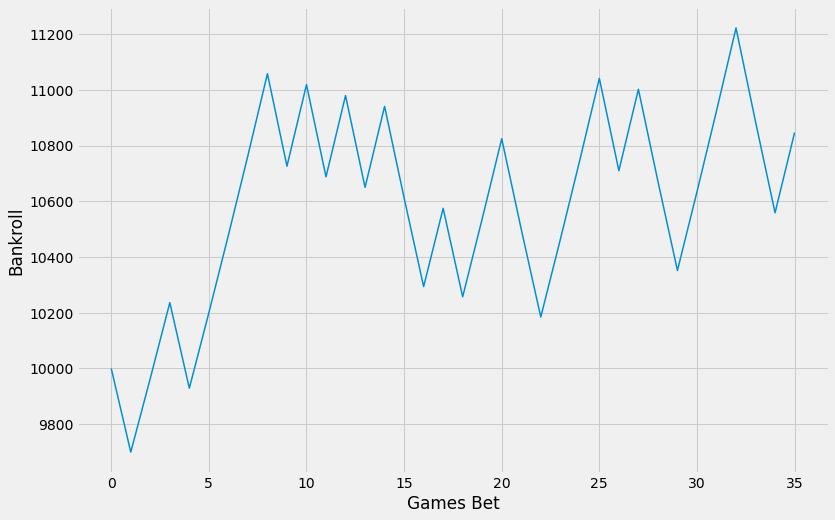

min balance: 9700.0 
max balance: 11221.785256096538 
final balance: 11142.353657630785 
win percentage 58.330000000000005


,index,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,score_pred_home,score_pred_away,score_pred_diff,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,bet_home4,confidence_pred1,confidence_pred2,confidence_pred3,confidence_pred4,bankroll_i,bankroll_n,bet_size,bet_won
0,10,21600092,LAL vs. PHX,-4.0,1.571429,2.550000,119,108,11,1,112.742199,112.556603,0.185596,0.353748,0.368025,-0.007139,0,0,0,0,-3.814404,-3.646252,-4.368025,-4.007139,10000.000000,9700.000000,300.000000,0
1,14,21600099,GSW vs. NOP,-16.5,1.020000,14.000000,116,106,10,0,114.418494,103.285799,11.132695,10.108093,-11.389953,10.749023,0,0,0,0,-5.367305,-6.391907,-5.110047,-5.750977,9700.000000,9964.545455,291.000000,1
2,18,21600104,LAL vs. DAL,-4.0,1.571429,2.550000,97,109,-12,0,103.727508,103.675244,0.052263,-0.606675,0.500672,-0.553673,0,0,0,0,-3.947737,-4.606675,-4.500672,-4.553673,9964.545455,10236.305785,298.936364,1
3,19,21600105,SAC vs. NOP,-6.5,1.377358,3.250000,102,94,8,1,102.166950,100.083741,2.083209,2.460533,-2.070168,2.265350,0,0,0,0,-4.416791,-4.039467,-4.429832,-4.234650,10236.305785,9929.216612,307.089174,0
4,68,21600154,MIA vs. ATL,6.5,3.350000,1.370370,90,93,-3,1,97.753636,100.427841,-2.674205,-2.906791,2.447653,-2.677222,1,1,1,1,3.825795,3.593209,4.052347,3.822778,9929.216612,10200.013428,297.876498,1
5,382,21600469,POR vs. TOR,8.0,3.900000,1.263158,91,95,-4,1,107.620416,110.971838,-3.351423,-3.334339,3.161161,-3.247750,1,1,1,1,4.648577,4.665661,4.838839,4.752250,10200.013428,10478.195613,306.000403,1
6,735,21600821,CHA vs. PHI,-8.0,1.266667,3.750000,99,105,-6,0,107.861317,104.065178,3.796139,4.331418,-3.763197,4.047308,0,0,0,0,-4.203861,-3.668582,-4.236803,-3.952692,10478.195613,10763.964584,314.345868,1
7,770,21600856,PHI vs. WAS,9.5,4.500000,1.200000,120,112,8,1,108.913707,113.895077,-4.981370,-4.606251,4.970168,-4.788209,1,1,1,1,4.518630,4.893749,4.529832,4.711791,10763.964584,11057.527254,322.918938,1
8,1087,21601173,PHI vs. CHI,6.0,2.950000,1.392157,90,102,-12,0,106.742441,108.201554,-1.459114,-1.330934,1.926777,-1.628855,1,1,1,1,4.540886,4.669066,4.073223,4.371145,11057.527254,10725.801437,331.725818,0
9,1263,21700120,ORL vs. CHI,-7.5,1.294118,3.700000,83,105,-22,0,103.032587,100.534534,2.498052,2.299637,-2.120115,2.209876,0,0,0,0,-5.001948,-5.200363,-5.379885,-5.290124,10725.801437,11018.323294,321.774043,1


In [674]:
lr_pipeline_diff = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipeline_diff.fit(X_train1, point_diff_train1)


lr_pipeline_score = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipeline_score.fit(X_train1, team_score_train1)


diff_preds_lr = lr_pipeline_diff.predict(X_test1)
score_preds_lr = lr_pipeline_score.predict(X_test1)

mae_diff = mean_absolute_error(point_diff_test1, diff_preds)
mae_score = mean_absolute_error(team_score_test1, score_preds)

print("mae_diff:", mae_diff, "mae_score:", mae_score)

select_bets_lr, bet_thresholds_lr = find_optimal_confidence_thresholds(diff_preds_lr, score_preds_lr, test_idx1)
simulate_bets(select_bets_lr)

mae_diff: 9.97882777344294 mae_score: 9.156836916890176


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


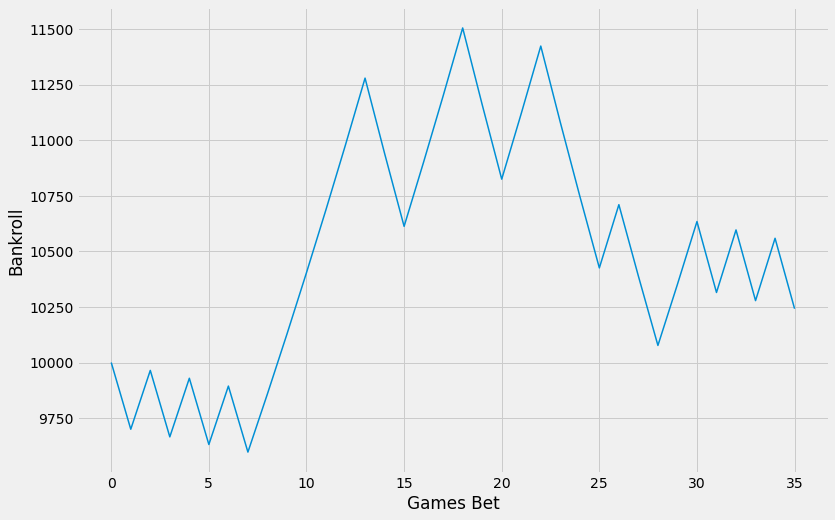

min balance: 9597.192634639892 
max balance: 11504.28164605747 
final balance: 9934.565802586272 
win percentage 52.78


,index,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,score_pred_home,score_pred_away,score_pred_diff,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,bet_home4,confidence_pred1,confidence_pred2,confidence_pred3,confidence_pred4,bankroll_i,bankroll_n,bet_size,bet_won
0,0,21800068,NYK vs. GSW,11.5,7.350000,1.090909,100,128,-28,0,111.973284,119.234799,-7.261515,-7.212948,7.322270,-7.267609,1,1,1,1,4.238485,4.287052,4.177730,4.232391,10000.000000,9700.000000,300.000000,0
1,4,21800083,BKN vs. GSW,9.5,4.970000,1.166667,114,120,-6,1,113.281176,118.107663,-4.826487,-4.506122,4.923575,-4.714848,1,1,1,1,4.673513,4.993878,4.576425,4.785152,9700.000000,9964.545455,291.000000,1
2,6,21800086,LAC vs. WAS,-3.5,1.645161,2.350000,136,104,32,1,118.684880,119.874144,-1.189265,-0.533032,1.515867,-1.024450,0,0,0,0,-4.689265,-4.033032,-5.015867,-4.524450,9964.545455,9665.609091,298.936364,0
3,14,21800094,SAS vs. DAL,-7.0,1.333333,3.500000,113,108,5,0,113.902499,111.058397,2.844102,2.860044,-2.709956,2.785000,0,0,0,0,-4.155898,-4.139956,-4.290044,-4.215000,9665.609091,9929.216612,289.968273,1
4,24,21800104,BKN vs. DET,-2.0,1.740741,2.150000,120,119,1,0,112.219877,105.975503,6.244374,6.278652,-6.902500,6.590576,1,1,1,1,4.244374,4.278652,4.902500,4.590576,9929.216612,9631.340113,297.876498,0
5,57,21800137,SAS vs. ORL,-7.5,1.270270,3.850000,110,117,-7,0,107.824603,104.653955,3.170648,2.591544,-3.356110,2.973827,0,0,0,0,-4.329352,-4.908456,-4.143890,-4.526173,9631.340113,9894.013025,288.940203,1
6,74,21800154,ORL vs. DET,3.0,2.300000,1.666667,96,103,-7,0,110.984089,110.605831,0.378258,0.431336,-0.910719,0.671027,1,1,1,1,3.378258,3.431336,3.910719,3.671027,9894.013025,9597.192635,296.820391,0
7,105,21800185,HOU vs. IND,-2.5,1.689655,2.250000,115,103,12,1,103.981000,97.766510,6.214490,5.952480,-6.548256,6.250368,1,1,1,1,3.714490,3.452480,4.048256,3.750368,9597.192635,9858.934252,287.915779,1
8,306,21800386,LAC vs. MIA,-9.5,1.175439,5.000000,98,121,-23,0,114.471192,109.026426,5.444766,5.420413,-5.265912,5.343163,0,0,0,0,-4.055234,-4.079587,-4.234088,-4.156837,9858.934252,10127.814277,295.768028,1
9,308,21800388,TOR vs. MIL,-5.0,1.487805,2.750000,99,104,-5,0,119.315629,118.165155,1.150474,1.294694,-0.803624,1.049159,0,0,0,0,-3.849526,-3.705306,-4.196376,-3.950841,10127.814277,10404.027394,303.834428,1


In [739]:
lr_pipeline_diff = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipeline_diff.fit(X_train2, point_diff_train2)


lr_pipeline_score = Pipeline([('scaler', StandardScaler()),
                    ('linreg', LinearRegression())])

lr_pipeline_score.fit(X_train2, team_score_train2)


diff_preds_lr2 = lr_pipeline_diff.predict(X_test2)
score_preds_lr2 = lr_pipeline_score.predict(X_test2)

mae_diff = mean_absolute_error(point_diff_test2, diff_preds_lr2)
mae_score = mean_absolute_error(team_score_test2, score_preds_lr2)

print("mae_diff:", mae_diff, "mae_score:", mae_score)

bets = create_betting_df(final_df_ewm_19, diff_preds_lr2, score_preds_lr2, test_idx2, 3)
select_bets = bets.loc[abs(bets['confidence_pred3']) > 3.87]    
simulate_bets(select_bets)

In [737]:
bets

,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,score_pred_home,score_pred_away,score_pred_diff,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,bet_home4,confidence_pred1,confidence_pred2,confidence_pred3,confidence_pred4,bankroll_i,bankroll_n,bet_size,bet_won
0,21800068,NYK vs. GSW,11.5,7.350000,1.090909,100,128,-28,0,111.973284,119.234799,-7.261515,-7.212948,7.322270,-7.267609,1,1,1,1,4.238485,4.287052,4.177730,4.232391,10000.0,NaN,NaN,0
1,21800077,CLE vs. IND,7.0,3.340000,1.312500,107,119,-12,0,105.035275,108.946275,-3.911000,-3.737730,4.379403,-4.058567,1,1,1,1,3.089000,3.262270,2.620597,2.941433,NaN,NaN,NaN,0
2,21800078,PHI vs. CHA,-7.0,1.285714,3.300000,105,103,2,0,119.537047,111.210348,8.326699,8.529779,-8.181971,8.355875,1,1,1,1,1.326699,1.529779,1.181971,1.355875,NaN,NaN,NaN,0
3,21800081,MIL vs. ORL,-9.0,1.204082,4.450000,113,91,22,1,119.439808,110.166698,9.273110,9.091656,-9.239579,9.165618,1,1,1,1,0.273110,0.091656,0.239579,0.165618,NaN,NaN,NaN,1
4,21800083,BKN vs. GSW,9.5,4.970000,1.166667,114,120,-6,1,113.281176,118.107663,-4.826487,-4.506122,4.923575,-4.714848,1,1,1,1,4.673513,4.993878,4.576425,4.785152,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,41900402,LAL vs. MIA,-11.0,1.157480,4.930000,124,114,10,0,113.240781,102.371969,10.868812,11.018545,-10.638858,10.828702,0,1,0,0,-0.131188,0.018545,-0.361142,-0.171298,NaN,NaN,NaN,0
2263,41900403,MIA vs. LAL,9.5,4.300000,1.210526,115,104,11,1,103.615083,112.230101,-8.615018,-8.216496,8.783213,-8.499855,1,1,1,1,0.884982,1.283504,0.716787,1.000145,NaN,NaN,NaN,1
2264,41900404,MIA vs. LAL,7.5,3.520000,1.273973,96,102,-6,1,104.308488,111.835024,-7.526536,-6.996262,7.806986,-7.401624,0,1,0,1,-0.026536,0.503738,-0.306986,0.098376,NaN,NaN,NaN,1
2265,41900405,LAL vs. MIA,-7.5,1.289855,3.070000,108,111,-3,0,110.663832,103.222394,7.441438,7.681678,-7.013033,7.347356,0,1,0,0,-0.058562,0.181678,-0.486967,-0.152644,NaN,NaN,NaN,0


In [656]:
lr_feature_names = X_train1.columns
lr_diff_coefs = lr_pipeline_diff.named_steps['linreg'].coef_
lr_score_coefs = lr_pipeline_score.named_steps['linreg'].coef_

coef_df = pd.DataFrame({'feature':lr_feature_names,
                       'lr_diff_coef':lr_diff_coefs,
                       'lr_score_coef':lr_score_coefs})
coef_df.sort_values('lr_diff_coef', ascending=False)

,feature,lr_diff_coef,lr_score_coef
13,REB_team_x,5.331582e+13,2.736192e+13
7,FG3M_team_x,4.713877e+13,-1.788071e+13
100,DREB_team_y,3.594463e+13,1.801305e+13
5,FG2M_team_x,3.289421e+13,-1.247745e+13
128,FG3M_opp_y,2.626991e+13,1.384291e+13
...,...,...,...
101,REB_team_y,-3.958614e+13,-1.983793e+13
12,DREB_team_x,-4.840901e+13,-2.484372e+13
74,OREB_PCT_opp_x,-4.997719e+13,-1.867837e+13
75,DREB_PCT_team_x,-4.997719e+13,-1.867837e+13


### SGD

In [658]:
tscv = TimeSeriesSplit()

best_sgd_diff: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.007847599703514606, epsilon=1.27427,
                              l1_ratio=1.0, loss='huber', max_iter=5000,
                              penalty='elasticnet'))])
best_sgd_score: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.007847599703514606, epsilon=0.379269,
                              l1_ratio=0.05, loss='huber', max_iter=5000,
                              penalty='elasticnet'))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 0.95
best prediction strat: 2
num_games_bet: 574
win percetange at threshold: 0.5365853658536586


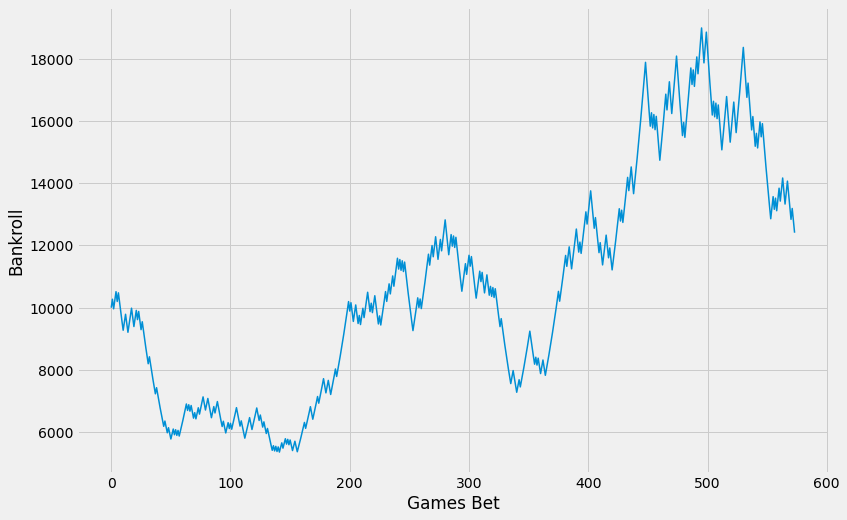

min balance: 5361.818036823288 
max balance: 18986.768444911406 
final balance: 12036.351969446603 
win percentage 53.66


,index,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,score_pred_home,score_pred_away,score_pred_diff,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,bet_home4,confidence_pred1,confidence_pred2,confidence_pred3,confidence_pred4,bankroll_i,bankroll_n,bet_size,bet_won
0,3,21600083,IND vs. CHI,-3.5,1.606061,2.400000,111,94,17,1,112.054140,108.076696,3.977444,4.476443,-4.223869,4.350156,1,1,1,1,0.477444,0.976443,0.723869,0.850156,10000.000000,10272.727273,300.000000,1
1,11,21600096,CHI vs. ORL,-7.0,1.333333,3.400000,112,80,32,1,104.201313,100.075529,4.125784,5.454791,-5.388742,5.421766,0,0,0,0,-2.874216,-1.545209,-1.611258,-1.578234,10272.727273,9964.545455,308.181818,0
2,14,21600099,GSW vs. NOP,-16.5,1.020000,14.000000,116,106,10,0,116.425821,102.447470,13.978351,14.788220,-14.591783,14.690001,0,0,0,0,-2.521649,-1.711780,-1.908217,-1.809999,9964.545455,10236.305785,298.936364,1
3,18,21600104,LAL vs. DAL,-4.0,1.571429,2.550000,97,109,-12,0,101.949743,102.821670,-0.871927,1.525840,-1.417734,1.471787,0,0,0,0,-4.871927,-2.474160,-2.582266,-2.528213,10236.305785,10515.477761,307.089174,1
4,24,21600110,IND vs. PHI,-11.5,1.090909,7.000000,122,115,7,0,109.091135,95.242583,13.848552,12.703295,-12.446853,12.575074,1,1,1,1,2.348552,1.203295,0.946853,1.075074,10515.477761,10200.013428,315.464333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,2440,41700313,GSW vs. HOU,-7.5,1.250000,3.850000,126,85,41,1,107.778061,104.930725,2.847336,6.011819,-5.942173,5.976996,0,0,0,0,-4.652664,-1.488181,-1.557827,-1.523004,13234.946302,12837.897913,397.048389,0
570,2442,41700314,GSW vs. HOU,-7.5,1.232558,4.400000,92,95,-3,0,108.105243,103.739611,4.365633,6.489130,-6.334338,6.411734,0,0,0,0,-3.134367,-1.010870,-1.165662,-1.088266,12837.897913,13188.022402,385.136937,1
571,2445,41700306,CLE vs. BOS,-7.0,1.322581,3.500000,109,99,10,1,101.806067,97.901593,3.904474,5.916183,-5.709245,5.812714,0,0,0,0,-3.095526,-1.083817,-1.290755,-1.187286,13188.022402,12792.381730,395.640672,0
572,2446,41700316,GSW vs. HOU,-12.5,1.094340,6.500000,115,86,29,1,106.274410,99.727420,6.546990,10.693633,-10.516252,10.604942,0,0,0,0,-5.953010,-1.806367,-1.983748,-1.895058,12792.381730,12408.610278,383.771452,0


In [679]:
sgd_pipe_diff = make_pipeline(StandardScaler(), SGDRegressor(loss='huber', max_iter=5000,epsilon=1.27427, penalty='elasticnet'))
sgd_pipe_score = make_pipeline(StandardScaler(), SGDRegressor(loss='huber', max_iter=5000, epsilon=0.379269, penalty='elasticnet'))

params = {
#       'sgdregressor__epsilon':np.logspace(-2, 3, 20),
    'sgdregressor__alpha':np.logspace(-4, 2, 20),
    'sgdregressor__l1_ratio':np.linspace(0.05, 1, 20)
}

sgd_cv_diff = GridSearchCV(sgd_pipe_diff, param_grid = params, scoring='neg_mean_absolute_error', cv=tscv)

sgd_cv_score = GridSearchCV(sgd_pipe_score, param_grid = params, scoring='neg_mean_absolute_error', cv=tscv)

sgd_cv_diff.fit(X_train1, point_diff_train1)
sgd_cv_score.fit(X_train1, team_score_train1)

best_sgd_diff = sgd_cv_diff.best_estimator_
print("best_sgd_diff:", best_sgd_diff)

best_sgd_score = sgd_cv_score.best_estimator_
print("best_sgd_score:", best_sgd_score)

sgd_preds_diff = best_sgd_diff.predict(X_test1)
sgd_preds_score = best_sgd_score.predict(X_test1)



select_bets_sgd, bet_thresholds_sgd = find_optimal_confidence_thresholds(sgd_preds_diff,
                                                                               sgd_preds_score,
                                                                               test_idx1)
simulate_bets(select_bets_sgd)



mae_diff: 9.939642671804318 mae_score: 9.212445920421596


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


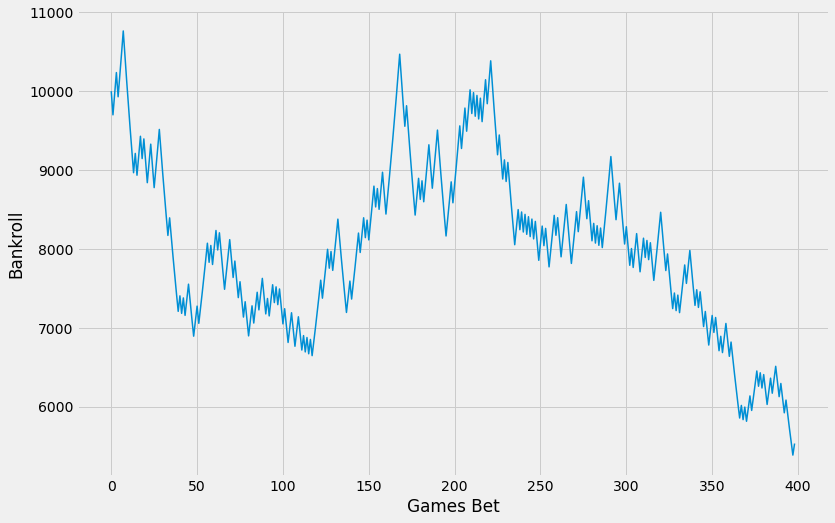

min balance: 5384.970338871532 
max balance: 10763.964583910501 
final balance: 5682.701343557899 
win percentage 50.629999999999995


,index,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,score_pred_home,score_pred_away,score_pred_diff,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,bet_home4,confidence_pred1,confidence_pred2,confidence_pred3,confidence_pred4,bankroll_i,bankroll_n,bet_size,bet_won
0,0,21800068,NYK vs. GSW,11.5,7.350000,1.090909,100,128,-28,0,109.286270,119.327286,-10.041015,-10.398821,10.703985,-10.551403,1,1,1,1,1.458985,1.101179,0.796015,0.948597,10000.000000,9700.000000,300.000000,0
1,3,21800081,MIL vs. ORL,-9.0,1.204082,4.450000,113,91,22,1,119.575645,107.717687,11.857957,10.336027,-9.878907,10.107467,1,1,1,1,2.857957,1.336027,0.878907,1.107467,9700.000000,9964.545455,291.000000,1
2,4,21800083,BKN vs. GSW,9.5,4.970000,1.166667,114,120,-6,1,110.719838,118.642714,-7.922876,-8.389928,9.054955,-8.722442,1,1,1,1,1.577124,1.110072,0.445045,0.777558,9964.545455,10236.305785,298.936364,1
3,6,21800086,LAC vs. WAS,-3.5,1.645161,2.350000,136,104,32,1,122.919904,119.440443,3.479461,2.410157,-2.491310,2.450734,0,0,0,0,-0.020539,-1.089843,-1.008690,-1.049266,10236.305785,9929.216612,307.089174,0
4,12,21800092,MIL vs. TOR,2.0,2.100000,1.769231,124,109,15,1,115.450868,114.761623,0.689245,-0.673643,1.400557,-1.037100,1,1,1,1,2.689245,1.326357,0.599443,0.962900,9929.216612,10200.013428,297.876498,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,2244,41900224,HOU vs. LAL,5.5,2.750000,1.322581,100,110,-10,0,110.713700,112.282912,-1.569211,-3.419803,4.150725,-3.785264,1,1,1,1,3.930789,2.080197,1.349275,1.714736,5900.218741,5723.212179,177.006562,0
395,2245,41900217,TOR vs. BOS,3.5,1.970874,1.606061,87,92,-5,0,108.591764,108.452779,0.138986,-2.233456,2.840625,-2.537041,1,1,1,1,3.638986,1.266544,0.659375,0.962959,5723.212179,5551.515813,171.696365,0
396,2253,41900303,MIA vs. BOS,3.5,2.500000,1.588235,106,117,-11,0,107.278154,106.752624,0.525530,-1.965155,2.604236,-2.284695,1,1,1,1,4.025530,1.534845,0.895764,1.215305,5551.515813,5384.970339,166.545474,0
397,2256,41900304,MIA vs. BOS,3.5,2.380000,1.588235,112,109,3,1,108.183616,108.140121,0.043496,-2.011160,2.601816,-2.306488,1,1,1,1,3.543496,1.488840,0.898184,1.193512,5384.970339,5531.833166,161.549110,1


In [741]:
best_sgd_diff= Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.007847599703514606, epsilon=1.27427,
                              l1_ratio=1.0, loss='huber', max_iter=5000,
                              penalty='elasticnet'))])
best_sgd_score= Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.007847599703514606, epsilon=0.379269,
                              l1_ratio=0.05, loss='huber', max_iter=5000,
                              penalty='elasticnet'))])


best_sgd_diff.fit(X_train2, point_diff_train2)

best_sgd_score.fit(X_train2, team_score_train2)

diff_preds_sgd2 = best_sgd_diff.predict(X_test2)
score_preds_sgd2 = best_sgd_score.predict(X_test2)

mae_diff = mean_absolute_error(point_diff_test2, diff_preds_sgd2)
mae_score = mean_absolute_error(team_score_test2, score_preds_sgd2)

print("mae_diff:", mae_diff, "mae_score:", mae_score)

bets = create_betting_df(final_df_ewm_19, diff_preds_sgd2, score_preds_sgd2, test_idx2, 2)
select_bets = bets.loc[abs(bets['confidence_pred2']) > .95]    
simulate_bets(select_bets)


In [681]:
select_bets

,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,score_pred_home,score_pred_away,score_pred_diff,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,bet_home4,confidence_pred1,confidence_pred2,confidence_pred3,confidence_pred4,bankroll_i,bankroll_n,bet_size,bet_won
3,21800081,MIL vs. ORL,-9.0,1.204082,4.450000,113,91,22,1,12.125229,-11.478510,23.603739,10.019198,-9.972091,9.995644,1,1,1,1,14.603739,1.019198,0.972091,0.995644,NaN,NaN,NaN,1
6,21800086,LAC vs. WAS,-3.5,1.645161,2.350000,136,104,32,1,2.096804,-1.040793,3.137597,1.994728,-2.732030,2.363379,0,0,0,0,-0.362403,-1.505272,-0.767970,-1.136621,NaN,NaN,NaN,0
14,21800094,SAS vs. DAL,-7.0,1.333333,3.500000,113,108,5,0,3.720031,-3.504888,7.224919,4.709100,-5.416241,5.062671,1,0,0,0,0.224919,-2.290900,-1.583759,-1.937329,NaN,NaN,NaN,1
15,21800095,DEN vs. NOP,-9.5,1.181818,4.500000,116,111,5,0,5.163215,-5.022549,10.185764,7.665026,-8.426039,8.045532,1,0,0,0,0.685764,-1.834974,-1.073961,-1.454468,NaN,NaN,NaN,1
18,21800098,ORL vs. SAC,-4.5,1.500000,2.600000,99,107,-8,0,2.619041,-1.873895,4.492936,3.496898,-3.992621,3.744760,0,0,0,0,-0.007064,-1.003102,-0.507379,-0.755240,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2241,41900223,HOU vs. LAL,4.5,2.440000,1.526316,102,112,-10,0,0.162231,1.246326,-1.084094,-3.249873,3.029821,-3.139847,1,1,1,1,3.415906,1.250127,1.470179,1.360153,NaN,NaN,NaN,0
2242,41900216,BOS vs. TOR,-3.0,1.625000,2.400000,122,125,-3,0,2.045393,-0.864052,2.909446,1.997696,-2.356834,2.177265,0,0,0,0,-0.090554,-1.002304,-0.643166,-0.822735,NaN,NaN,NaN,1
2244,41900224,HOU vs. LAL,5.5,2.750000,1.322581,100,110,-10,0,-0.617298,1.994594,-2.611892,-4.133194,3.896331,-4.014763,1,1,1,1,2.888108,1.366806,1.603669,1.485237,NaN,NaN,NaN,0
2247,41900225,LAL vs. HOU,-6.5,1.384615,2.840000,119,96,23,1,5.858207,-4.537646,10.395854,5.361324,-5.741905,5.551614,1,0,0,0,3.895854,-1.138676,-0.758095,-0.948386,NaN,NaN,NaN,0


In [693]:
feature_names = X_train1.columns
sgd_diff_coefs = best_sgd_diff.named_steps['sgdregressor'].coef_
sgd_score_coefs = best_sgd_score.named_steps['sgdregressor'].coef_

coef_df_sgd = pd.DataFrame({'feature':feature_names,
                       'sgd_diff_coefs':sgd_diff_coefs,
                       'sgd_score_coefs':sgd_score_coefs})
coef_df_sgd.sort_values('sgd_diff_coefs', ascending=False)

,feature,sgd_diff_coefs,sgd_score_coefs
87,team_elo_pred_x,0.639010,0.498639
35,AST_3PM_team_x,0.263570,0.165206
151,PTS_FB_opp_y,0.198762,0.000000
135,AST_opp_y,0.153250,0.229280
62,PTS_2PT_MR_opp_x,0.135353,0.073000
...,...,...,...
47,AST_opp_x,-0.135772,0.077775
119,PTS_OFF_TOV_team_y,-0.149786,0.000000
63,PTS_FB_opp_x,-0.183310,-0.295468
123,AST_3PM_team_y,-0.256828,0.074906


### Elastic Net

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8285.322912291274, tolerance: 70.07719337645541
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25959.193626309396, tolerance: 142.36569532867495
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13919.383373657474, tolerance: 210.31039875765686
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want

best_en_diff: Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.0379269019073225, max_iter=10000))])
best_en_score: Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.0379269019073225, max_iter=10000))])
mae_diff: 9.669087115392664 mae_score: 8.788406540072607


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 2.21
best prediction strat: 2
num_games_bet: 205
win percetange at threshold: 0.5804878048780487


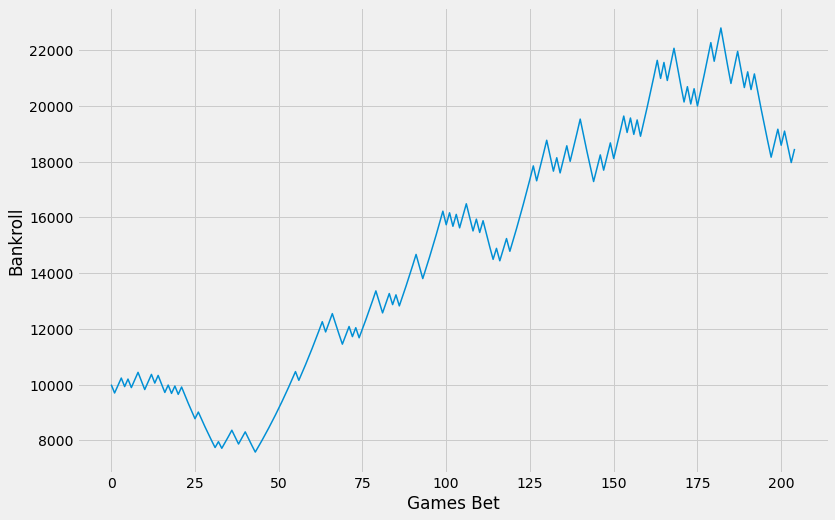

min balance: 7579.438030390444 
max balance: 22798.8167045725 
final balance: 17905.002566318657 
win percentage 58.050000000000004


,index,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,score_pred_home,score_pred_away,score_pred_diff,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,bet_home4,confidence_pred1,confidence_pred2,confidence_pred3,confidence_pred4,bankroll_i,bankroll_n,bet_size,bet_won
0,12,21600097,OKC vs. MIA,-5.5,1.425532,2.950000,97,85,12,1,105.258490,102.114891,3.143599,3.163240,-3.157944,3.160592,0,0,0,0,-2.356401,-2.336760,-2.342056,-2.339408,10000.000000,9700.000000,300.000000,0
1,14,21600099,GSW vs. NOP,-16.5,1.020000,14.000000,116,106,10,0,117.141247,103.375142,13.766105,12.779863,-14.174450,13.477157,0,0,0,0,-2.733895,-3.720137,-2.325550,-3.022843,9700.000000,9964.545455,291.000000,1
2,18,21600104,LAL vs. DAL,-4.0,1.571429,2.550000,97,109,-12,0,103.340600,102.545948,0.794652,0.650412,-0.439907,0.545159,0,0,0,0,-3.205348,-3.349588,-3.560093,-3.454841,9964.545455,10236.305785,298.936364,1
3,30,21600116,GSW vs. DAL,-18.5,1.011111,16.000000,116,95,21,1,110.938063,95.726404,15.211659,14.018469,-15.757313,14.887891,0,0,0,0,-3.288341,-4.481531,-2.742687,-3.612109,10236.305785,9929.216612,307.089174,0
4,57,21600143,GSW vs. PHX,-16.5,1.020000,16.000000,133,120,13,0,122.242005,106.806253,15.435753,14.164180,-15.975093,15.069637,0,0,0,0,-1.064247,-2.335820,-0.524907,-1.430363,9929.216612,10200.013428,297.876498,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,2421,41700222,HOU vs. UTA,-10.5,1.111111,6.500000,108,116,-8,0,106.704029,99.951837,6.752192,6.887877,-7.146748,7.017312,0,0,0,0,-3.747808,-3.612123,-3.353252,-3.482688,18590.354360,19097.364024,557.710631,1
201,2424,41700223,UTA vs. HOU,4.5,2.700000,1.500000,92,113,-21,0,103.359227,104.906177,-1.546949,-1.594355,1.897419,-1.745887,1,1,1,1,2.953051,2.905645,2.602581,2.754113,19097.364024,18524.443103,572.920921,0
202,2428,41700224,UTA vs. HOU,6.0,3.250000,1.363636,87,100,-13,0,101.735000,105.251764,-3.516764,-3.548331,3.795970,-3.672151,1,1,1,1,2.483236,2.451669,2.204030,2.327849,18524.443103,17968.709810,555.733293,0
203,2432,41700225,HOU vs. UTA,-12.0,1.105263,8.000000,112,102,10,0,106.750844,97.276219,9.474624,9.422805,-9.908638,9.665721,0,0,0,0,-2.525376,-2.577195,-2.091362,-2.334279,17968.709810,18458.765532,539.061294,1


In [694]:
en_pipeline_diff = Pipeline([('scaler', StandardScaler()),
                        ('en', ElasticNet(max_iter=10000))])

en_pipeline_score = Pipeline([('scaler', StandardScaler()),
                        ('en', ElasticNet(max_iter=10000))])


params = {"en__alpha":np.logspace(-3, 2, 20)}

en_cv_diff = GridSearchCV(en_pipeline_diff, params, scoring='neg_mean_absolute_error', cv=tscv)
en_cv_score = GridSearchCV(en_pipeline_score, params, scoring='neg_mean_absolute_error', cv=tscv)

en_cv_diff.fit(X_train1, point_diff_train1)
en_cv_score.fit(X_train1, team_score_train1)

best_en_diff = en_cv_diff.best_estimator_
print("best_en_diff:", best_en_diff)

best_en_score = en_cv_score.best_estimator_
print("best_en_score:", best_en_score)

diff_preds_en = best_en_diff.predict(X_test1)
score_preds_en = best_en_score.predict(X_test1)

mae_diff = mean_absolute_error(point_diff_test1, diff_preds_en)
mae_score = mean_absolute_error(team_score_test1, score_preds_en)

print("mae_diff:", mae_diff, "mae_score:", mae_score)


select_bets_en, bet_thresholds_en = find_optimal_confidence_thresholds(diff_preds_en,
                                                                               score_preds_en,
                                                                               test_idx1)
simulate_bets(select_bets_en)



mae_diff: 9.959336938979252 mae_score: 9.199596039940612


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


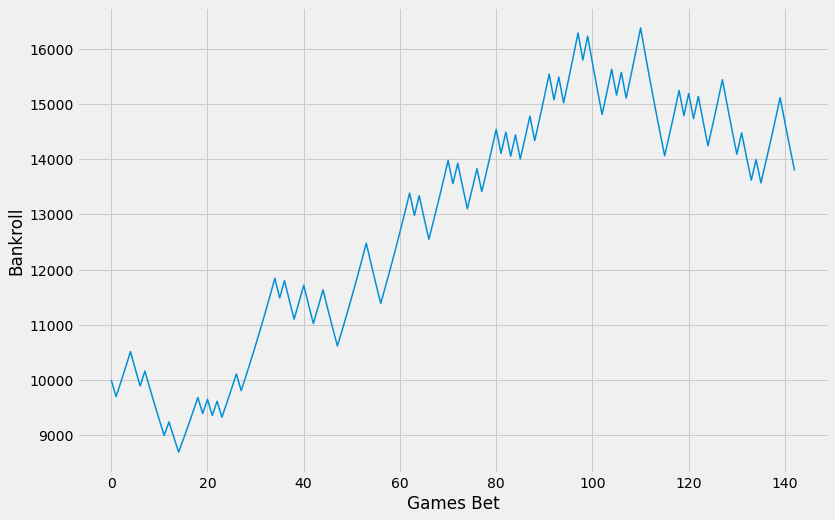

min balance: 8697.098725631336 
max balance: 16373.079902549598 
final balance: 14167.981232797505 
win percentage 57.34


,index,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,score_pred_home,score_pred_away,score_pred_diff,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,bet_home4,confidence_pred1,confidence_pred2,confidence_pred3,confidence_pred4,bankroll_i,bankroll_n,bet_size,bet_won
0,1,21800077,CLE vs. IND,7.0,3.340000,1.312500,107,119,-12,0,105.697580,109.734151,-4.036571,-4.303396,4.225059,-4.264227,1,1,1,1,2.963429,2.696604,2.774941,2.735773,10000.000000,9700.000000,300.000000,0
1,14,21800094,SAS vs. DAL,-7.0,1.333333,3.500000,113,108,5,0,115.444981,111.448558,3.996423,3.264652,-3.285122,3.274887,0,0,0,0,-3.003577,-3.735348,-3.714878,-3.725113,9700.000000,9964.545455,291.000000,1
2,23,21800103,OKC vs. LAC,-3.5,1.606061,2.400000,128,110,18,1,118.850596,112.572840,6.277755,6.094333,-6.008058,6.051195,1,1,1,1,2.777755,2.594333,2.508058,2.551195,9964.545455,10236.305785,298.936364,1
3,70,21800150,DAL vs. WAS,2.0,2.100000,1.769231,119,100,19,1,117.777722,118.004403,-0.226681,0.244685,0.078915,0.082885,1,1,1,1,1.773319,2.244685,1.921085,2.082885,10236.305785,10515.477761,307.089174,1
4,94,21800174,TOR vs. NYK,-14.0,1.055556,9.500000,128,112,16,1,119.794071,107.657771,12.136299,11.339639,-12.420272,11.879956,0,0,0,0,-1.863701,-2.660361,-1.579728,-2.120044,10515.477761,10200.013428,315.464333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,2192,41900112,TOR vs. BKN,-11.5,1.125000,1.769231,104,99,5,0,120.456557,111.459608,8.996950,9.037661,-8.722924,8.880293,0,0,0,0,-2.503050,-2.462339,-2.777076,-2.619707,14710.290641,15111.480386,441.308719,1
139,2200,41900113,BKN vs. TOR,11.0,1.909091,1.153846,92,117,-25,0,110.525804,118.385565,-7.859761,-7.655662,7.927028,-7.791345,1,1,1,1,3.140239,3.344338,3.072972,3.208655,15111.480386,14658.135974,453.344412,0
140,2208,41900114,BKN vs. TOR,14.0,7.950000,1.076923,122,150,-28,0,108.212089,118.581137,-10.369048,-10.859903,10.134318,-10.497110,1,1,1,1,3.630952,3.140097,3.865682,3.502890,14658.135974,14218.391895,439.744079,0
141,2253,41900303,MIA vs. BOS,3.5,2.500000,1.588235,106,117,-11,0,105.955419,107.138318,-1.182899,-1.199626,1.336639,-1.268132,1,1,1,1,2.317101,2.300374,2.163361,2.231868,14218.391895,13791.840138,426.551757,0


In [697]:
best_en_diff= Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.0379269019073225, max_iter=10000))])
best_en_score= Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.0379269019073225, max_iter=10000))])
    
best_en_diff.fit(X_train2, point_diff_train2)

best_en_score.fit(X_train2, team_score_train2)

diff_preds_en2 = best_en_diff.predict(X_test2)
score_preds_en2 = best_en_score.predict(X_test2)

mae_diff = mean_absolute_error(point_diff_test2, diff_preds_en2)
mae_score = mean_absolute_error(team_score_test2, score_preds_en2)

print("mae_diff:", mae_diff, "mae_score:", mae_score)

bets = create_betting_df(final_df_ewm_19, diff_preds_en2, score_preds_en2, test_idx2)
select_bets = bets.loc[abs(bets['confidence_pred2']) > 2.2]    
simulate_bets(select_bets)


In [701]:
feature_names = X_train1.columns
en_diff_coefs = best_en_diff.named_steps['en'].coef_
en_score_coefs = best_en_score.named_steps['en'].coef_

coef_df_en = pd.DataFrame({'feature':feature_names,
                       'en_diff_coefs':en_diff_coefs,
                       'en_score_coefs':en_score_coefs})
coef_df_en.sort_values('en_diff_coefs', ascending=False)

,feature,en_diff_coefs,en_score_coefs
87,team_elo_pred_x,0.467473,0.000000
129,FG3A_opp_y,0.323722,0.066766
151,PTS_FB_opp_y,0.296623,-0.013188
2,HOME_GAME_x,0.256592,0.220913
153,PTS_PAINT_opp_y,0.230701,0.105673
...,...,...,...
65,PTS_PAINT_opp_x,-0.235129,-0.000000
63,PTS_FB_opp_x,-0.280357,-0.346155
41,FG3A_opp_x,-0.347850,-0.000000
1,ml_x,-0.387580,-0.153190


In [695]:
### Light Gradient Boost

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


[LightGBM] [Warning] feature_fraction is set=0.6880319327164988, colsample_bytree=0.5597090226673742 will be ignored. Current value: feature_fraction=0.6880319327164988
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


best_lgbr_diff: LGBMRegressor(colsample_bytree=0.5597090226673742,
              feature_fraction=0.6880319327164988, max_depth=26,
              min_child_weight=1, num_leaves=2, objective='regression',
              reg_alpha=4, reg_lambda=4, subsample=0.6521226559898796,
              subsample_freq=1)
best_lgbr_score: LGBMRegressor(colsample_bytree=0.5, feature_fraction=1.0, max_depth=3,
              min_child_weight=1, num_leaves=2, objective='regression',
              reg_alpha=0, reg_lambda=1, subsample=0.6, subsample_freq=1)


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 4.64
best prediction strat: 1
num_games_bet: 204
win percetange at threshold: 0.5637254901960784


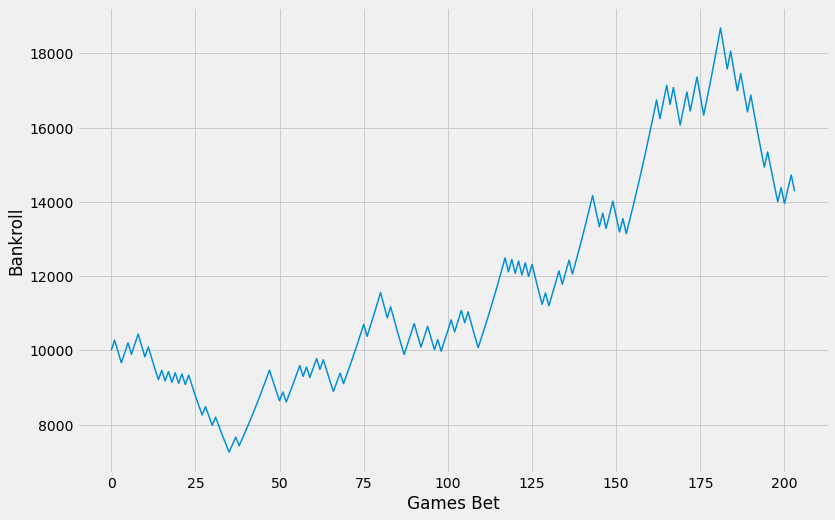

min balance: 7259.2710415060055 
max balance: 18684.62889380134 
final balance: 14673.93385495872 
win percentage 56.37


,index,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,score_pred_home,score_pred_away,score_pred_diff,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,bet_home4,confidence_pred1,confidence_pred2,confidence_pred3,confidence_pred4,bankroll_i,bankroll_n,bet_size,bet_won
0,2,21600078,LAL vs. GSW,11.5,6.500000,1.111111,117,97,20,1,106.862773,112.419303,-5.556530,-10.953667,11.019424,-10.986546,1,1,1,1,5.943470,0.546333,0.480576,0.513454,10000.000000,10272.727273,300.000000,1
1,7,21600089,TOR vs. SAC,-7.5,1.285714,3.750000,91,96,-5,0,106.741806,94.145904,12.595902,7.426425,-8.030444,7.728435,1,0,1,1,5.095902,-0.073575,0.530444,0.228435,10272.727273,9964.545455,308.181818,0
2,8,21600090,DAL vs. MIL,-3.0,1.689655,2.250000,86,75,11,1,102.504412,106.715977,-4.211565,2.019259,-2.083678,2.051469,0,0,0,0,-7.211565,-0.980741,-0.916322,-0.948531,9964.545455,9665.609091,298.936364,0
3,14,21600099,GSW vs. NOP,-16.5,1.020000,14.000000,116,106,10,0,112.145383,102.499841,9.645543,13.495994,-12.894990,13.195492,0,0,0,0,-6.854457,-3.004006,-3.605010,-3.304508,9665.609091,9929.216612,289.968273,1
4,16,21600102,MEM vs. DEN,-4.0,1.571429,2.450000,108,107,1,0,102.336412,103.534066,-1.197654,2.708656,-1.901422,2.305039,0,0,0,0,-5.197654,-1.291344,-2.098578,-1.694961,9929.216612,10200.013428,297.876498,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2417,41700221,HOU vs. UTA,-11.5,1.090909,7.400000,110,96,14,1,107.162709,101.334467,5.828242,10.942788,-10.396412,10.669600,0,0,0,0,-5.671758,-0.557212,-1.103588,-0.830400,14386.190722,13954.605001,431.585722,0
200,2421,41700222,HOU vs. UTA,-10.5,1.111111,6.500000,108,116,-8,0,107.536482,101.733614,5.802868,10.822927,-10.396412,10.609669,0,1,0,1,-4.697132,0.322927,-0.103588,0.109669,13954.605001,14335.185137,418.638150,1
201,2433,41700235,GSW vs. NOP,-12.0,1.090909,7.500000,113,104,9,0,112.422885,106.085199,6.337687,11.452384,-10.891167,11.171776,0,0,0,0,-5.662313,-0.547616,-1.108833,-0.828224,14335.185137,14726.144732,430.055554,1
202,2446,41700316,GSW vs. HOU,-12.5,1.094340,6.500000,115,86,29,1,109.051571,103.285649,5.765922,11.544829,-10.233425,10.889127,0,0,0,0,-6.734078,-0.955171,-2.266575,-1.610873,14726.144732,14284.360390,441.784342,0


In [696]:
lgbr = lgb.LGBMRegressor()

search_spaces = {'min_child_weight':Integer(1,8),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(3, 30),
              'reg_lambda': Integer(1, 10),
              'reg_alpha': Integer(0, 10),
                'boosting_type':Categorical(['gbdt'], transform='string'),
                'num_leaves':Integer(2, 2048),
                'feature_fraction':Real(0.01, 1)}
    
    
lgbr_bs_diff = BayesSearchCV(lgb.LGBMRegressor(objective='regression', subsample_freq=1), search_spaces=search_spaces,
                        cv=tscv, verbose=1, n_jobs=-1)

lgbr_bs_score = BayesSearchCV(lgb.LGBMRegressor(objective='regression', subsample_freq=1), search_spaces=search_spaces,
                        cv=tscv, verbose=1, n_jobs=-1)

lgbr_bs_diff.fit(X_train1, point_diff_train1)
lgbr_bs_score.fit(X_train1, team_score_train1)

best_lgbr_diff = lgbr_bs_diff.best_estimator_
best_lgbr_score = lgbr_bs_score.best_estimator_

print("best_lgbr_diff:", best_lgbr_diff)
print("best_lgbr_score:", best_lgbr_score)

diff_preds_lgbr = best_lgbr_diff.predict(X_test1)
score_preds_lgbr = best_lgbr_score.predict(X_test1)

select_bets_lgbr, bet_thresholds_lgbr = find_optimal_confidence_thresholds(diff_preds_lgbr,
                                                                               score_preds_lgbr,
                                                                               test_idx1)
simulate_bets(select_bets_lgbr)



In [708]:
bet_thresholds_lgbr.loc[bet_thresholds_lgbr['prediction_num']==2]

,index,prediction_num,confidence_thresholds,num_games_bet,win_percentage,expected_profits
87,1199,2,2.00,133,0.548872,820
88,1196,2,1.97,141,0.546099,788
92,1195,2,1.96,145,0.544828,772
97,1166,2,1.67,263,0.532319,716
101,1197,2,1.98,138,0.543478,696
...,...,...,...,...,...,...
1360,1375,2,3.76,11,0.545455,60
1361,1376,2,3.77,11,0.545455,60
1362,1377,2,3.78,11,0.545455,60
1363,1378,2,3.79,11,0.545455,60


[LightGBM] [Warning] feature_fraction is set=0.6880319327164988, colsample_bytree=0.5597090226673742 will be ignored. Current value: feature_fraction=0.6880319327164988
mae_diff: 9.97259985163321 mae_score: 9.348613566074993


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


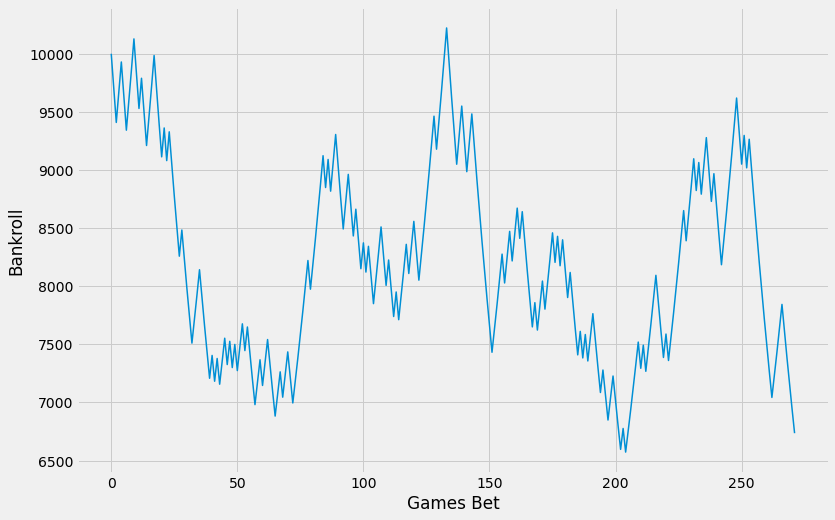

min balance: 6533.306252851266 
max balance: 10222.011509065205 
final balance: 6533.306252851266 
win percentage 50.370000000000005


,index,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,score_pred_home,score_pred_away,score_pred_diff,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,bet_home4,confidence_pred1,confidence_pred2,confidence_pred3,confidence_pred4,bankroll_i,bankroll_n,bet_size,bet_won
0,1,21800077,CLE vs. IND,7.0,3.340000,1.312500,107,119,-12,0,104.509630,111.151694,-6.642064,-5.369197,5.906010,-5.637604,1,1,1,1,0.357936,1.630803,1.093990,1.362396,10000.000000,9700.000000,300.000000,0
1,22,21800102,MEM vs. WAS,-1.5,1.833333,2.000000,107,95,12,1,108.051903,107.945631,0.106272,-0.381405,-0.890749,0.254672,0,0,0,0,-1.393728,-1.881405,-0.609251,-1.245328,9700.000000,9409.000000,291.000000,0
2,39,21800119,WAS vs. OKC,-3.5,1.588235,2.300000,111,134,-23,0,112.109542,109.918858,2.190684,1.729575,-1.679482,1.704528,0,0,0,0,-1.309316,-1.770425,-1.820518,-1.795472,9409.000000,9665.609091,282.270000,1
3,61,21800141,IND vs. HOU,-1.0,1.854701,1.869565,94,98,-4,0,108.249171,104.630718,3.618454,-0.705966,-0.004002,-0.350982,1,0,0,0,2.618454,-1.705966,-0.995998,-1.350982,9665.609091,9929.216612,289.968273,1
4,67,21800147,GSW vs. MEM,-14.0,1.062500,8.970000,117,101,16,1,110.210716,104.958062,5.252653,12.122962,-13.090175,12.606568,0,0,0,0,-8.747347,-1.877038,-0.909825,-1.393432,9929.216612,9631.340113,297.876498,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,2237,41900222,LAL vs. HOU,-6.0,1.414938,2.770000,117,109,8,1,112.169304,108.513618,3.655686,4.389760,-4.563149,4.476454,0,0,0,0,-2.344314,-1.610240,-1.436851,-1.523546,7608.067291,7379.825273,228.242019,0
268,2241,41900223,HOU vs. LAL,4.5,2.440000,1.526316,102,112,-10,0,109.317306,111.306179,-1.988873,-2.292892,3.751406,-3.022149,1,1,1,1,2.511127,2.207108,0.748594,1.477851,7379.825273,7158.430514,221.394758,0
269,2245,41900217,TOR vs. BOS,3.5,1.970874,1.606061,87,92,-5,0,108.257489,109.771168,-1.513679,-0.931357,2.273881,-1.602619,1,1,1,1,1.986321,2.568643,1.226119,1.897381,7158.430514,6943.677599,214.752915,0
270,2247,41900225,LAL vs. HOU,-6.5,1.384615,2.840000,119,96,23,1,112.169304,107.174938,4.994366,4.752667,-4.684480,4.718573,0,0,0,0,-1.505634,-1.747333,-1.815520,-1.781427,6943.677599,6735.367271,208.310328,0


In [710]:
best_lgbr_diff = lgb.LGBMRegressor(colsample_bytree=0.5597090226673742,
              feature_fraction=0.6880319327164988, max_depth=26,
              min_child_weight=1, num_leaves=2, objective='regression',
              reg_alpha=4, reg_lambda=4, subsample=0.6521226559898796,
              subsample_freq=1)
best_lgbr_score = lgb.LGBMRegressor(colsample_bytree=0.5, feature_fraction=1.0, max_depth=3,
              min_child_weight=1, num_leaves=2, objective='regression',
              reg_alpha=0, reg_lambda=1, subsample=0.6, subsample_freq=1)


best_lgbr_diff.fit(X_train2, point_diff_train2)

best_lgbr_score.fit(X_train2, team_score_train2)

diff_preds_lgbr2 = best_lgbr_diff.predict(X_test2)
score_preds_lgbr2 = best_lgbr_score.predict(X_test2)

mae_diff = mean_absolute_error(point_diff_test2, diff_preds_lgbr2)
mae_score = mean_absolute_error(team_score_test2, score_preds_lgbr2)

print("mae_diff:", mae_diff, "mae_score:", mae_score)

bets = create_betting_df(final_df_ewm_19, diff_preds_lgbr2, score_preds_lgbr2, test_idx2)
select_bets = bets.loc[abs(bets['confidence_pred2']) > 1.6]    
simulate_bets(select_bets)


#### Predicting Spread + Actual Point Diff as Proxy for Confidence of Covering

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   40.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


best svr_diff estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.006601838929857076,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])
best svr_team estimator: Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.014321013870344837,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 1.16
best prediction strat: 4
num_games_bet: 983
win percetange at threshold: 0.5310274669379451


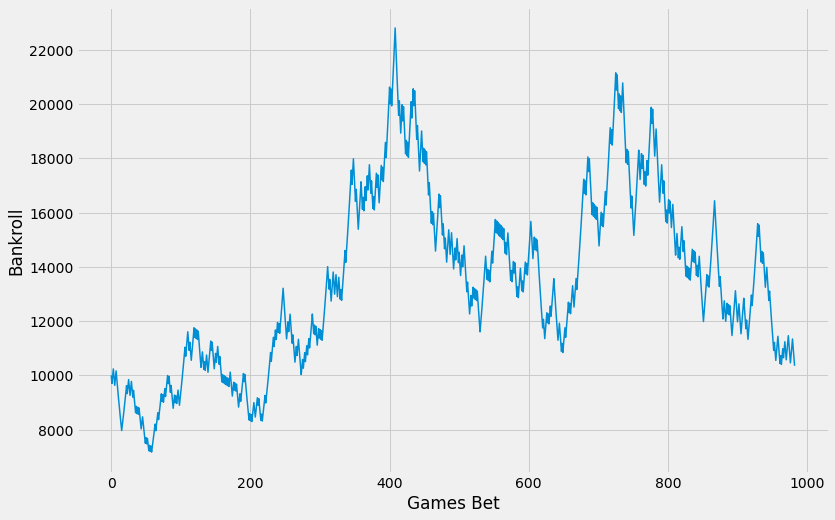

min balance: 7171.519587147694 
max balance: 22803.795529621926 
final balance: 10040.037674973175 
win percentage 53.1


,index,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,score_pred_home,score_pred_away,score_pred_diff,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,bet_home4,confidence_pred1,confidence_pred2,confidence_pred3,confidence_pred4,bankroll_i,bankroll_n,bet_size,bet_won
0,1,21600077,UTA vs. SAS,3.5,2.450000,1.571429,86,100,-14,0,90.696671,92.563810,-1.867139,-2.000300,2.090468,-2.045384,1,1,1,1,1.632861,1.499700,1.409532,1.454616,10000.000000,9700.000000,300.000000,0
1,7,21600089,TOR vs. SAC,-7.5,1.285714,3.750000,91,96,-5,0,101.907668,95.903708,6.003960,6.102244,-6.127417,6.114830,0,0,0,0,-1.496040,-1.397756,-1.372583,-1.385170,9700.000000,9964.545455,291.000000,1
2,9,21600091,BOS vs. DEN,-7.0,1.333333,3.600000,107,123,-16,0,109.463561,104.367401,5.096160,5.295047,-5.214504,5.254776,0,0,0,0,-1.903840,-1.704953,-1.785496,-1.745224,9964.545455,10236.305785,298.936364,1
3,10,21600092,LAL vs. PHX,-4.0,1.571429,2.550000,119,108,11,1,113.535266,113.006668,0.528597,1.056864,-0.911112,0.983988,0,0,0,0,-3.471403,-2.943136,-3.088888,-3.016012,10236.305785,9929.216612,307.089174,0
4,12,21600097,OKC vs. MIA,-5.5,1.425532,2.950000,97,85,12,1,102.842247,100.353113,2.489135,2.581465,-2.549775,2.565620,0,0,0,0,-3.010865,-2.918535,-2.950225,-2.934380,9929.216612,9631.340113,297.876498,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,2444,41700315,HOU vs. GSW,1.0,1.909091,1.800000,98,94,4,1,105.686031,105.169202,0.516829,0.536788,-0.260924,0.398856,1,1,1,1,1.516829,1.536788,1.260924,1.398856,11039.836641,11340.923095,331.195099,1
979,2445,41700306,CLE vs. BOS,-7.0,1.322581,3.500000,109,99,10,1,102.810904,98.067117,4.743787,4.743707,-4.726691,4.735199,0,0,0,0,-2.256213,-2.256293,-2.273309,-2.264801,11340.923095,11000.695402,340.227693,0
980,2446,41700316,GSW vs. HOU,-12.5,1.094340,6.500000,115,86,29,1,109.052987,99.075934,9.977053,9.908667,-10.068489,9.988578,0,0,0,0,-2.522947,-2.591333,-2.431511,-2.511422,11000.695402,10670.674540,330.020862,0
981,2447,41700307,BOS vs. CLE,-3.5,1.645161,2.350000,79,87,-8,0,102.553130,97.793525,4.759605,4.777349,-4.666863,4.722106,1,1,1,1,1.259605,1.277349,1.166863,1.222106,10670.674540,10350.554304,320.120236,0


In [711]:
pipeline_svr_diff = Pipeline([('scaler', StandardScaler()),
                        ('svr', LinearSVR(max_iter=10000))])


pipeline_svr_score = Pipeline([('scaler', StandardScaler()),
                        ('svr', LinearSVR(max_iter=10000))])


search_spaces = {'svr__C': Real(1e-6, 1e+6, prior='log-uniform'),
                'svr__loss' : Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive'])}


svr_bs_diff = BayesSearchCV(pipeline_svr_diff, search_spaces=search_spaces, 
                         n_jobs=-1, cv=tscv, verbose=1)
svr_bs_score = BayesSearchCV(pipeline_svr_score, search_spaces=search_spaces, 
                          n_jobs=-1, cv=tscv, verbose=1)

svr_bs_diff.fit(X_train1, point_diff_train1)
svr_bs_score.fit(X_train1, team_score_train1)

print("best svr_diff estimator:", svr_bs_diff.best_estimator_)
print("best svr_team estimator:", svr_bs_score.best_estimator_)
best_svr_diff = svr_bs_diff.best_estimator_
best_svr_score = svr_bs_score.best_estimator_


diff_preds_svr = best_svr_diff.predict(X_test1)
score_preds_svr = best_svr_score.predict(X_test1)

select_bets_svr, bet_thresholds_svr = find_optimal_confidence_thresholds(diff_preds_svr,
                                                                               score_preds_svr,
                                                                               test_idx1)
simulate_bets(select_bets_svr)



mae_diff: 9.962244469080336 mae_score: 9.172157889014805


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


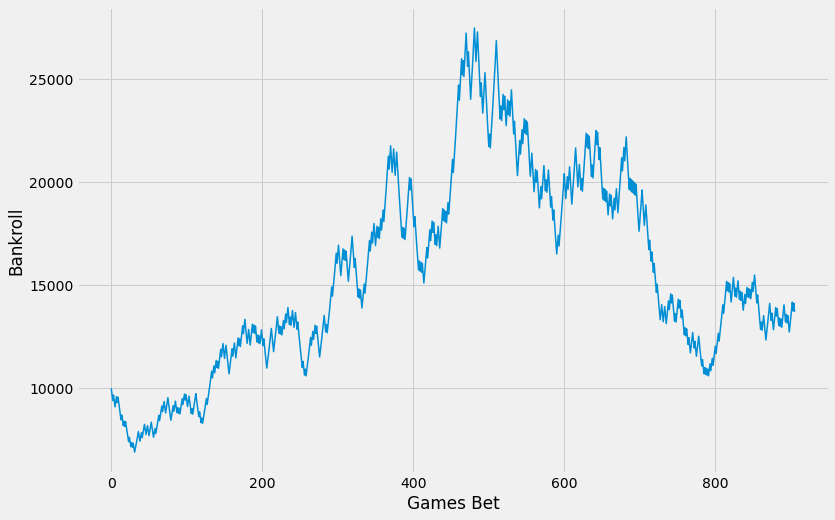

min balance: 6903.415333512278 
max balance: 27462.037140030825 
final balance: 14070.870365855932 
win percentage 53.75


,index,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,score_pred_home,score_pred_away,score_pred_diff,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,bet_home4,confidence_pred1,confidence_pred2,confidence_pred3,confidence_pred4,bankroll_i,bankroll_n,bet_size,bet_won
0,0,21800068,NYK vs. GSW,11.5,7.350000,1.090909,100,128,-28,0,112.658305,119.882277,-7.223972,-7.609299,7.056945,-7.333122,1,1,1,1,4.276028,3.890701,4.443055,4.166878,10000.000000,9700.000000,300.000000,0
1,1,21800077,CLE vs. IND,7.0,3.340000,1.312500,107,119,-12,0,105.384969,108.748321,-3.363352,-3.295301,3.115958,-3.205630,1,1,1,1,3.636648,3.704699,3.884042,3.794370,9700.000000,9409.000000,291.000000,0
2,4,21800083,BKN vs. GSW,9.5,4.970000,1.166667,114,120,-6,1,112.634135,117.952123,-5.317988,-5.649567,5.603812,-5.626690,1,1,1,1,4.182012,3.850433,3.896188,3.873310,9409.000000,9665.609091,282.270000,1
3,5,21800084,DAL vs. UTA,4.5,2.700000,1.500000,104,113,-9,0,111.447421,114.652107,-3.204687,-3.192505,3.227522,-3.210014,1,1,1,1,1.295313,1.307495,1.272478,1.289986,9665.609091,9375.640818,289.968273,0
4,6,21800086,LAC vs. WAS,-3.5,1.645161,2.350000,136,104,32,1,119.563205,120.081050,-0.517845,-0.394403,0.421619,-0.408011,0,0,0,0,-4.017845,-3.894403,-3.921619,-3.908011,9375.640818,9094.371594,281.269225,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,2251,41900302,BOS vs. MIA,-3.0,1.625000,2.230000,101,106,-5,0,107.555281,106.077539,1.477742,1.525515,-1.430781,1.478148,0,0,0,0,-1.522258,-1.474485,-1.569219,-1.521852,13794.952786,14171.178771,413.848584,1
902,2253,41900303,MIA vs. BOS,3.5,2.500000,1.588235,106,117,-11,0,105.363645,106.781603,-1.417958,-1.304101,1.372620,-1.338361,1,1,1,1,2.082042,2.195899,2.127380,2.161639,14171.178771,13746.043408,425.135363,0
903,2256,41900304,MIA vs. BOS,3.5,2.380000,1.588235,112,109,3,1,106.716727,107.663443,-0.946715,-0.879069,0.926014,-0.902542,1,1,1,1,2.553285,2.620931,2.573986,2.597458,13746.043408,14120.935501,412.381302,1
904,2258,41900305,BOS vs. MIA,-3.5,1.591716,2.350000,121,108,13,1,107.929847,106.034339,1.895508,1.936209,-1.890358,1.913283,0,0,0,0,-1.604492,-1.563791,-1.609642,-1.586717,14120.935501,13697.307436,423.628065,0


In [714]:
best_svr_diff = Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.006601838929857076,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])
best_svr_score = Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.014321013870344837,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])


best_svr_diff.fit(X_train2, point_diff_train2)

best_svr_score.fit(X_train2, team_score_train2)

diff_preds_svr2 = best_svr_diff.predict(X_test2)
score_preds_svr2 = best_svr_score.predict(X_test2)

mae_diff = mean_absolute_error(point_diff_test2, diff_preds_svr2)
mae_score = mean_absolute_error(team_score_test2, score_preds_svr2)

print("mae_diff:", mae_diff, "mae_score:", mae_score)

bets = create_betting_df(final_df_ewm_19, diff_preds_svr2, score_preds_svr2, test_idx2)
select_bets = bets.loc[abs(bets['confidence_pred4']) > 1.16]    
simulate_bets(select_bets)


### XGB

#### Predicting Spread + Actual Point Diff as Proxy for Confidence of Covering

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   39.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   24.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.4min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.5min finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.3s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.7s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   34.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.5s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.8s finished
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.4s finished


best_xgbr_diff: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=20, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)
best_xgbr_score: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=3.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=100, n

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 2.61
best prediction strat: 1
num_games_bet: 1088
win percetange at threshold: 0.5349264705882353


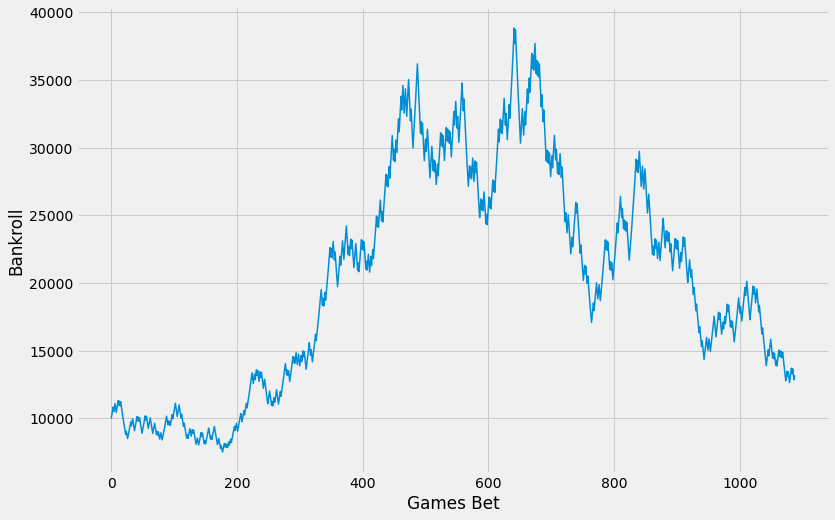

min balance: 7515.278969553065 
max balance: 38849.5884162895 
final balance: 12811.762639150664 
win percentage 53.49


,index,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,score_pred_home,score_pred_away,score_pred_diff,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,bet_home4,confidence_pred1,confidence_pred2,confidence_pred3,confidence_pred4,bankroll_i,bankroll_n,bet_size,bet_won
0,2,21600078,LAL vs. GSW,11.5,6.500000,1.111111,117,97,20,1,107.361656,116.079781,-8.718124,-9.798532,8.645798,-9.222165,1,1,1,1,2.781876,1.701468,2.854202,2.277835,10000.000000,10272.727273,300.000000,1
1,3,21600083,IND vs. CHI,-3.5,1.606061,2.400000,111,94,17,1,107.118332,100.531326,6.587006,2.009785,-5.481205,3.745495,1,0,1,1,3.087006,-1.490215,1.981205,0.245495,10272.727273,10552.892562,308.181818,1
2,4,21600084,ATL vs. HOU,-3.0,1.645161,2.350000,112,97,15,1,106.824265,99.879173,6.945091,-0.340180,-2.166210,0.913015,1,0,0,0,3.945091,-3.340180,-0.833790,-2.086985,10552.892562,10840.698723,316.586777,1
3,6,21600086,SAS vs. LAC,-4.5,1.512821,2.700000,92,116,-24,0,106.585991,95.639381,10.946609,2.046210,-2.272624,2.159417,1,0,0,0,6.446609,-2.453790,-2.227376,-2.340583,10840.698723,10515.477761,325.220962,0
4,7,21600089,TOR vs. SAC,-7.5,1.285714,3.750000,91,96,-5,0,99.655006,95.224358,4.430649,9.257257,-10.848095,10.052676,0,1,1,1,-3.069351,1.757257,3.348095,2.552676,10515.477761,10802.263518,315.464333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1083,2440,41700313,GSW vs. HOU,-7.5,1.250000,3.850000,126,85,41,1,109.929276,98.411842,11.517433,9.068573,-5.732953,7.400763,1,1,0,0,4.017433,1.568573,-1.767047,-0.099237,13302.159916,13664.946096,399.064797,1
1084,2442,41700314,GSW vs. HOU,-7.5,1.232558,4.400000,92,95,-3,0,109.233299,97.857323,11.375977,8.138866,-8.840408,8.489637,1,1,1,1,3.875977,0.638866,1.340408,0.989637,13664.946096,13254.997713,409.948383,0
1085,2445,41700306,CLE vs. BOS,-7.0,1.322581,3.500000,109,99,10,1,104.055885,100.143997,3.911888,2.992990,-5.631266,4.312128,0,0,0,0,-3.088112,-4.007010,-1.368734,-2.687872,13254.997713,12857.347781,397.649931,0
1086,2446,41700316,GSW vs. HOU,-12.5,1.094340,6.500000,115,86,29,1,109.346764,94.209976,15.136787,12.175041,-14.340611,13.257826,1,0,1,1,2.636787,-0.324959,1.840611,0.757826,12857.347781,13208.002721,385.720433,1


In [715]:
search_spaces = {'min_child_weight':Integer(1,8),
              'gamma': Real(0.5, 3),
              'subsample': Real(0.6, 1),
              'colsample_bytree': Real(0.5, 1),
              'max_depth': Integer(3, 30),
              'reg_lambda': Integer(1, 20),
              'reg_alpha': Integer(0, 20)}
    
    
xgbr_bs_diff = BayesSearchCV(xgb.XGBRegressor(), search_spaces=search_spaces,
                        cv=tscv, verbose=1, n_jobs=-1)

xgbr_bs_score = BayesSearchCV(xgb.XGBRegressor(), search_spaces=search_spaces,
                        cv=tscv, verbose=1, n_jobs=-1)

xgbr_bs_diff.fit(X_train1, point_diff_train1)
xgbr_bs_score.fit(X_train1, team_score_train1)

best_xgbr_diff = xgbr_bs_diff.best_estimator_
best_xgbr_score = xgbr_bs_score.best_estimator_

print("best_xgbr_diff:", best_xgbr_diff)
print("best_xgbr_score:", best_xgbr_score)

diff_preds_xgbr = best_xgbr_diff.predict(X_test1)
score_preds_xgbr = best_xgbr_score.predict(X_test1)

select_bets_xgbr, bet_thresholds_xgbr = find_optimal_confidence_thresholds(diff_preds_xgbr,
                                                                               score_preds_xgbr,
                                                                               test_idx1)
simulate_bets(select_bets_xgbr)


mae_diff: 10.163025175717943 mae_score: 9.196337783604822


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


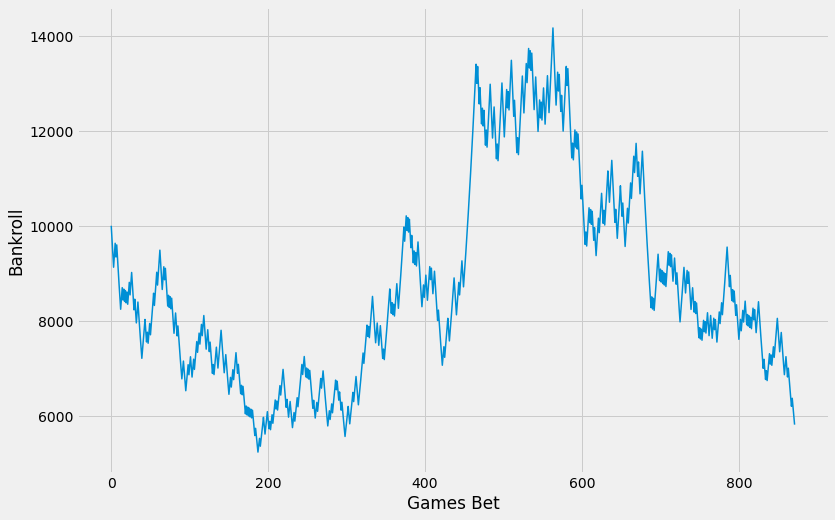

min balance: 5232.972168735946 
max balance: 14166.53796668156 
final balance: 5969.242231978827 
win percentage 52.059999999999995


,index,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,score_pred_home,score_pred_away,score_pred_diff,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,bet_home4,confidence_pred1,confidence_pred2,confidence_pred3,confidence_pred4,bankroll_i,bankroll_n,bet_size,bet_won
0,0,21800068,NYK vs. GSW,11.5,7.350000,1.090909,100,128,-28,0,108.862350,117.319794,-8.457443,-8.079571,10.751390,-9.415480,1,1,1,1,3.042557,3.420429,0.748610,2.084520,10000.000000,9700.000000,300.000000,0
1,1,21800077,CLE vs. IND,7.0,3.340000,1.312500,107,119,-12,0,106.511017,107.099907,-0.588890,-6.314145,4.739106,-5.526626,1,1,1,1,6.411110,0.685855,2.260894,1.473374,9700.000000,9409.000000,291.000000,0
2,2,21800078,PHI vs. CHA,-7.0,1.285714,3.300000,105,103,2,0,120.236588,108.890572,11.346016,10.998697,-11.176173,11.087435,1,1,1,1,4.346016,3.998697,4.176173,4.087435,9409.000000,9126.730000,282.270000,0
3,7,21800087,IND vs. POR,-4.0,1.588235,2.500000,93,103,-10,0,115.190414,107.720146,7.470268,2.910228,-1.562669,2.236449,1,0,0,0,3.470268,-1.089772,-2.437331,-1.763551,9126.730000,9375.640818,273.801900,1
4,8,21800088,PHI vs. ATL,-11.5,1.100000,7.000000,113,92,21,1,120.321350,112.688431,7.632919,11.561624,-15.182402,13.372013,0,1,1,1,-3.867081,0.061624,3.682402,1.872013,9375.640818,9631.340113,281.269225,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
867,2260,41900306,MIA vs. BOS,3.0,2.200000,1.714286,125,113,12,1,109.495087,109.057266,0.437820,-3.151948,1.906381,-2.529165,1,0,1,1,3.437820,-0.151948,1.093619,0.470835,6197.727587,6366.756521,185.931828,1
868,2263,41900403,MIA vs. LAL,9.5,4.300000,1.210526,115,104,11,1,107.467827,113.938263,-6.470436,-10.388289,11.429064,-10.908676,1,0,0,0,3.029564,-0.888289,-1.929064,-1.408676,6366.756521,6175.753826,191.002696,0
869,2264,41900404,MIA vs. LAL,7.5,3.520000,1.273973,96,102,-6,1,108.565666,110.851448,-2.285782,-8.397046,9.012600,-8.704823,1,0,0,0,5.214218,-0.897046,-1.512600,-1.204823,6175.753826,5990.481211,185.272615,0
870,2265,41900405,LAL vs. MIA,-7.5,1.289855,3.070000,108,111,-3,0,109.223969,106.126022,3.097946,10.233006,-10.658972,10.445990,0,1,1,1,-4.402054,2.733006,3.158972,2.945990,5990.481211,5810.766774,179.714436,0


In [716]:
best_xgbr_diff = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=20, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)
best_xgbr_score =  xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=3.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=6, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=7, reg_lambda=20, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)


best_xgbr_diff.fit(X_train2, point_diff_train2)

best_xgbr_score.fit(X_train2, team_score_train2)

diff_preds_xgbr2 = best_xgbr_diff.predict(X_test2)
score_preds_xgbr2 = best_xgbr_score.predict(X_test2)

mae_diff = mean_absolute_error(point_diff_test2, diff_preds_xgbr2)
mae_score = mean_absolute_error(team_score_test2, score_preds_xgbr2)

print("mae_diff:", mae_diff, "mae_score:", mae_score)

bets = create_betting_df(final_df_ewm_19, diff_preds_xgbr2, score_preds_xgbr2, test_idx2)
select_bets = bets.loc[abs(bets['confidence_pred1']) > 2.6]    
simulate_bets(select_bets)


### Stacked Regressor for Spread + Actual Point Diff

[LightGBM] [Warning] feature_fraction is set=0.6880319327164988, colsample_bytree=0.5597090226673742 will be ignored. Current value: feature_fraction=0.6880319327164988
[LightGBM] [Warning] feature_fraction is set=0.6880319327164988, colsample_bytree=0.5597090226673742 will be ignored. Current value: feature_fraction=0.6880319327164988
[LightGBM] [Warning] feature_fraction is set=0.6880319327164988, colsample_bytree=0.5597090226673742 will be ignored. Current value: feature_fraction=0.6880319327164988
[LightGBM] [Warning] feature_fraction is set=0.6880319327164988, colsample_bytree=0.5597090226673742 will be ignored. Current value: feature_fraction=0.6880319327164988
[LightGBM] [Warning] feature_fraction is set=0.6880319327164988, colsample_bytree=0.5597090226673742 will be ignored. Current value: feature_fraction=0.6880319327164988
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fr

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


DONE
best threshold: 2.57
best prediction strat: 1
num_games_bet: 139
win percetange at threshold: 0.5467625899280576


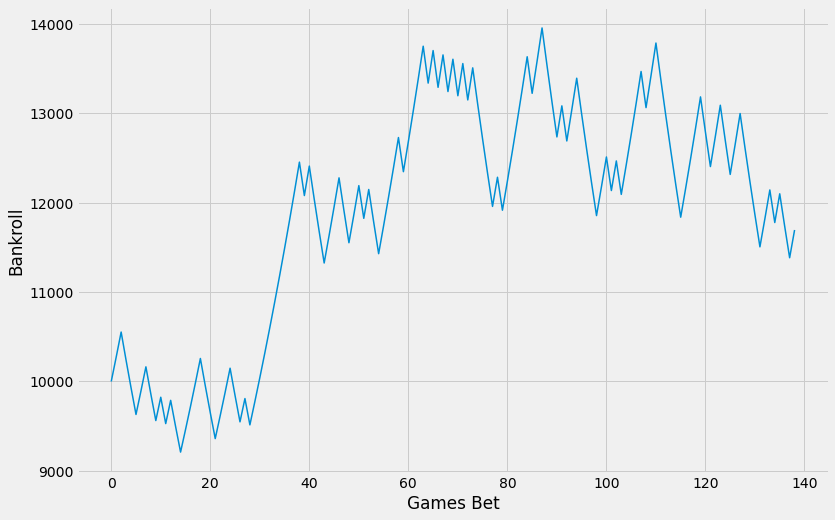

min balance: 9210.61064663862 
max balance: 13953.081540945755 
final balance: 11343.234006175604 
win percentage 54.67999999999999


,index,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,score_pred_home,score_pred_away,score_pred_diff,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,bet_home4,confidence_pred1,confidence_pred2,confidence_pred3,confidence_pred4,bankroll_i,bankroll_n,bet_size,bet_won
0,14,21600099,GSW vs. NOP,-16.5,1.020000,14.000000,116,106,10,0,115.665373,103.116328,12.549045,12.510002,-12.202783,12.356392,0,0,0,0,-3.950955,-3.989998,-4.297217,-4.143608,10000.000000,10272.727273,300.000000,1
1,18,21600104,LAL vs. DAL,-4.0,1.571429,2.550000,97,109,-12,0,103.015213,102.394952,0.620261,0.372338,-0.288476,0.330407,0,0,0,0,-3.379739,-3.627662,-3.711524,-3.669593,10272.727273,10552.892562,308.181818,1
2,19,21600105,SAC vs. NOP,-6.5,1.377358,3.250000,102,94,8,1,104.175348,100.462020,3.713329,3.660422,-4.268501,3.964462,0,0,0,0,-2.786671,-2.839578,-2.231499,-2.535538,10552.892562,10236.305785,316.586777,0
3,30,21600116,GSW vs. DAL,-18.5,1.011111,16.000000,116,95,21,1,110.595714,96.194194,14.401520,13.589561,-14.765019,14.177290,0,0,0,0,-4.098480,-4.910439,-3.734981,-4.322710,10236.305785,9929.216612,307.089174,0
4,60,21600146,NYK vs. DAL,-4.5,1.571429,2.550000,93,77,16,1,99.729873,97.849858,1.880015,2.157346,-2.468437,2.312892,0,0,0,0,-2.619985,-2.342654,-2.031563,-2.187108,9929.216612,9631.340113,297.876498,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,2421,41700222,HOU vs. UTA,-10.5,1.111111,6.500000,108,116,-8,0,106.493511,100.051044,6.442467,9.468062,-9.292918,9.380490,0,0,0,0,-4.057533,-1.031938,-1.207082,-1.119510,11777.420248,12098.622618,353.322607,1
135,2424,41700223,UTA vs. HOU,4.5,2.700000,1.500000,92,113,-21,0,103.629041,104.481146,-0.852105,-3.323558,3.121235,-3.222397,1,1,1,1,3.647895,1.176442,1.378765,1.277603,12098.622618,11735.663940,362.958679,0
136,2428,41700224,UTA vs. HOU,6.0,3.250000,1.363636,87,100,-13,0,101.991785,104.912933,-2.921148,-5.310337,5.240554,-5.275445,1,1,1,1,3.078852,0.689663,0.759446,0.724555,11735.663940,11383.594021,352.069918,0
137,2432,41700225,HOU vs. UTA,-12.0,1.105263,8.000000,112,102,10,0,106.434323,97.129343,9.304981,11.033306,-10.985288,11.009297,0,0,0,0,-2.695019,-0.966694,-1.014712,-0.990703,11383.594021,11694.055676,341.507821,1


In [718]:
best_sgd_diff= Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.007847599703514606, epsilon=1.27427,
                              l1_ratio=1.0, loss='huber', max_iter=5000,
                              penalty='elasticnet'))])
best_sgd_score= Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.007847599703514606, epsilon=0.379269,
                              l1_ratio=0.05, loss='huber', max_iter=5000,
                              penalty='elasticnet'))])

best_en_diff= Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.0379269019073225, max_iter=10000))])
best_en_score= Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.0379269019073225, max_iter=10000))])

best_lgbr_diff = lgb.LGBMRegressor(colsample_bytree=0.5597090226673742,
              feature_fraction=0.6880319327164988, max_depth=26,
              min_child_weight=1, num_leaves=2, objective='regression',
              reg_alpha=4, reg_lambda=4, subsample=0.6521226559898796,
              subsample_freq=1)
best_lgbr_score = lgb.LGBMRegressor(colsample_bytree=0.5, feature_fraction=1.0, max_depth=3,
              min_child_weight=1, num_leaves=2, objective='regression',
              reg_alpha=0, reg_lambda=1, subsample=0.6, subsample_freq=1)


best_svr_diff = Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.006601838929857076,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])
best_svr_score = Pipeline(steps=[('scaler', StandardScaler()),
                ('svr',
                 LinearSVR(C=0.014321013870344837,
                           loss='squared_epsilon_insensitive',
                           max_iter=10000))])


best_xgbr_diff = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=20, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)
best_xgbr_score =  xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=3.0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=6, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=7, reg_lambda=20, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)



estimators_diff = [('sgd', best_sgd_diff), ('en', best_en_diff),
              ('lgbr', best_lgbr_diff), ('svr', best_svr_diff),
              ('xgbr', best_xgbr_diff)]


estimators_score = [('sgd', best_sgd_score), ('en', best_en_score),
              ('lgbr', best_lgbr_score), ('svr', best_svr_score),
              ('xgbr', best_xgbr_score)]


stacked_reg_diff = StackingRegressor(estimators = estimators_diff, final_estimator = LinearRegression())
stacked_reg_score = StackingRegressor(estimators = estimators_score, final_estimator = LinearRegression())

stacked_reg_diff.fit(X_train1, point_diff_train1)
stacked_reg_score.fit(X_train1, team_score_train1)


preds_diff_stacked = stacked_reg_diff.predict(X_test1)
preds_score_stacked = stacked_reg_score.predict(X_test1)

mae_diff = mean_absolute_error(point_diff_test1, preds_diff_stacked)
mae_score = mean_absolute_error(team_score_test1, preds_score_stacked)

print("mae_diff:", mae_diff, "mae_score:", mae_score)


select_bets_stacked, bet_thresholds_stacked = find_optimal_confidence_thresholds(preds_diff_stacked,
                                                                               preds_score_stacked,
                                                                               test_idx1)
simulate_bets(select_bets_stacked)





mae_diff: 9.95435759572954 mae_score: 9.106632707557498


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


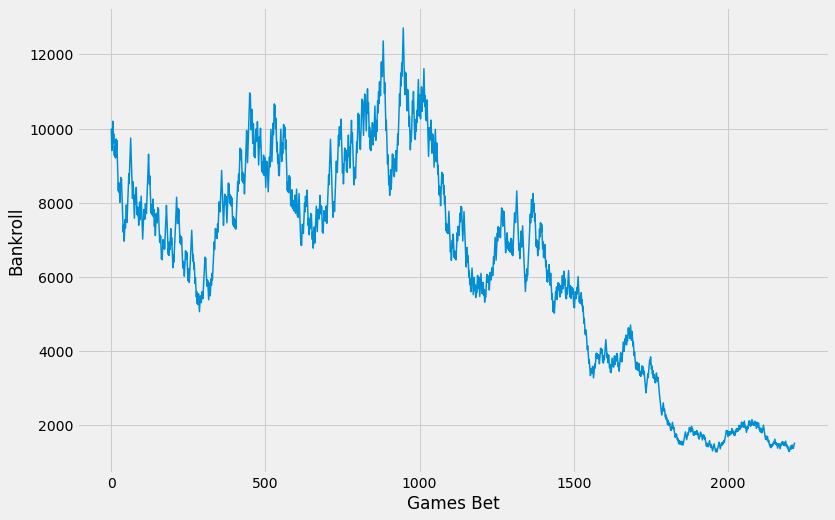

min balance: 1282.6504748420416 
max balance: 12712.839030995538 
final balance: 1494.783831831415 
win percentage 51.6


,index,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,score_pred_home,score_pred_away,score_pred_diff,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,bet_home4,confidence_pred1,confidence_pred2,confidence_pred3,confidence_pred4,bankroll_i,bankroll_n,bet_size,bet_won
0,0,21800068,NYK vs. GSW,11.5,7.350000,1.090909,100,128,-28,0,110.684873,118.902562,-8.217689,-8.749049,9.116440,-8.932745,1,1,1,1,3.282311,2.750951,2.383560,2.567255,10000.000000,9700.000000,300.000000,0
1,1,21800077,CLE vs. IND,7.0,3.340000,1.312500,107,119,-12,0,105.087605,108.252117,-3.164512,-4.494698,4.857464,-4.676081,1,1,1,1,3.835488,2.505302,2.142536,2.323919,9700.000000,9409.000000,291.000000,0
2,2,21800078,PHI vs. CHA,-7.0,1.285714,3.300000,105,103,2,0,117.215340,110.007787,7.207553,7.108554,-6.884928,6.996741,1,1,0,0,0.207553,0.108554,-0.115072,-0.003259,9409.000000,9665.609091,282.270000,1
3,3,21800081,MIL vs. ORL,-9.0,1.204082,4.450000,113,91,22,1,117.282024,107.344085,9.937939,9.728579,-9.883397,9.805988,1,1,1,1,0.937939,0.728579,0.883397,0.805988,9665.609091,9929.216612,289.968273,1
4,4,21800083,BKN vs. GSW,9.5,4.970000,1.166667,114,120,-6,1,110.609983,117.683764,-7.073781,-6.980316,7.147828,-7.064072,1,1,1,1,2.426219,2.519684,2.352172,2.435928,9929.216612,10200.013428,297.876498,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212,2262,41900402,LAL vs. MIA,-11.0,1.157480,4.930000,124,114,10,0,112.569899,102.860998,9.708902,10.701845,-10.594167,10.648006,0,0,0,0,-1.291098,-0.298155,-0.405833,-0.351994,1383.769086,1421.508243,41.513073,1
2213,2263,41900403,MIA vs. LAL,9.5,4.300000,1.210526,115,104,11,1,104.373292,111.834229,-7.460937,-8.584675,9.214850,-8.899762,1,1,1,1,2.039063,0.915325,0.285150,0.600238,1421.508243,1460.276650,42.645247,1
2214,2264,41900404,MIA vs. LAL,7.5,3.520000,1.273973,96,102,-6,1,105.189925,111.026675,-5.836750,-6.116125,6.801795,-6.458960,1,1,1,1,1.663250,1.383875,0.698205,1.041040,1460.276650,1500.102377,43.808299,1
2215,2265,41900405,LAL vs. MIA,-7.5,1.289855,3.070000,108,111,-3,0,110.494492,103.221646,7.272846,7.281286,-5.770666,6.525976,0,0,0,0,-0.227154,-0.218714,-1.729334,-0.974024,1500.102377,1541.014260,45.003071,1


In [728]:


diff_preds_stacked2 = stacked_reg_diff.predict(X_test2)
score_preds_stacked2 = stacked_reg_score.predict(X_test2)

mae_diff = mean_absolute_error(point_diff_test2, diff_preds_stacked2)
mae_score = mean_absolute_error(team_score_test2, score_preds_stacked2)

print("mae_diff:", mae_diff, "mae_score:", mae_score)

bets = create_betting_df(final_df_ewm_19, diff_preds_stacked2, score_preds_stacked2, test_idx2)
select_bets = bets.loc[abs(bets['confidence_pred3']) > 0]    
simulate_bets(select_bets)

In [726]:
bets

,GAME_ID,MATCHUP_home,spread_home,ml_home,ml_away,team_score_home,team_score_away,point_diff_home,cover_home,score_pred_home,score_pred_away,score_pred_diff,diff_preds_home,diff_preds_away,point_diff_avg,bet_home1,bet_home2,bet_home3,bet_home4,confidence_pred1,confidence_pred2,confidence_pred3,confidence_pred4,bankroll_i,bankroll_n,bet_size,bet_won
0,21800068,NYK vs. GSW,11.5,7.350000,1.090909,100,128,-28,0,110.684873,118.902562,-8.217689,-8.749049,9.116440,-8.932745,1,1,1,1,3.282311,2.750951,2.383560,2.567255,10000.0,NaN,NaN,0
1,21800077,CLE vs. IND,7.0,3.340000,1.312500,107,119,-12,0,105.087605,108.252117,-3.164512,-4.494698,4.857464,-4.676081,1,1,1,1,3.835488,2.505302,2.142536,2.323919,NaN,NaN,NaN,0
2,21800078,PHI vs. CHA,-7.0,1.285714,3.300000,105,103,2,0,117.215340,110.007787,7.207553,7.108554,-6.884928,6.996741,1,1,0,0,0.207553,0.108554,-0.115072,-0.003259,NaN,NaN,NaN,1
3,21800081,MIL vs. ORL,-9.0,1.204082,4.450000,113,91,22,1,117.282024,107.344085,9.937939,9.728579,-9.883397,9.805988,1,1,1,1,0.937939,0.728579,0.883397,0.805988,NaN,NaN,NaN,1
4,21800083,BKN vs. GSW,9.5,4.970000,1.166667,114,120,-6,1,110.609983,117.683764,-7.073781,-6.980316,7.147828,-7.064072,1,1,1,1,2.426219,2.519684,2.352172,2.435928,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,41900402,LAL vs. MIA,-11.0,1.157480,4.930000,124,114,10,0,112.569899,102.860998,9.708902,10.701845,-10.594167,10.648006,0,0,0,0,-1.291098,-0.298155,-0.405833,-0.351994,NaN,NaN,NaN,1
2263,41900403,MIA vs. LAL,9.5,4.300000,1.210526,115,104,11,1,104.373292,111.834229,-7.460937,-8.584675,9.214850,-8.899762,1,1,1,1,2.039063,0.915325,0.285150,0.600238,NaN,NaN,NaN,1
2264,41900404,MIA vs. LAL,7.5,3.520000,1.273973,96,102,-6,1,105.189925,111.026675,-5.836750,-6.116125,6.801795,-6.458960,1,1,1,1,1.663250,1.383875,0.698205,1.041040,NaN,NaN,NaN,1
2265,41900405,LAL vs. MIA,-7.5,1.289855,3.070000,108,111,-3,0,110.494492,103.221646,7.272846,7.281286,-5.770666,6.525976,0,0,0,0,-0.227154,-0.218714,-1.729334,-0.974024,NaN,NaN,NaN,1


#### Stacked EWM 

In [700]:
lasso_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.0727895384398315, max_iter=20000))])

en_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.11721022975334805, max_iter=10000))])

ridge_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=100.0, max_iter=10000))])

sgd_pipe = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(alpha=0.0008858667904100823,
                              epsilon=0.19144819761699575, l1_ratio=0.25,
                              loss='huber', penalty='elasticnet'))])

xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=10, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

linear_svr = Pipeline(steps=[('scaler', StandardScaler()),
                    ('svr',
                     LinearSVR(C=0.00018877550822240589,
                               loss='squared_epsilon_insensitive',
                               max_iter=10000))])


rf = RandomForestRegressor(max_depth=27, max_features=0.7932417217142294,
                      min_samples_leaf=0.1, min_samples_split=0.1)


lgbr = lgb.LGBMRegressor(feature_fraction=1.0, max_depth=3, min_child_weight=8,
              num_leaves=2, objective='regression', reg_alpha=10, reg_lambda=10,
              subsample=0.6, subsample_freq=1)

estimators = [('lasso', lasso_pipe), ('en', en_pipe),
              ('sgd', sgd_pipe), ('xgbr', xgbr),
              ('svr', linear_svr), ('rf', rf),
              ('lgbr', lgbr), ('ridge', ridge_pipe)]

stacked_reg = StackingRegressor(estimators = estimators, final_estimator = LinearRegression())

stacked_reg.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

stacked_preds = stacked_reg.predict(X_test_ewm_19)




[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 3.5
num_games_bet: 16
win percetange at threshold: 0.625


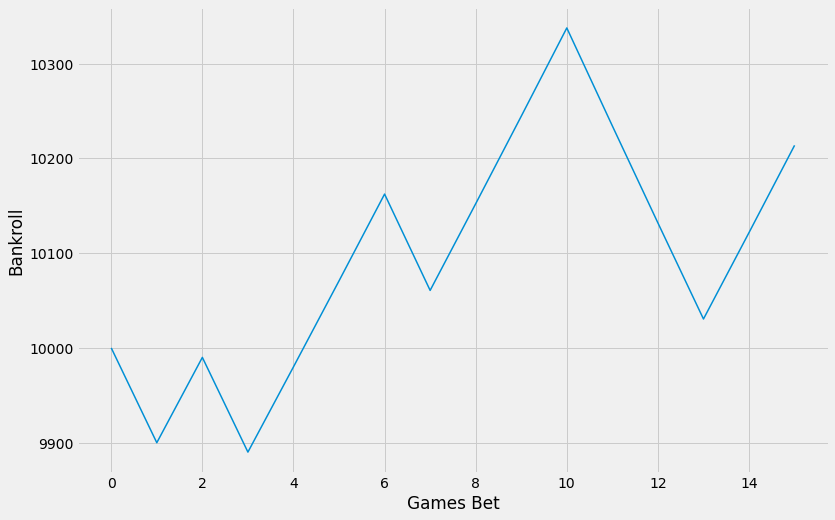

min balance: 9890.1 
max balance: 10337.550382235911 
final balance: 10306.568733402799 
win percentage 62.5


,index,GAME_DATE,spread,point_diff_team,confidence_preds,home_cover,bet_home,bet_won,bankroll_i,bankroll_n,bet_size
0,11786,2016-11-07,-7.0,32,-4.136365,1.0,0,0,10000.000000,9900.000000,100.000000
1,11792,2016-11-08,-4.0,-12,-3.719210,0.0,0,1,9900.000000,9990.000000,99.000000
2,12248,2017-01-08,-9.5,12,-3.615359,1.0,0,0,9990.000000,9890.100000,99.900000
3,13014,2017-10-30,-4.0,14,3.835894,1.0,1,1,9890.100000,9980.010000,98.901000
4,13314,2017-12-12,-5.0,-6,-3.808488,0.0,0,1,9980.010000,10070.737364,99.800100
5,13859,2018-03-04,3.5,-17,-4.117492,0.0,0,1,10070.737364,10162.289521,100.707374
6,14227,2018-10-26,11.5,-28,4.051480,0.0,1,0,10162.289521,10060.666626,101.622895
7,14233,2018-10-28,9.5,-6,3.847959,1.0,1,1,10060.666626,10152.127232,100.606666
8,14610,2018-12-19,2.0,5,3.590901,1.0,1,1,10152.127232,10244.419298,101.521272
9,15412,2019-04-23,-4.5,3,-3.666035,0.0,0,1,10244.419298,10337.550382,102.444193


In [701]:
select_bets_stacked, best_thresholds_stacked = find_optimal_confidence_thresholds(stacked_preds, test_indices)
simulate_bets(select_bets_stacked)

#### All Models Voting EWM

In [675]:
lasso_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.0727895384398315, max_iter=20000))])

en_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('en', ElasticNet(alpha=0.11721022975334805, max_iter=10000))])


ridge_pipe = Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=100.0, max_iter=10000))])

sgd_pipe = Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor',
                 SGDRegressor(epsilon=0.257191, l1_ratio=1.0, loss='huber',
                              penalty='elasticnet'))])


xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=3,
             min_child_weight=8, n_estimators=100, n_jobs=0, num_parallel_tree=1,
                    random_state=0, reg_alpha=10, reg_lambda=10)

linear_svr = Pipeline(steps=[('scaler', StandardScaler()),
                ('svr', LinearSVR(C=0.000307628104,
                loss='squared_epsilon_insensitive',
                max_iter=10000))])




rf = RandomForestRegressor(max_depth=27, max_features=0.7932417217142294,
                      min_samples_leaf=0.1, min_samples_split=0.1)


lgbr = lgb.LGBMRegressor(colsample_bytree=0.8678435885410023, feature_fraction=0.01,
              max_depth=25, min_child_weight=7, num_leaves=2,
              objective='regression', reg_alpha=20, reg_lambda=13,
              subsample_freq=1)

lasso_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
en_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
ridge_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
sgd_pipe.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
xgbr.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
linear_svr.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
rf.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)
lgbr.fit(X_train_ewm_19, spread_point_diff_train_ewm_19)

lasso_preds = lasso_pipe.predict(X_test_ewm_19)
en_preds = en_pipe.predict(X_test_ewm_19)
ridge_preds = ridge_pipe.predict(X_test_ewm_19)
sgd_preds = sgd_pipe.predict(X_test_ewm_19)
xgbr_preds = xgbr.predict(X_test_ewm_19)
svr_preds = linear_svr.predict(X_test_ewm_19)
rf_preds = rf.predict(X_test_ewm_19)
lgbr_preds = lgbr.predict(X_test_ewm_19)




[LightGBM] [Warning] feature_fraction is set=0.01, colsample_bytree=0.8678435885410023 will be ignored. Current value: feature_fraction=0.01


In [698]:
betting_df = final_df_spread[['GAME_DATE', 'HOME_GAME', 'home_spread_mode', 'point_diff_team']].iloc[cutoff_16:]
betting_df.rename(columns={'home_spread_mode':'spread'}, inplace=True)
betting_df['lasso_preds'] = lasso_preds
betting_df['en_preds'] = en_preds
betting_df['ridge_preds'] = ridge_preds
betting_df['sgd_preds'] = sgd_preds
betting_df['xgbr_preds'] = xgbr_preds
betting_df['svr_preds'] = svr_preds
betting_df['rf_preds'] = rf_preds
betting_df['lgbr_preds'] = lgbr_preds


betting_df['home_cover'] = (betting_df['point_diff_team'] + betting_df['spread'] > 0).astype(int)

betting_df['bet_home_lasso'] = np.select([betting_df['lasso_preds']>1.6, betting_df['lasso_preds'] <-1.6], [1, -1], 0)
betting_df['bet_home_en'] = np.select([betting_df['en_preds']>1.5, betting_df['en_preds'] <-1.5], [1, -1], 0)
betting_df['bet_home_ridge'] = np.select([betting_df['ridge_preds']>2.5, betting_df['ridge_preds'] <-2.5], [1, -1], 0)
betting_df['bet_home_sgd'] = np.select([betting_df['sgd_preds']>1.3, betting_df['sgd_preds'] <-1.3], [1, -1], 0)
betting_df['bet_home_xgbr'] = np.select([betting_df['xgbr_preds']>2.4, betting_df['xgbr_preds'] <-2.4], [1, -1], 0)
betting_df['bet_home_svr'] = np.select([betting_df['svr_preds']>1.9, betting_df['svr_preds'] <-1.9], [1, -1], 0)
betting_df['bet_home_rf'] = np.select([betting_df['rf_preds']>1.3, betting_df['rf_preds'] <-1.3], [1, -1], 0)
betting_df['bet_home_lgbr'] = np.select([betting_df['lgbr_preds']>0.6, betting_df['lgbr_preds'] <-0.6], [1, -1], 0)

betting_df['bet_consensus'] = (betting_df.iloc[:, 15:22] > 0).sum(axis=1)
betting_df['bet_home'] = (betting_df['bet_consensus'] > 0).astype(int)

betting_df.loc[betting_df['spread'] + betting_df['point_diff_team'] == 0, 'home_cover'] = 0.5
betting_df = betting_df.loc[betting_df['home_cover'] != 0.5]
betting_df['bet_won'] = (betting_df['bet_home'] == betting_df['home_cover']).astype(int)


select_bets = betting_df.loc[((abs(betting_df['lasso_preds']) > 1.6) 
                            | (abs(betting_df['en_preds']) > 1.5)
                             |(abs(betting_df['ridge_preds']) > 2.5)
                            | (abs(betting_df['sgd_preds']) > 1.3) 
                            | (abs(betting_df['xgbr_preds']) > 2.4) 
                             | (abs(betting_df['svr_preds']) > 1.9) 
                             | (abs(betting_df['rf_preds']) > 1.3) 
                             | (abs(betting_df['lgbr_preds']) > 0.6))]

select_bets = select_bets.loc[select_bets['bet_consensus'] != 0]

# hf = select_bets.loc[((select_bets['bet_home'] == 1) & (select_bets['spread'] < 0)), 'bet_won'].mean()
# hd = select_bets.loc[((select_bets['bet_home'] == 1) & (select_bets['spread'] > 0)), 'bet_won'].mean()
# af = select_bets.loc[((select_bets['bet_home'] == 0) & (select_bets['spread'] > 0)), 'bet_won'].mean()
# ad = select_bets.loc[((select_bets['bet_home'] == 0) & (select_bets['spread'] < 0)), 'bet_won'].mean()

# hf_games = select_bets.loc[((select_bets['bet_home'] == 1) & (select_bets['spread'] < 0)), 'bet_won'].shape[0]
# hd_games = select_bets.loc[((select_bets['bet_home'] == 1) & (select_bets['spread'] > 0)), 'bet_won'].shape[0]
# af_games = select_bets.loc[((select_bets['bet_home'] == 0) & (select_bets['spread'] > 0)), 'bet_won'].shape[0]
# ad_games = select_bets.loc[((select_bets['bet_home'] == 0) & (select_bets['spread'] < 0)), 'bet_won'].shape[0]

# print("HF:", hf, "HD:", hd, 'AF:', af, 'AD:', ad)
# print("HF_games:", hf_games, 'HD_games:', hd_games, 'AF_games:', af_games, 'AD_games:', ad_games)

# print("overall win_pct:", select_bets['bet_won'].mean())

select_bets


,GAME_DATE,HOME_GAME,spread,point_diff_team,lasso_preds,en_preds,ridge_preds,sgd_preds,xgbr_preds,svr_preds,rf_preds,lgbr_preds,home_cover,bet_home_lasso,bet_home_en,bet_home_ridge,bet_home_sgd,bet_home_xgbr,bet_home_svr,bet_home_rf,bet_home_lgbr,bet_consensus,bet_home,bet_won
11777,2016-11-05,1,-4.5,-24,0.213260,0.231837,0.834546,1.326378,-1.478675,0.830264,-0.271166,0.168603,0.0,0,0,0,1,0,0,0,0,1,1,0
11779,2016-11-05,1,-3.0,15,0.195331,0.162509,0.667753,-0.329578,2.498864,0.268550,-1.286166,-0.470707,1.0,0,0,0,0,1,0,0,0,1,1,1
11789,2016-11-08,1,4.0,9,-0.607457,-0.495325,0.339221,-0.028548,2.597501,-0.017647,0.478733,-0.228526,1.0,0,0,0,0,1,0,0,0,1,1,1
11790,2016-11-08,1,-4.0,1,0.084697,0.160411,0.538093,1.366422,0.565771,0.814663,-0.098503,0.284730,0.0,0,0,0,1,0,0,0,0,1,1,0
11795,2016-11-09,1,-11.5,7,0.323475,0.327824,-0.290948,0.640929,2.914597,-0.017273,0.150087,-0.287823,0.0,0,0,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16481,2020-09-20,1,-7.5,2,0.714325,0.763663,0.754744,1.475856,0.197554,1.094332,0.239277,0.049296,0.0,0,0,0,1,0,0,0,0,1,1,0
16483,2020-09-23,1,3.5,3,1.897914,1.962849,3.287159,2.543345,1.510496,2.880407,0.543966,-0.230455,1.0,1,1,1,1,0,1,0,0,3,1,1
16486,2020-09-26,1,-5.5,10,1.075247,1.129537,1.408192,1.906490,-1.029127,1.561461,0.313621,-0.164972,1.0,0,0,0,1,0,0,0,0,1,1,1
16487,2020-09-27,1,3.0,12,1.199596,1.228001,2.517299,1.562851,0.782514,2.012982,0.308588,-0.456948,1.0,0,0,1,1,0,1,0,0,3,1,1


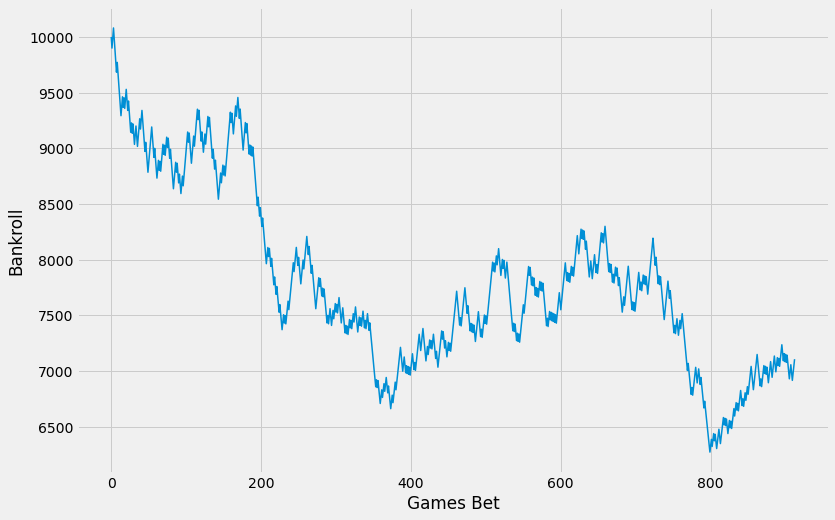

min balance: 6271.61946968746 
max balance: 10080.818181818182 
final balance: 7035.069947246549 
win percentage 50.6


,index,GAME_DATE,HOME_GAME,spread,point_diff_team,lasso_preds,en_preds,ridge_preds,sgd_preds,xgbr_preds,svr_preds,rf_preds,lgbr_preds,home_cover,bet_home_lasso,bet_home_en,bet_home_ridge,bet_home_sgd,bet_home_xgbr,bet_home_svr,bet_home_rf,bet_home_lgbr,bet_consensus,bet_home,bet_won,bankroll_i,bet_size,bankroll_n
0,11777,2016-11-05,1,-4.5,-24,0.213260,0.231837,0.834546,1.326378,-1.478675,0.830264,-0.271166,0.168603,0.0,0,0,0,1,0,0,0,0,1,1,0,10000.000000,100.000000,9900.000000
1,11779,2016-11-05,1,-3.0,15,0.195331,0.162509,0.667753,-0.329578,2.498864,0.268550,-1.286166,-0.470707,1.0,0,0,0,0,1,0,0,0,1,1,1,9900.000000,99.000000,9990.000000
2,11789,2016-11-08,1,4.0,9,-0.607457,-0.495325,0.339221,-0.028548,2.597501,-0.017647,0.478733,-0.228526,1.0,0,0,0,0,1,0,0,0,1,1,1,9990.000000,99.900000,10080.818182
3,11790,2016-11-08,1,-4.0,1,0.084697,0.160411,0.538093,1.366422,0.565771,0.814663,-0.098503,0.284730,0.0,0,0,0,1,0,0,0,0,1,1,0,10080.818182,100.808182,9980.010000
4,11795,2016-11-09,1,-11.5,7,0.323475,0.327824,-0.290948,0.640929,2.914597,-0.017273,0.150087,-0.287823,0.0,0,0,0,0,1,0,0,0,1,1,0,9980.010000,99.800100,9880.209900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,16481,2020-09-20,1,-7.5,2,0.714325,0.763663,0.754744,1.475856,0.197554,1.094332,0.239277,0.049296,0.0,0,0,0,1,0,0,0,0,1,1,0,6985.655264,69.856553,6915.798711
909,16483,2020-09-23,1,3.5,3,1.897914,1.962849,3.287159,2.543345,1.510496,2.880407,0.543966,-0.230455,1.0,1,1,1,1,0,1,0,0,3,1,1,6915.798711,69.157987,6978.669608
910,16486,2020-09-26,1,-5.5,10,1.075247,1.129537,1.408192,1.906490,-1.029127,1.561461,0.313621,-0.164972,1.0,0,0,0,1,0,0,0,0,1,1,1,6978.669608,69.786696,7042.112059
911,16487,2020-09-27,1,3.0,12,1.199596,1.228001,2.517299,1.562851,0.782514,2.012982,0.308588,-0.456948,1.0,0,0,1,1,0,1,0,0,3,1,1,7042.112059,70.421121,7106.131260


In [699]:
simulate_bets(select_bets)

### Custom Loss Function LR

In [45]:
import autograd.numpy as np
from autograd import grad

In [70]:
X_train_hd1
# spread_point_diff_train_ewm_19
X_train1.iloc[:, 0].values

array([ -5.5, -10.5,   2.5, ...,  -5.5,  -2. ,  -5. ])

In [86]:
scaler = StandardScaler()
# X_train_ewm_19_scaled = scaler.fit_transform(X_train_ewm_19)
# spread_point_diff_train_ewm_19

X_train1_scaled = scaler.fit_transform(X_train1)


weights = np.random.random(X_train1.shape[1])

weights.shape

eps = 1e-15

def wTx(w, x):
    return np.dot(x, w)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def custom_loss(y_true, y_pred, spread):
    residual = (y_pred-y_true).astype(float)
    choicelist = [np.where(y_pred+spread>=0, residual**2, 10*residual**2), 
                  np.where(y_pred+spread<0, residual**2, 10*residual**2)]
    loss = np.where(y_true+spread>=0, choicelist[0], choicelist[1])
    #    loss = torch.mean(-torch.log(torch.sigmoid((torch.sign(target) * (output - target)))))
    return loss

#     return np.mean(-np.log(sigmoid(np.sign(y_true) * (y_pred - y_true))))


def custom_loss_given_weights(w):
    y_predicted = wTx(w, X_train1_scaled)
    return custom_loss(y_train1.values, y_predicted, X_train1.iloc[:, 0].values)


gradient = grad(custom_loss_given_weights)


In [93]:
custom_loss(np.array([2]), np.array([1]), -10)

array([1.])

<AxesSubplot:title={'center':'y_pred vs loss for y=-2'}, xlabel='y_pred'>

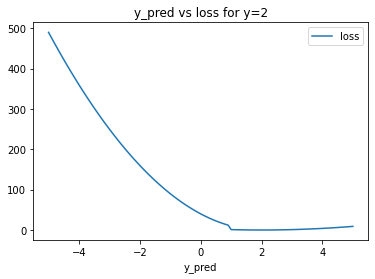

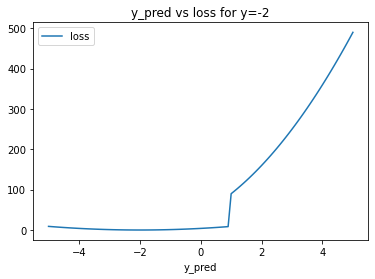

In [88]:
df = pd.DataFrame(
[(y_pred, custom_loss(2, y_pred, -1)) for y_pred in np.linspace(-5, 5, 101)],
columns=['y_pred', 'loss'])
df.astype(float).plot(x='y_pred',  title='y_pred vs loss for y=2')


df = pd.DataFrame(
[(y_pred, custom_loss(-2, y_pred, -1)) for y_pred in np.linspace(-5, 5, 101)],
columns=['y_pred', 'loss'])
df.astype(float).plot(x='y_pred',  title='y_pred vs loss for y=-2')

In [94]:
for i in range(8000):
    if i%1000 == 0:
        print("iteration {}".format(i), "Loss: {}".format(custom_loss_given_weights(weights)))
    weights -= gradient(weights)*0.005

iteration 0 Loss: [ 439.99263672  432.88509045 1710.98213084 ...  212.08825636 8146.84577831
 4019.87024691]


TypeError: Grad only applies to real scalar-output functions. Try jacobian, elementwise_grad or holomorphic_grad.

In [716]:
X_test_ewm_19_scaled = scaler.transform(X_test_ewm_19)
test_preds_custom = wTx(weights, X_test_ewm_19_scaled)
test_preds_custom

array([-2.28919523e-01, -8.65964493e-01,  1.36274241e+00, ...,
       -1.35744142e-03,  3.50963761e+00, -6.83631823e-01])

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.2
num_games_bet: 1294
win percetange at threshold: 0.5548686244204019


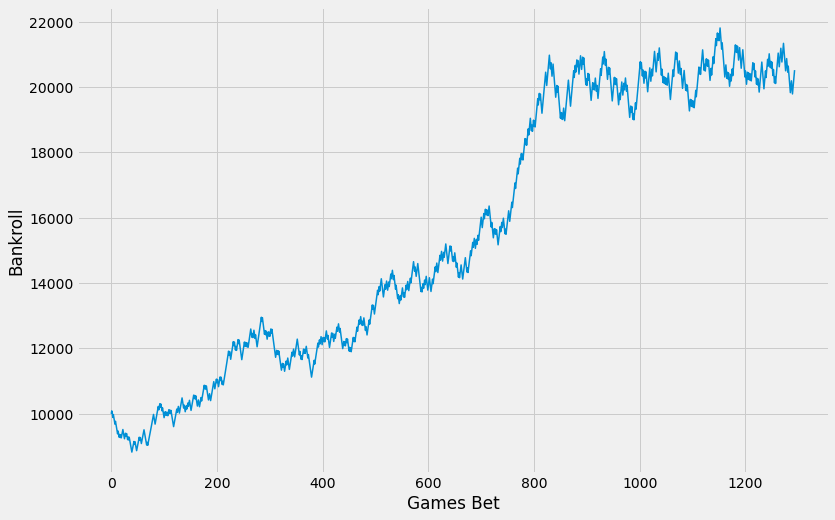

min balance: 8828.84669471551 
max balance: 21810.883064409983 
final balance: 20315.28472156701 
win percentage 55.489999999999995


,index,GAME_DATE,spread,point_diff_team,confidence_preds,home_cover,bet_home,bet_won,bankroll_i,bankroll_n,bet_size
0,11777,2016-11-05,-3.5,17,3.157805,1.0,1,1,10000.000000,10090.909091,100.000000
1,11780,2016-11-05,-4.5,-24,4.544154,0.0,1,0,10090.909091,9990.000000,100.909091
2,11781,2016-11-06,-4.0,11,-2.989369,1.0,0,0,9990.000000,9890.100000,99.900000
3,11782,2016-11-06,-7.5,-5,-2.394538,0.0,0,1,9890.100000,9980.010000,98.901000
4,11786,2016-11-07,-5.5,12,-2.799149,1.0,0,0,9980.010000,9880.209900,99.800100
...,...,...,...,...,...,...,...,...,...,...,...
1289,16483,2020-09-23,3.5,3,4.655065,1.0,1,1,19790.945566,19970.863253,197.909456
1290,16486,2020-09-26,-5.5,10,3.713941,1.0,1,1,19970.863253,20152.416555,199.708633
1291,16487,2020-09-27,3.0,12,3.500975,1.0,1,1,20152.416555,20335.620342,201.524166
1292,16488,2020-09-30,-4.5,18,3.110749,1.0,1,1,20335.620342,20520.489618,203.356203


In [717]:
select_bets_custom, best_thresholds_custom = find_optimal_confidence_thresholds(test_preds_custom, X_test_ewm_19.index)
simulate_bets(select_bets_custom)

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

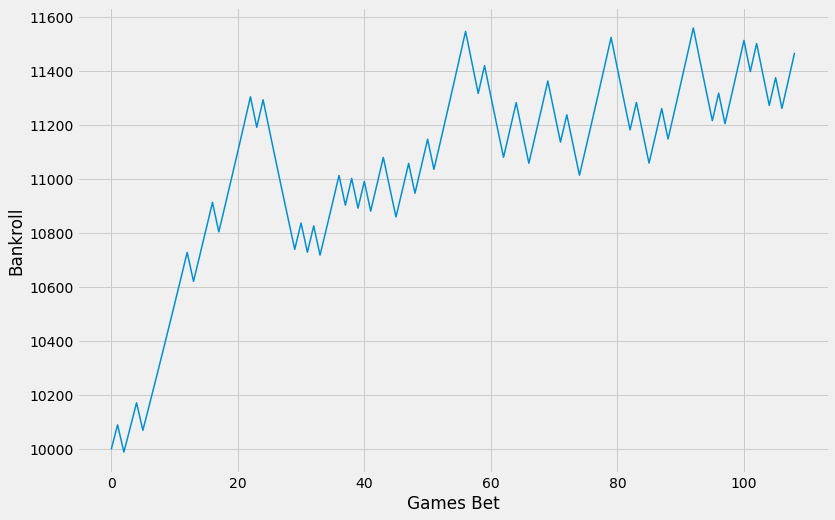

min balance: 9990.0 
max balance: 11572.245758571004 
final balance: 11572.245758571004 
win percentage 59.63


,index,TEAM_ABBREVIATION,point_diff_team,MATCHUP,home_spread_mode,custom_preds,home_cover,bet_home,bet_won,bankroll_i,bet_size,bankroll_n
0,0,MIL,30,MIL vs. CHI,-14.5,4.043642,1,1,1,10000.000000,100.000000,10090.909091
1,1,IND,-4,IND vs. NYK,-9.5,3.905899,0,1,0,10090.909091,100.909091,9990.000000
2,3,ATL,-5,ATL vs. CLE,-5.5,-4.245147,0,0,1,9990.000000,99.900000,10080.818182
3,6,BKN,-1,BKN vs. WAS,-7.5,-9.037124,0,0,1,10080.818182,100.808182,10172.461983
4,7,MEM,-14,MEM vs. LAL,10.0,5.211821,0,1,0,10172.461983,101.724620,10070.737364
...,...,...,...,...,...,...,...,...,...,...,...,...
104,513,DET,4,DET vs. TOR,6.5,3.953408,1,1,1,11273.565152,112.735652,11376.052108
105,519,POR,8,POR vs. NOP,-1.5,-4.217931,1,0,0,11376.052108,113.760521,11262.291586
106,534,LAC,27,LAC vs. CHA,-9.5,3.445899,1,1,1,11262.291586,112.622916,11364.676055
107,540,DEN,-5,DEN vs. NOP,-6.5,-4.166171,0,0,1,11364.676055,113.646761,11467.991292


In [523]:
test_preds_custom = wTx(weights, scaler.transform(full_df_2020[X_train_ewm_19.columns]))


betting_df_2020 = full_df_2020[['TEAM_ABBREVIATION', 'point_diff_team', 'MATCHUP', 'home_spread_mode']]
betting_df_2020['custom_preds'] = test_preds_custom
betting_df_2020['home_cover'] = (betting_df_2020['point_diff_team'] + betting_df_2020['home_spread_mode'] > 0).astype(int)
betting_df_2020['bet_home'] = (betting_df_2020['custom_preds'] > 0).astype(int)
betting_df_2020['bet_won'] = (betting_df_2020['bet_home'] == betting_df_2020['home_cover']).astype(int)
select_bets_2020 = betting_df_2020.loc[(abs(betting_df_2020['custom_preds']) >3.3)]

simulate_bets(select_bets_2020)

### Custom Loss NN Pytorch

In [225]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import TensorDataset, Dataset, DataLoader

In [227]:
torch_scaler = StandardScaler()

X_train_scaled = torch_scaler.fit_transform(X_train_ewm_19)
X_test_scaled = torch_scaler.transform(X_test_ewm_19)


class MatchupDataset(Dataset):
    
    def __init__(self, features, targets):
        self.targets = targets
        self.features = features
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        X = self.features[index]
        y = self.targets[index]
        
        return X, y
    
batch_size = 32

training_set = MatchupDataset(X_train_scaled, spread_point_diff_ewm_19.values)
validation_set = MatchupDataset(X_test_scaled, spread_point_diff_ewm_19.values)

train_loader = DataLoader(training_set, batch_size = batch_size, shuffle=False)
val_loader = DataLoader(validation_set, batch_size = batch_size, shuffle=False)


In [411]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(X_train_ewm_19.shape[1], 128)
#         self.bn1 = nn.BatchNorm1d(num_features=128)
        self.fc2 = nn.Linear(128, 64)
#         self.bn2 = nn.BatchNorm1d(num_features=64)
        self.fc3 = nn.Linear(64, 32)
#         self.bn3 = nn.BatchNorm1d(num_features=32)
        self.fc4 = nn.Linear(32, 1)
        
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = self.fc4(x)
        return x
        
net = Net() 
print(net)

Net(
  (fc1): Linear(in_features=90, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [259]:
data, target = next(iter(train_loader))

data.shape, target.shape

(torch.Size([32, 85]), torch.Size([32]))

In [490]:
net =Net()

learning_rate = 0.00001
def my_loss(output, target):
#     residual = (output-target).float()
#     choicelist = [torch.where(output<0, residual**2, 3*residual**2), torch.where(output<0, 3*residual**2, residual**2)]
#     loss = torch.where(target<0, choicelist[0], choicelist[1])
    loss = -torch.log(torch.sigmoid((torch.sign(target) * (output - target))))
    return torch.mean(loss)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0)

epochs = 500

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in range(epochs):
    train_loss = 0
    val_loss = 0
    train_correct_preds = 0
    train_total_preds = 0
    
    val_correct_preds = 0
    val_total_preds = 0
 
    net.train()
    
    for (data, target) in  train_loader:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = torch.clamp(net(data.float()), -10, 10)
        loss = my_loss(outputs, target.float())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

        n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
        train_correct_preds += n_correct_preds
        train_total_preds += outputs.shape[0]
    train_losses.append(train_loss/X_train_ewm_19.shape[0])
    train_accuracies.append(round(train_correct_preds / train_total_preds, 4))

    with torch.no_grad():
        net.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target.reshape(-1, 1)
            outputs = torch.clamp(net(data.float()), -10, 10)
            loss = my_loss(outputs, target.float())
            val_loss += loss.item()
            n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
            val_correct_preds += n_correct_preds
            val_total_preds += outputs.shape[0]

        val_accuracies.append(round(val_correct_preds / val_total_preds, 4))
        val_losses.append(val_loss/X_test_ewm_19.shape[0])
        
    if e % 10 == 0:
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.6f}.. ".format(train_loss / X_train_ewm_19.shape[0]),
             "Test Loss: {:.6f}.. ".format(val_loss / X_test_ewm_19.shape[0]),
             "Training Accuracy {:.3f}..".format(train_accuracies[-1]), 
             "Validation Accuracy {:.3f}..".format(val_accuracies[-1]))


Epoch: 1/500..  Training Loss: 0.288551..  Test Loss: 0.293453..  Training Accuracy 0.494.. Validation Accuracy 0.502..
Epoch: 11/500..  Training Loss: 0.288493..  Test Loss: 0.293407..  Training Accuracy 0.505.. Validation Accuracy 0.504..
Epoch: 21/500..  Training Loss: 0.288437..  Test Loss: 0.293364..  Training Accuracy 0.502.. Validation Accuracy 0.501..
Epoch: 31/500..  Training Loss: 0.288372..  Test Loss: 0.293309..  Training Accuracy 0.504.. Validation Accuracy 0.502..
Epoch: 41/500..  Training Loss: 0.288234..  Test Loss: 0.293237..  Training Accuracy 0.505.. Validation Accuracy 0.501..
Epoch: 51/500..  Training Loss: 0.288075..  Test Loss: 0.293147..  Training Accuracy 0.505.. Validation Accuracy 0.500..
Epoch: 61/500..  Training Loss: 0.287989..  Test Loss: 0.293049..  Training Accuracy 0.506.. Validation Accuracy 0.497..
Epoch: 71/500..  Training Loss: 0.287755..  Test Loss: 0.292942..  Training Accuracy 0.507.. Validation Accuracy 0.498..
Epoch: 81/500..  Training Loss: 0

KeyboardInterrupt: 

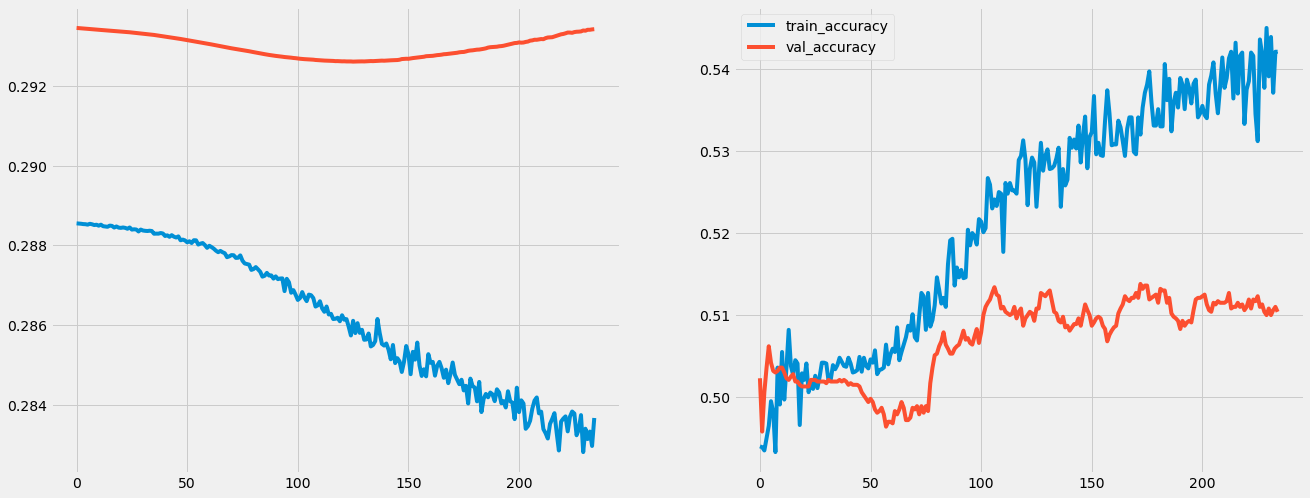

In [492]:
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].plot(train_losses, label='train_loss')
axs[0].plot(val_losses, label='val_loss')

axs[1].plot(train_accuracies, label='train_accuracy')
axs[1].plot(val_accuracies, label='val_accuracy')
plt.legend()
plt.show()

In [482]:
net2 =Net()

learning_rate = 0.000001
def my_loss(output, target):
    residual = (output-target).float()
    choicelist = [torch.where(output<=0, residual**2, 3*residual**2), torch.where(output<=0, 3*residual**2, residual**2)]
    loss = torch.where(target<=0, choicelist[0], choicelist[1])
#     loss = -torch.log(torch.sigmoid((torch.sign(target) * torch.clamp((output - target), -20, 20))))
    return torch.mean(loss)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net2.parameters(), lr=learning_rate, weight_decay=0)

epochs = 500

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in range(epochs):
    train_loss = 0
    val_loss = 0
    train_correct_preds = 0
    train_total_preds = 0
    
    val_correct_preds = 0
    val_total_preds = 0
 
    net2.train()
    
    for (data, target) in  train_loader:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = net2(data.float())
        loss = loss_function(outputs, target.float())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()

        n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
        train_correct_preds += n_correct_preds
        train_total_preds += outputs.shape[0]
    train_losses.append(train_loss/X_train_ewm_19.shape[0])
    train_accuracies.append(round(train_correct_preds / train_total_preds, 4))

    with torch.no_grad():
        net2.eval()
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target.reshape(-1, 1)
            outputs = net2(data.float())
            loss = loss_function(outputs, target.float())
            val_loss += loss.item()
            n_correct_preds = (torch.sign(outputs)==torch.sign(target)).detach().numpy().flatten().astype(int).sum()
            val_correct_preds += n_correct_preds
            val_total_preds += outputs.shape[0]

        val_accuracies.append(round(val_correct_preds / val_total_preds, 4))
        val_losses.append(val_loss/X_test_ewm_19.shape[0])
        
    if e % 20 == 0:
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.6f}.. ".format(train_loss / X_train_ewm_19.shape[0]),
             "Test Loss: {:.6f}.. ".format(val_loss / X_test_ewm_19.shape[0]),
             "Training Accuracy {:.3f}..".format(train_accuracies[-1]), 
             "Validation Accuracy {:.3f}..".format(val_accuracies[-1]))


Epoch: 1/500..  Training Loss: 4.285663..  Test Loss: 4.377806..  Training Accuracy 0.510.. Validation Accuracy 0.503..
Epoch: 21/500..  Training Loss: 4.285192..  Test Loss: 4.377680..  Training Accuracy 0.512.. Validation Accuracy 0.501..
Epoch: 41/500..  Training Loss: 4.284325..  Test Loss: 4.377541..  Training Accuracy 0.509.. Validation Accuracy 0.503..
Epoch: 61/500..  Training Loss: 4.282853..  Test Loss: 4.377401..  Training Accuracy 0.517.. Validation Accuracy 0.502..
Epoch: 81/500..  Training Loss: 4.284114..  Test Loss: 4.377295..  Training Accuracy 0.510.. Validation Accuracy 0.501..
Epoch: 101/500..  Training Loss: 4.283797..  Test Loss: 4.377206..  Training Accuracy 0.514.. Validation Accuracy 0.501..
Epoch: 121/500..  Training Loss: 4.282302..  Test Loss: 4.377129..  Training Accuracy 0.512.. Validation Accuracy 0.500..
Epoch: 141/500..  Training Loss: 4.282051..  Test Loss: 4.377056..  Training Accuracy 0.514.. Validation Accuracy 0.501..
Epoch: 161/500..  Training Los

KeyboardInterrupt: 

In [493]:
train_outputs = np.array([])
train_outputs2 = np.array([])
train_targets = np.array([])
for data, target in train_loader:
    outputs = net(data.float())
    outputs2 = net2(data.float())
#     print(outputs.shape)
#     print(test_outputs.shape)
    train_outputs = np.concatenate([train_outputs, outputs.detach().numpy().flatten()])
    train_outputs2 = np.concatenate([train_outputs2, outputs2.detach().numpy().flatten()])

    train_targets = np.concatenate([train_targets, target.detach().numpy().flatten()])
# correct_pred = (torch.sign(test_outputs)==torch.sign(target)).detach().numpy().flatten()
train_preds = pd.DataFrame({'preds':train_outputs, 'preds2':train_outputs2, 'target':train_targets})
# test_outputs.detach().numpy().flatten()
train_preds

,preds,preds2,target
0,-1.569377,-0.411728,4.5
1,2.848549,-0.101551,-1.5
2,-0.019031,-0.067838,3.5
3,2.170247,-0.185665,-19.5
4,-3.343860,-0.671299,-10.0
...,...,...,...
11767,0.601759,0.044105,28.5
11768,0.989692,0.048848,-13.5
11769,1.633067,0.119707,-20.5
11770,2.350058,0.031689,12.0


In [481]:
train_preds['preds2'].describe()

count    11772.000000
mean        -0.051085
std          0.081908
min         -0.467047
25%         -0.102110
50%         -0.046459
75%          0.006428
max          0.208395
Name: preds2, dtype: float64

In [465]:
y_pred = net(data.float())

preds_df = pd.DataFrame({"y_true":target.detach().numpy().flatten(), "y_pred":y_pred.detach().numpy().flatten()})
preds_df

,y_true,y_pred
0,-1.0,-0.362796
1,2.5,0.376909
2,-11.5,0.066797
3,3.0,0.101686
4,-9.5,0.647189
5,13.0,0.814767
6,8.5,0.058365
7,23.0,0.676957
8,-14.0,0.330269
9,20.0,1.236707


In [494]:
test_outputs = np.array([])
test_outputs2 = np.array([])

for data, target in val_loader:
    outputs = net(data.float())
    outputs2 = net2(data.float())
#     print(outputs.shape)
#     print(test_outputs.shape)
    test_outputs = np.concatenate([test_outputs, outputs.detach().numpy().flatten()])
    test_outputs2 = np.concatenate([test_outputs2, outputs2.detach().numpy().flatten()])

# correct_pred = (torch.sign(test_outputs)==torch.sign(target)).detach().numpy().flatten()
preds = pd.DataFrame({'preds':test_outputs, 'preds2':test_outputs2, 'target':spread_point_diff_test_ewm_19})
# test_outputs.detach().numpy().flatten()

In [495]:
preds['bet_won'] = (np.sign(preds['preds']) == np.sign(preds['target'])).astype(int)
print(preds['bet_won'].mean())
preds['pred_probs'] = 1 / (1 + np.exp(-preds['preds']/10))
preds['pred_scaled'] = preds['preds']*10
preds['bet_home'] = (preds['preds'] > 0).astype(int)

0.5010620220900595


In [496]:
preds


,preds,preds2,target,bet_won,pred_probs,pred_scaled,bet_home
11772,3.245110,0.129812,-10.5,0,0.580423,32.451100,1
11773,-5.352964,-0.005315,31.5,0,0.369282,-53.529644,0
11774,-0.912930,-0.088472,-3.5,1,0.477193,-9.129300,0
11775,2.345120,0.156321,13.5,1,0.558361,23.451197,1
11776,-0.504047,-0.434542,12.0,0,0.487401,-5.040472,0
...,...,...,...,...,...,...,...
16475,3.186399,0.029901,-1.0,0,0.578993,31.863995,1
16476,1.176630,0.109124,20.5,1,0.529382,11.766295,1
16477,0.970830,0.048862,1.5,1,0.524252,9.708300,1
16478,1.041771,0.114306,-10.5,0,0.526021,10.417712,1


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


best thresholds: 2.32
num_games_bet: 1623
win percetange at threshold: 0.5465187923598275


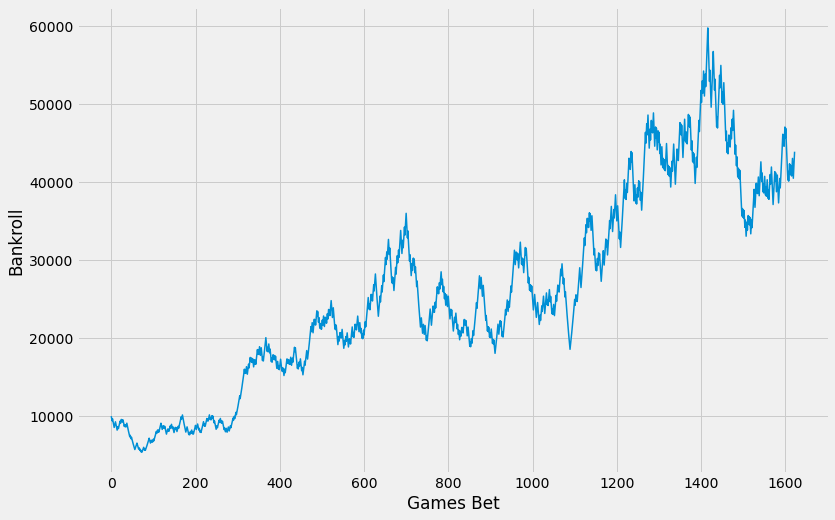

min balance: 5394.227702928191 
max balance: 59766.325969626225 
final balance: 42585.72589427221 
win percentage 54.65


,index,GAME_DATE,spread,point_diff_team,confidence_preds,home_cover,bet_home,bet_won,bankroll_i,bankroll_n,bet_size
0,11772,2016-11-04 00:00:00,3.5,-14.0,3.245110,0.0,1,0,10000.000000,9700.000000,300.000000
1,11773,2016-11-04 00:00:00,11.5,20.0,-5.352964,1.0,0,0,9700.000000,9409.000000,291.000000
2,11775,2016-11-05 00:00:00,-3.5,17.0,2.345120,1.0,1,1,9409.000000,9665.609091,282.270000
3,11778,2016-11-05 00:00:00,-4.5,-24.0,2.687921,0.0,1,0,9665.609091,9375.640818,289.968273
4,11785,2016-11-07 00:00:00,-5.5,12.0,-6.921419,1.0,0,0,9375.640818,9094.371594,281.269225
...,...,...,...,...,...,...,...,...,...,...,...
1618,16446,2020-09-04 00:00:00,-5.5,-15.0,3.672901,0.0,1,0,41750.656697,40498.136996,1252.519701
1619,16448,2020-09-05 00:00:00,-9.0,-9.0,-4.396315,0.0,0,1,40498.136996,41602.631641,1214.944110
1620,16450,2020-09-06 00:00:00,-6.0,8.0,2.686229,1.0,1,1,41602.631641,42737.248868,1248.078949
1621,16464,2020-09-17 00:00:00,-3.0,-5.0,-4.081581,0.0,0,1,42737.248868,43902.810200,1282.117466


In [497]:
select_bets_nn, best_thresholds_nn = find_optimal_confidence_thresholds(test_outputs, test_indices)
simulate_bets(select_bets_nn)

In [459]:
(select_bets_nn['confidence_preds']>0).mean()

0.0

### Train NN on Full Data



In [397]:
df_2020 = load_current_season_team_data('2020-21')
df_2020 = clean_team_data(df_2020)
df_2020 = prep_for_aggregation(df_2020)
df_2020 = create_matchups(df_2020)
df_2020 = add_spread_data(df_2020)
df_2020 = get_team_and_opp_ewm(df_2020)
df_2020 = add_rest_days(df_2020)

df_2020 = add_percentage_features(df_2020)

df_2020 = compute_matchup_diffs(df_2020)

df_2020 = add_elo_ratings(df_2020, final_elo_2020)

features_2020 = df_2020[X_train_hd.columns]
features_2020 = features_2020.dropna()

Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s]
progress:: 603it [00:00, 830.59it/s]


In [400]:
spread_point_diff_2020 = df_2020['point_diff_team'] + df_2020['home_spread_mode']
spread_point_diff_2020

0      15.5
1     -13.5
2       5.0
3     -10.5
4      -6.5
       ... 
598    26.5
599     1.0
600    -5.0
601     3.5
602   -18.5
Length: 603, dtype: float64

In [401]:
features_ewm_19.shape, spread_point_diff_ewm_19.shape, features_2020.shape
full_data = pd.concat([features_ewm_19, features_2020])
spread_point_diff_full = pd.concat([spread_point_diff_ewm_19, spread_point_diff_2020])

full_data.shape, spread_point_diff_full.shape

((17083, 90), (17083,))

In [410]:
x = pd.concat([full_data, spread_point_diff_full], axis=1)
x.rename(columns={0:'target'}, inplace=True)
x.to_csv("../data/clean_data_ewm_19.csv", index=False)

In [498]:
nn_scaler = StandardScaler()

full_dataset = MatchupDataset(nn_scaler.fit_transform(full_data), spread_point_diff_full.values)

full_data_loader = DataLoader(full_dataset, batch_size = batch_size, shuffle=False) 

net_full = Net()

learning_rate = 0.00001
def my_loss(output, target):
#     residual = (output-target).float()
#     choicelist = [torch.where(output<0, residual**2, 3*residual**2), torch.where(output<0, 3*residual**2, residual**2)]
#     loss = torch.where(target<0, choicelist[0], choicelist[1])
    loss = -torch.log(torch.sigmoid((torch.sign(target) * (output - target))))
    return torch.mean(loss)

loss_function = nn.MSELoss()

optimizer = optim.Adam(net_full.parameters(), lr=learning_rate, weight_decay=0)

epochs = 131

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
for e in tqdm(range(epochs), desc='progress'):
    train_loss = 0
    train_correct_preds = 0
    train_total_preds = 0

    net_full.train()
    
    for (data, target) in  train_loader:
        optimizer.zero_grad()
        target = target.reshape(-1, 1)
        outputs = torch.clamp(net_full(data.float()), -10, 10)
        loss = my_loss(outputs, target.float())
        loss.backward()

        optimizer.step()

progress: 100%|██████████████████████████████████████████████████████████████████████| 131/131 [01:36<00:00,  1.35it/s]


### Test Model on current Season

In [279]:
df_2020 = load_current_season_team_data('2020-21')
df_2020 = clean_team_data(df_2020)
df_2020 = prep_for_aggregation(df_2020)
df_2020 = create_matchups(df_2020)
df_2020 = add_spread_data(df_2020)
df_2020 = get_team_and_opp_ewm(df_2020)
df_2020 = add_rest_days(df_2020)

df_2020 = add_percentage_features(df_2020)

df_2020 = compute_matchup_diffs(df_2020)

Progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


In [280]:
df_2020

,SEASON_YEAR,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,HOME_GAME,SCORE_team,point_diff_team,WL_team,MIN_team,home_spread_mode,WL_record_diff,ATS_record_diff,RECORD_team_diff,team_covered_diff,FG2M_team_diff,FG2A_team_diff,FG3M_team_diff,FG3A_team_diff,FTM_team_diff,FTA_team_diff,OREB_team_diff,DREB_team_diff,REB_team_diff,AST_team_diff,STL_team_diff,BLK_team_diff,TOV_team_diff,PF_team_diff,PTS_team_diff,PLUS_MINUS_team_diff,E_OFF_RATING_team_diff,OFF_RATING_team_diff,E_DEF_RATING_team_diff,DEF_RATING_team_diff,E_NET_RATING_team_diff,NET_RATING_team_diff,POSS_team_diff,PIE_team_diff,PTS_2PT_MR_team_diff,PTS_FB_team_diff,PTS_OFF_TOV_team_diff,PTS_PAINT_team_diff,AST_2PM_team_diff,UAST_2PM_team_diff,AST_3PM_team_diff,UAST_3PM_team_diff,TEAM_SCORE_opp_diff,RECORD_opp_diff,FG2M_opp_diff,FG2A_opp_diff,FG3M_opp_diff,FG3A_opp_diff,FTM_opp_diff,FTA_opp_diff,OREB_opp_diff,DREB_opp_diff,REB_opp_diff,AST_opp_diff,STL_opp_diff,BLK_opp_diff,TOV_opp_diff,PF_opp_diff,PTS_opp_diff,PLUS_MINUS_opp_diff,E_OFF_RATING_opp_diff,OFF_RATING_opp_diff,E_DEF_RATING_opp_diff,DEF_RATING_opp_diff,E_NET_RATING_opp_diff,NET_RATING_opp_diff,POSS_opp_diff,PIE_opp_diff,PTS_2PT_MR_opp_diff,PTS_FB_opp_diff,PTS_OFF_TOV_opp_diff,PTS_PAINT_opp_diff,AST_2PM_opp_diff,UAST_2PM_opp_diff,AST_3PM_opp_diff,UAST_3PM_opp_diff,OREB_PCT_team_diff,OREB_PCT_opp_diff,DREB_PCT_team_diff,DREB_PCT_opp_diff,REB_PCT_team_diff,REB_PCT_opp_diff,TS_PCT_team_diff,TS_PCT_opp_diff,EFG_PCT_team_diff,EFG_PCT_opp_diff,AST_RATIO_team_diff,AST_RATIO_opp_diff,TOV_PCT_team_diff,TOV_PCT_opp_diff,rest_diff
0,2020-21,22020,1610612749,MIL,Milwaukee Bucks,22000073,2021-01-01,MIL vs. CHI,1,126,30,1,240,-14.5,0.000000,0.000000,-0.066177,-0.044199,1.011550,2.233474,3.260629,3.390149,-6.676491,-8.486240,4.910820,1.387561,6.298381,-1.032478,2.213475,0.701155,-3.405069,-0.850578,5.128495,14.763473,11.435291,9.455071,-4.956033,-4.520647,16.381920,13.957916,-4.426900,0.065356,3.118678,10.509316,1.884960,-1.071622,-1.486508,2.897829,0.254035,2.824400,-9.634978,0.066177,-2.987693,-3.582184,0.887256,2.669410,-6.321360,-7.097702,-0.751825,-0.842495,-1.594320,-4.252912,-3.906571,1.080877,-0.489023,-7.030158,-9.634978,-14.763473,-4.956033,-4.520647,11.435291,9.455071,-16.381920,-13.957916,-4.158287,-0.065356,-1.039242,-2.276550,-2.787722,-4.953945,-3.752216,1.008718,-0.458475,1.079558,0.087657,-0.020046,0.020046,-0.087657,0.043574,-0.043574,0.002207,-0.034683,0.030188,-0.013070,0.055526,-3.103493,-2.691784,0.135976,1.0
1,2020-21,22020,1610612754,IND,Indiana Pacers,22000080,2021-01-02,IND vs. NYK,1,102,-4,0,240,-9.5,0.400000,0.400000,0.362653,0.362653,8.412029,2.926742,0.491954,1.743449,-1.692413,-2.246441,-2.108740,-2.153671,-4.262411,4.948182,3.933677,0.045445,-3.606334,0.583307,16.607507,13.628922,13.953637,13.038807,1.916451,0.881366,11.997407,12.175244,3.179214,0.087311,0.287783,14.191815,6.727797,16.776294,4.646236,3.368001,0.183488,0.688457,2.978584,-0.362653,-1.219775,5.708456,1.145125,-11.783497,1.982760,2.612976,-2.749994,-3.153403,-5.903397,-0.515567,0.003468,-1.125027,3.509145,-1.064370,2.978584,-13.628922,1.916451,0.881366,13.953637,13.038807,-11.997407,-12.175244,2.120778,-0.087311,0.783253,-1.200923,-3.265366,-3.108984,-1.669507,0.454372,1.028204,-0.282850,-0.023725,-0.034200,0.034200,0.023725,0.009415,-0.009415,0.063965,0.050732,0.077143,0.041510,4.104160,-0.973810,-3.216521,3.284356,0.0
2,2020-21,22020,1610612755,PHI,Philadelphia 76ers,22000082,2021-01-02,PHI vs. CHA,1,127,15,1,240,-10.0,0.400000,0.200000,0.384630,0.224415,-0.811116,-1.193304,-1.315426,-2.319015,5.051281,2.784181,-2.238480,5.879783,3.641303,-6.521379,0.392689,3.024688,-0.168665,-1.342629,-0.517228,7.742741,-0.135494,-0.616034,-7.704454,-7.047291,7.563005,6.465080,0.241166,0.077831,4.185050,-3.953725,-3.433225,-6.071256,-7.295426,6.484311,0.367195,-1.462846,-8.259969,-0.384630,-0.146663,10.950673,-2.709116,-8.500720,0.160704,-2.967131,0.240653,-2.240605,-1.999951,-5.257649,-1.246978,-0.200459,-1.078142,3.8

In [281]:
with open('../data/elo_data/final_elo_2020.pkl', 'rb') as file:
    final_elo_2020 = pickle.load(file)

In [282]:
def add_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME'] == 1]
    # Initialize the following columns

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP'][:3]
        away_team_abbr = row['MATCHUP'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return df

df_2020 = add_elo_ratings(df_2020, final_elo_2020)


progress:: 603it [00:00, 716.17it/s]


In [283]:
df_2020.isnull().sum()

SEASON_YEAR          0
SEASON_ID            0
TEAM_ID              0
TEAM_ABBREVIATION    0
TEAM_NAME            0
                    ..
home_rating_i        0
home_rating_n        0
away_rating_i        0
away_rating_n        0
elo_MOV_pred         0
Length: 105, dtype: int64

In [284]:
features_2020 = df_2020[X_train_hd.columns]
features_2020 = features_2020.dropna()
indices_2020 = features_2020.index

In [97]:
with open('../models/best_sgd_hd.pkl', 'rb') as f:
    sgd_pipe_hd = pickle.load(f)
    
with open('../models/best_sgd_hf.pkl', 'rb') as f:
    sgd_pipe_hf = pickle.load(f)
    
# with open('../models/lgbr_ewm_19.pkl', 'rb') as f:
#     best_lgbr = pickle.load(f)
    
# with open('../models/xgb_ewm_19.pkl', 'rb') as f:
#     best_xgbr = pickle.load(f)
    
# with open('../models/rf_ewm_19.pkl', 'rb') as f:
#     best_rf = pickle.load(f)
    
# with open('../models/en_ewm_19.pkl', 'rb') as f:
#     en_pipe = pickle.load(f)
    


    

    


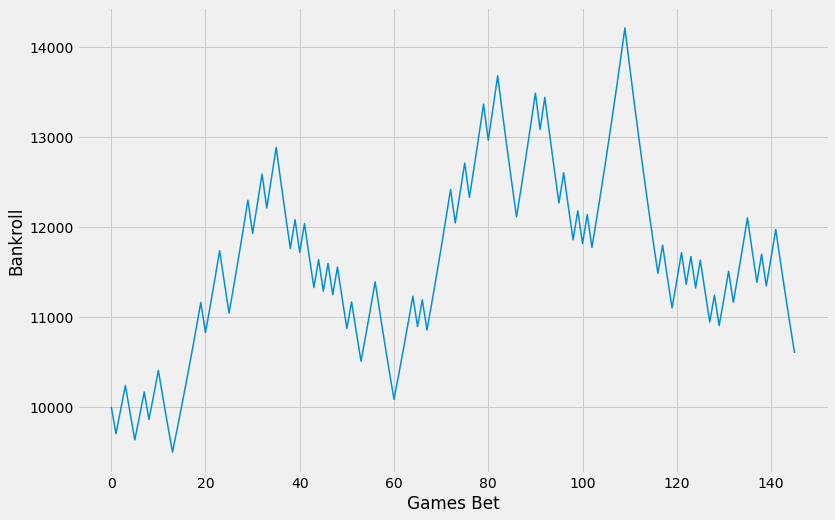

min balance: 9495.474893441879 
max balance: 14210.736110540929 
final balance: 10886.320185706538 
win percentage 54.11


,index,TEAM_ABBREVIATION,point_diff_team,MATCHUP,home_spread_mode,en_preds,home_cover,bet_home,bet_won,bankroll_i,bet_size,bankroll_n
0,1,IND,-4,IND vs. NYK,-9.5,3.723771,0,1,0,10000.000000,300.000000,9700.000000
1,5,DET,-2,DET vs. BOS,8.0,2.559869,1,1,1,9700.000000,291.000000,9964.545455
2,6,BKN,-1,BKN vs. WAS,-7.5,-4.080041,0,0,1,9964.545455,298.936364,10236.305785
3,7,MEM,-14,MEM vs. LAL,10.0,3.573525,0,1,0,10236.305785,307.089174,9929.216612
4,10,PHX,-5,PHX vs. LAC,3.5,2.042165,0,1,0,9929.216612,297.876498,9631.340113
...,...,...,...,...,...,...,...,...,...,...,...,...
141,573,TOR,-4,TOR vs. PHX,3.5,5.471833,0,1,0,11970.392977,359.111789,11611.281188
142,577,NOP,-5,NOP vs. DEN,2.5,2.881363,0,1,0,11611.281188,348.338436,11262.942752
143,587,TOR,-5,TOR vs. POR,2.5,3.269273,0,1,0,11262.942752,337.888283,10925.054470
144,593,HOU,-10,HOU vs. MEM,8.0,3.477994,0,1,0,10925.054470,327.751634,10597.302836


In [224]:
sgd_preds_2020_hd = best_sgd_hd.predict(features_2020.loc[features_2020['home_spread_mode'] >= 0])
sgd_preds_2020_hf = best_sgd_hf.predict(features_2020.loc[features_2020['home_spread_mode'] < 0])

en_preds_2020_hd = best_en_hd.predict(features_2020.loc[features_2020['home_spread_mode'] >= 0])
en_preds_2020_hf = best_en_hf.predict(features_2020.loc[features_2020['home_spread_mode'] < 0])


betting_df_2020 = df_2020.loc[indices_2020, ['TEAM_ABBREVIATION', 'point_diff_team', 'MATCHUP', 'home_spread_mode']]
betting_df_2020['en_preds'] = 0
betting_df_2020.loc[betting_df_2020['home_spread_mode'] >= 0, 'en_preds'] = en_preds_2020_hd
betting_df_2020.loc[betting_df_2020['home_spread_mode'] < 0, 'en_preds'] = en_preds_2020_hf
# betting_df_2020['lgbr_preds'] = lgbr_preds_2020
# betting_df_2020['xgb_preds'] = xgb_preds_2020
# betting_df_2020['rf_preds'] = rf_preds_2020
# betting_df_2020['en_preds'] = en_preds_2020


# betting_df_2020['net_preds'] = net_preds.detach().numpy().flatten()/10
betting_df_2020['home_cover'] = (betting_df_2020['point_diff_team'] + betting_df_2020['home_spread_mode'] > 0).astype(int)
betting_df_2020['bet_home'] = (betting_df_2020['en_preds'] > 0).astype(int)
# betting_df_2020['bet_home'] = ((betting_df_2020['lgbr_preds'] > 0) & (betting_df_2020['sgd_preds'] > 0)).astype(int)
betting_df_2020['bet_won'] = (betting_df_2020['bet_home'] == betting_df_2020['home_cover']).astype(int)
select_bets_2020 = betting_df_2020.loc[((betting_df_2020['home_spread_mode'] >= 0) & (abs(betting_df_2020['en_preds']) > 2.))
                                       | ((betting_df_2020['home_spread_mode'] < 0) & (abs(betting_df_2020['en_preds']) > 2))]
#                                         (abs(betting_df_2020['lgbr_preds']) > 0.4)
#                                       & (abs(betting_df_2020['rf_preds']) > 0.34)]



simulate_bets(select_bets_2020)
# select_bets_2020['bet_won'].mean()


In [384]:
# sgd_preds_2020_hd = sgd_pipe_hd.predict(features_2020.loc[features_2020['home_spread_mode'] > 0])
# sgd_preds_2020_hf = sgd_pipe_hf.predict(features_2020.loc[features_2020['home_spread_mode'] <= 0])

# lgbr_preds_2020 = best_lgbr.predict(features_2020)

# xgb_preds_2020 = xgbr.predict(features_2020)

# rf_preds_2020 = best_rf.predict(features_2020)

# en_preds_2020 = en_pipe.predict(features_2020)

net_preds = net(torch.Tensor(torch_scaler.transform(features_2020))).detach().numpy()

# net_preds

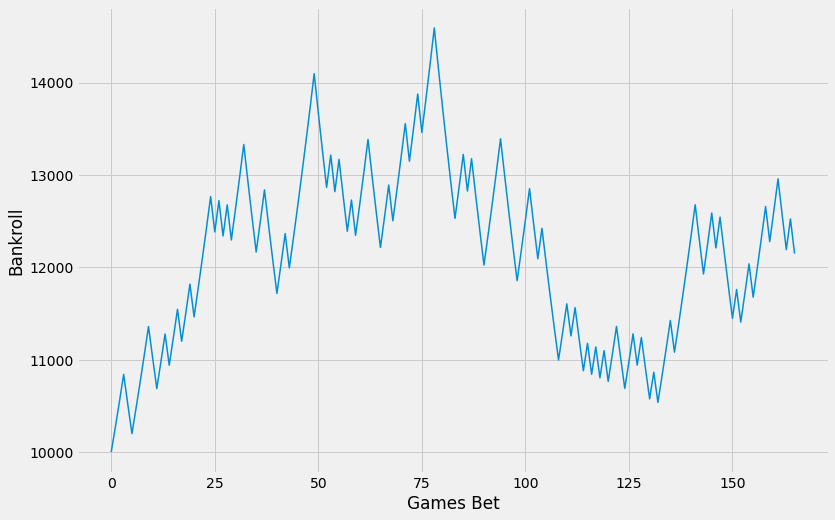

min balance: 10200.013428249435 
max balance: 14590.44129690014 
final balance: 11783.765125935191 
win percentage 54.82


,index,TEAM_ABBREVIATION,point_diff_team,MATCHUP,home_spread_mode,spread+diff,net_preds,home_cover,bet_home,bet_won,bankroll_i,bet_size,bankroll_n
0,3,ATL,-5,ATL vs. CLE,-5.5,-10.5,-7.630116,0,0,1,10000.000000,300.000000,10272.727273
1,4,MIN,-15,MIN vs. DEN,8.5,-6.5,-17.511482,0,0,1,10272.727273,308.181818,10552.892562
2,6,BKN,-1,BKN vs. WAS,-7.5,-8.5,-24.358429,0,0,1,10552.892562,316.586777,10840.698723
3,7,MEM,-14,MEM vs. LAL,10.0,-4.0,10.259763,0,1,0,10840.698723,325.220962,10515.477761
4,8,SAS,-21,SAS vs. UTA,5.5,-15.5,8.119968,0,1,0,10515.477761,315.464333,10200.013428
...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,548,MIL,27,MIL vs. IND,-7.0,20.0,-7.958269,1,0,0,12957.206559,388.716197,12568.490362
162,552,MIA,-10,MIA vs. PHX,2.0,-8.0,7.853865,0,1,0,12568.490362,377.054711,12191.435651
163,589,BOS,-6,BOS vs. NOP,-3.0,-9.0,-7.221478,0,0,1,12191.435651,365.743070,12523.929351
164,593,HOU,-10,HOU vs. MEM,8.0,-2.0,8.024974,0,1,0,12523.929351,375.717881,12148.211470


In [385]:
betting_df_2020 = df_2020.loc[indices_2020, ['TEAM_ABBREVIATION', 'point_diff_team', 'MATCHUP', 'home_spread_mode']]
betting_df_2020['spread+diff'] = betting_df_2020['home_spread_mode'] + betting_df_2020['point_diff_team']
betting_df_2020['net_preds'] = net_preds
# betting_df_2020.loc[betting_df_2020['home_spread_mode'] > 0, 'sgd_preds'] = sgd_preds_2020_hd
# betting_df_2020.loc[betting_df_2020['home_spread_mode'] <= 0, 'sgd_preds'] = sgd_preds_2020_hf
# betting_df_2020['lgbr_preds'] = lgbr_preds_2020
# betting_df_2020['xgb_preds'] = xgb_preds_2020
# betting_df_2020['rf_preds'] = rf_preds_2020
# betting_df_2020['en_preds'] = en_preds_2020


# betting_df_2020['net_preds'] = net_preds.detach().numpy().flatten()/10
betting_df_2020['home_cover'] = (betting_df_2020['point_diff_team'] + betting_df_2020['home_spread_mode'] > 0).astype(int)
betting_df_2020['bet_home'] = (betting_df_2020['net_preds'] > 0).astype(int)
# betting_df_2020['bet_home'] = ((betting_df_2020['lgbr_preds'] > 0) & (betting_df_2020['sgd_preds'] > 0)).astype(int)
betting_df_2020['bet_won'] = (betting_df_2020['bet_home'] == betting_df_2020['home_cover']).astype(int)
select_bets_2020 = betting_df_2020.loc[abs(betting_df_2020['net_preds']) > 7]
    
                                       # ((betting_df_2020['home_spread_mode'] > 0) & (abs(betting_df_2020['sgd_preds']) > 1.69))
                                      # | ((betting_df_2020['home_spread_mode'] <= 0) & (abs(betting_df_2020['sgd_preds']) > 3.75))]
#                                         (abs(betting_df_2020['lgbr_preds']) > 0.4)
#                                       & (abs(betting_df_2020['rf_preds']) > 0.34)]



simulate_bets(select_bets_2020)
# select_bets_2020['bet_won'].mean()


In [371]:
# select_bets_2020.loc[select_bets_2020['net_preds'] > 0]
betting_df_2020.loc[betting_df_2020['net_preds']>0]

,TEAM_ABBREVIATION,point_diff_team,MATCHUP,home_spread_mode,net_preds,home_cover,bet_home,bet_won
14,MIL,10,MIL vs. DET,-16.0,0.176570,0,1,0
25,NOP,-1,NOP vs. OKC,-8.0,0.033497,0,1,0
28,MIL,15,MIL vs. DET,-12.0,0.113456,1,1,1
31,MIA,-2,MIA vs. BOS,-2.5,0.000057,0,1,0
40,POR,18,POR vs. MIN,-10.0,0.032014,1,1,1
49,BOS,9,BOS vs. WAS,-3.5,0.029540,1,1,1
56,MIN,-3,MIN vs. SAS,3.5,0.087571,1,1,1
61,HOU,-18,HOU vs. LAL,3.5,0.029953,0,1,0
62,NYK,-25,NYK vs. DEN,5.5,0.009299,0,1,0
63,LAC,3,LAC vs. CHI,-12.5,0.000713,0,1,0


In [ ]:
simulate_bets(sgd_preds_2020)

## Make Predictions

ETL Pipeline

### Update Date

In [441]:
from src.data.update_data import update_all_data
from src.data.update_data import update_moneyline_data
from src.data.update_data import update_spread_data

update_all_data(season='2020-21')
update_spread_data(season='2020-21')
update_moneyline_data(season='2020-21')

updating basic team boxscores
updating basic player boxscores
updating advanced boxscores


progress:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Updating 10 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.26s/it]


updating scoring boxscores


progress:   0%|                                                                                 | 0/10 [00:00<?, ?it/s]

Updating 10 Games


progress: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.50s/it]


updating tracking boxscores
Updating 10 Games


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

Updating lines for 1 days


progress: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.00s/it]


### Get Todays Betting Data

In [442]:
from src.models.model_preparation import get_days_spreads
from datetime import datetime
todays_date = datetime.today().strftime('%Y-%m-%d')

todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


,away_team,home_team,game_date,away_spread1,away_spread2,away_spread3,away_spread4,home_spread1,home_spread2,home_spread3,home_spread4,away_spread_mode,home_spread_mode
0,DAL,WAS,2021-04-03,-4.5-110,-4.5-112,-4.5,-4.5,4.5,4.5,4.5,4.5,-4.5,4.5
1,CLE,MIA,2021-04-03,12-110,12-108,12.5,12.0,-12.0,-12.0,-12.5,-12.0,12.5,-12.0
2,MIN,PHI,2021-04-03,13-110,12-110,13.5,13.0,-13.0,-12.0,-13.5,-13.0,13-110,-13.0
3,NYK,DET,2021-04-03,-1.5-110,-1.5-113,-1.5,-1.5,1.5,1.5,1.5,1.5,-1.5,1.5
4,IND,SAS,2021-04-03,6-110,4.5-113,5.5,6.0,-6.0,-4.5,-5.5,-6.0,6-110,-6.0
5,ORL,UTA,2021-04-03,15-110,15-110,15.0,14.5,-15.0,-15.0,-15.0,-14.5,15-110,-15.0
6,MIL,SAC,2021-04-03,-6-105,-6.5-110,-5.5,-5.5,6.0,6.5,5.5,5.5,-5.5,5.5
7,OKC,POR,2021-04-03,11.5-110,11.5-105,11.5,11.5,-11.5,-11.5,-11.5,-11.5,11.5,-11.5


In [443]:
def load_current_season_team_data(season):
    """Loads basic, advanced, and scoring boxscores from
    current season and merges them into one dataframe
    """
    basic_gls = pd.read_csv('../data/current_season_data/team_gamelogs_{}.csv'.format(season))

    adv_gls = pd.read_csv('../data/current_season_data/team_advanced_boxscores_{}.csv'.format(season))

    scoring_gls = pd.read_csv('../data/current_season_data/team_scoring_boxscores_{}.csv'.format(season))

    temp = pd.merge(basic_gls, adv_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])
    full_df = pd.merge(temp, scoring_gls, how='left', on=['GAME_ID', 'TEAM_ABBREVIATION'], suffixes=['', '_y'])

    full_df = full_df.drop(columns = ['VIDEO_AVAILABLE', 'TEAM_ID_y', 
                                      'TEAM_NAME_y', 'TEAM_CITY', 
                                      'MIN_y', 'TEAM_ID_y',
                                      'TEAM_NAME_y', 'TEAM_CITY_y',
                                      'MIN_y'], errors='ignore')
    
    full_df['SEASON_YEAR'] = season
    
    full_df = full_df[['SEASON_YEAR', 'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'E_OFF_RATING',
       'OFF_RATING', 'E_DEF_RATING', 'DEF_RATING', 'E_NET_RATING',
       'NET_RATING', 'AST_PCT', 'AST_TOV', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT',
       'REB_PCT', 'E_TM_TOV_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT',
       'E_USG_PCT', 'E_PACE', 'PACE', 'PACE_PER40', 'POSS', 'PIE',
       'PCT_FGA_2PT', 'PCT_FGA_3PT', 'PCT_PTS_2PT', 'PCT_PTS_2PT_MR',
       'PCT_PTS_3PT', 'PCT_PTS_FB', 'PCT_PTS_FT', 'PCT_PTS_OFF_TOV',
       'PCT_PTS_PAINT', 'PCT_AST_2PM', 'PCT_UAST_2PM', 'PCT_AST_3PM',
       'PCT_UAST_3PM', 'PCT_AST_FGM', 'PCT_UAST_FGM']]
    return full_df

df = load_current_season_team_data('2020-21')

In [444]:
def get_team_and_opp_ewm_for_model(df, min_periods=5, span=19, adjust=True):
    df = df.copy()
    df = df[['SEASON_YEAR_team', 'SEASON_ID_team', 'TEAM_ID_team',
       'TEAM_ABBREVIATION_team', 'TEAM_NAME_team', 'GAME_ID', 'GAME_DATE_team',
       'MATCHUP_team', 'HOME_GAME_team', 'TEAM_SCORE_team', 'point_diff_team',
       'WL_team', 'MIN_team', 'home_spread_mode', 'RECORD_team', 'team_covered', 'FG2M_team', 'FG2A_team',
       'FG3M_team', 'FG3A_team', 'FTM_team', 'FTA_team', 'OREB_team',
       'DREB_team', 'REB_team', 'AST_team', 'STL_team', 'BLK_team', 'TOV_team',
       'PF_team', 'PTS_team', 'PLUS_MINUS_team', 'E_OFF_RATING_team',
       'OFF_RATING_team', 'E_DEF_RATING_team', 'DEF_RATING_team',
       'E_NET_RATING_team', 'NET_RATING_team', 'POSS_team', 'PIE_team',
       'PTS_2PT_MR_team', 'PTS_FB_team', 'PTS_OFF_TOV_team', 'PTS_PAINT_team',
       'AST_2PM_team', 'UAST_2PM_team', 'AST_3PM_team', 'UAST_3PM_team',
       'SEASON_YEAR_opp', 'SEASON_ID_opp', 'TEAM_ID_opp',
       'TEAM_ABBREVIATION_opp', 'TEAM_NAME_opp', 'GAME_DATE_opp',
       'MATCHUP_opp', 'HOME_GAME_opp', 'TEAM_SCORE_opp', 'point_diff_opp',
       'WL_opp', 'MIN_opp', 'RECORD_opp', 'FG2M_opp', 'FG2A_opp', 'FG3M_opp',
       'FG3A_opp', 'FTM_opp', 'FTA_opp', 'OREB_opp', 'DREB_opp', 'REB_opp',
       'AST_opp', 'STL_opp', 'BLK_opp', 'TOV_opp', 'PF_opp', 'PTS_opp',
       'PLUS_MINUS_opp', 'E_OFF_RATING_opp', 'OFF_RATING_opp',
       'E_DEF_RATING_opp', 'DEF_RATING_opp', 'E_NET_RATING_opp',
       'NET_RATING_opp', 'POSS_opp', 'PIE_opp', 'PTS_2PT_MR_opp', 'PTS_FB_opp',
       'PTS_OFF_TOV_opp', 'PTS_PAINT_opp', 'AST_2PM_opp', 'UAST_2PM_opp',
       'AST_3PM_opp', 'UAST_3PM_opp', 'home_team', 'away_team', 'game_date',
       'away_spread_mode']]
    
    df = df.drop(columns = ['SEASON_YEAR_opp', 'SEASON_ID_opp', 
                            'TEAM_ID_opp', 'TEAM_ABBREVIATION_opp',
                            'TEAM_NAME_opp', 'GAME_DATE_opp', 
                            'MATCHUP_opp', 'WL_opp', 'HOME_GAME_opp',
                           'point_diff_opp', 'home_team', 'away_team', 'game_date',
                           'away_spread_mode'])
    team_dfs = []

    for team in df['TEAM_ABBREVIATION_team'].unique():
        team_df = df.loc[df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
        team_record = team_df['RECORD_team'].shift(1).expanding().mean()
        ATS_rec = team_df['team_covered'].shift(1).expanding().mean()
        records_df = pd.DataFrame({'WL_record':team_record, 
                                  'ATS_record':ATS_rec})

        team_df.iloc[:, 14:] = team_df.iloc[:, 14:].shift(1).ewm(span = span, min_periods=min_periods).mean()

        team_df = pd.concat([team_df, records_df], axis=1)

        team_dfs.append(team_df)

    new_df = pd.concat(team_dfs)
    new_df = new_df.reset_index(drop=True)
        
    return new_df


In [445]:
def add_rest_days_for_model(df):
    df['rest'] = np.nan
    for season in df['SEASON_YEAR_team'].unique():
        season_df = df.loc[df['SEASON_YEAR_team'] == season]
        for team in season_df['TEAM_ABBREVIATION_team'].unique():
            team_df = season_df.loc[season_df['TEAM_ABBREVIATION_team'] == team].sort_values('GAME_DATE_team')
            idx = team_df.index
            team_df['rest'] = (team_df['GAME_DATE_team'] - team_df['GAME_DATE_team'].shift(1)) / np.timedelta64(1, 'D')
            df.loc[idx, 'rest'] = team_df['rest']
            
    return df

In [446]:
df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)
df1

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,home_spread_mode,WL_record,ATS_record,RECORD_team,team_covered,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,TEAM_SCORE_opp,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,OREB_PCT_team,OREB_PCT_opp,DREB_PCT_team,DREB_PCT_opp,REB_PCT_team,REB_PCT_opp,TS_PCT_team,TS_PCT_opp,EFG_PCT_team,EFG_PCT_opp,AST_RATIO_team,AST_RATIO_opp,TOV_PCT_team,TOV_PCT_opp,rest
0,2020-21,22020,1610612746,LAC,LA Clippers,22000002,2020-12-22,LAC @ LAL,0,116,7,1,240,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-21,22020,1610612746,LAC,LA Clippers,22000009,2020-12-25,LAC @ DEN,0,121,13,1,240,4.0,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,2020-21,22020,1610612746,LAC,LA Clippers,22000031,2020-12-27,LAC vs. DAL,1,73,-51,0,240,-3.0,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,2020-21,22020,1610612746,LAC,LA Clippers,22000054,2020-12-29,LAC vs. MIN,1,124,23,1,240,-11.0,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,2020-21,22020,1610612746,LAC,LA Clippers,22000061,2020-12-30,LAC vs. POR,1,128,23,1,240,-6.0,0.750000,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,2020-21,22020,1610612760,OKC,Oklahoma City Thunder,22000654,2021-03-22,OKC @ MIN,0,112,9,1,240,-5.0,0.428571,0.523810,0.462632,0.503451,26.23062

In [447]:
df1

,SEASON_YEAR_team,SEASON_ID_team,TEAM_ID_team,TEAM_ABBREVIATION_team,TEAM_NAME_team,GAME_ID,GAME_DATE_team,MATCHUP_team,HOME_GAME_team,TEAM_SCORE_team,point_diff_team,WL_team,MIN_team,home_spread_mode,WL_record,ATS_record,RECORD_team,team_covered,FG2M_team,FG2A_team,FG3M_team,FG3A_team,FTM_team,FTA_team,OREB_team,DREB_team,REB_team,AST_team,STL_team,BLK_team,TOV_team,PF_team,PTS_team,PLUS_MINUS_team,E_OFF_RATING_team,OFF_RATING_team,E_DEF_RATING_team,DEF_RATING_team,E_NET_RATING_team,NET_RATING_team,POSS_team,PIE_team,PTS_2PT_MR_team,PTS_FB_team,PTS_OFF_TOV_team,PTS_PAINT_team,AST_2PM_team,UAST_2PM_team,AST_3PM_team,UAST_3PM_team,TEAM_SCORE_opp,MIN_opp,RECORD_opp,FG2M_opp,FG2A_opp,FG3M_opp,FG3A_opp,FTM_opp,FTA_opp,OREB_opp,DREB_opp,REB_opp,AST_opp,STL_opp,BLK_opp,TOV_opp,PF_opp,PTS_opp,PLUS_MINUS_opp,E_OFF_RATING_opp,OFF_RATING_opp,E_DEF_RATING_opp,DEF_RATING_opp,E_NET_RATING_opp,NET_RATING_opp,POSS_opp,PIE_opp,PTS_2PT_MR_opp,PTS_FB_opp,PTS_OFF_TOV_opp,PTS_PAINT_opp,AST_2PM_opp,UAST_2PM_opp,AST_3PM_opp,UAST_3PM_opp,OREB_PCT_team,OREB_PCT_opp,DREB_PCT_team,DREB_PCT_opp,REB_PCT_team,REB_PCT_opp,TS_PCT_team,TS_PCT_opp,EFG_PCT_team,EFG_PCT_opp,AST_RATIO_team,AST_RATIO_opp,TOV_PCT_team,TOV_PCT_opp,rest
0,2020-21,22020,1610612746,LAC,LA Clippers,22000002,2020-12-22,LAC @ LAL,0,116,7,1,240,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-21,22020,1610612746,LAC,LA Clippers,22000009,2020-12-25,LAC @ DEN,0,121,13,1,240,4.0,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,2020-21,22020,1610612746,LAC,LA Clippers,22000031,2020-12-27,LAC vs. DAL,1,73,-51,0,240,-3.0,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,2020-21,22020,1610612746,LAC,LA Clippers,22000054,2020-12-29,LAC vs. MIN,1,124,23,1,240,-11.0,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,2020-21,22020,1610612746,LAC,LA Clippers,22000061,2020-12-30,LAC vs. POR,1,128,23,1,240,-6.0,0.750000,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,2020-21,22020,1610612760,OKC,Oklahoma City Thunder,22000654,2021-03-22,OKC @ MIN,0,112,9,1,240,-5.0,0.428571,0.523810,0.462632,0.503451,26.23062

In [448]:
prev_season_final_elo = {}
for team in full_df_ewm_19['TEAM_ABBREVIATION'].unique():
    team_df = full_df_ewm_19.loc[full_df_ewm_19['MATCHUP'].str.contains(team)].sort_values('GAME_DATE').reset_index(drop=True)
    if team_df.loc[team_df.shape[0]-1, 'MATCHUP'][:3] == team:
        final_elo = team_df.loc[team_df.shape[0]-1, 'home_rating_n']
    else:
        final_elo = team_df.loc[team_df.shape[0]-1, 'away_rating_n']
    prev_season_final_elo[team] = final_elo
    
    
prev_season_final_elo

{'IND': 1529.4483384275268,
 'HOU': 1540.8964001636646,
 'POR': 1500.1407073118096,
 'LAL': 1684.3757506350337,
 'CLE': 1298.0343645791245,
 'SAS': 1522.744349117492,
 'MIN': 1340.3072979400008,
 'CHI': 1332.027526532048,
 'MIL': 1629.7867944120128,
 'GSW': 1360.7007973857746,
 'SAC': 1516.141852484055,
 'LAC': 1626.6462653315195,
 'MIA': 1618.0421597762124,
 'BOS': 1703.07997468606,
 'NYK': 1326.2237584707232,
 'ATL': 1337.167197222995,
 'NOP': 1499.3615728404923,
 'DAL': 1544.6886733768054,
 'UTA': 1549.7536707979227,
 'DET': 1342.6198199001185,
 'ORL': 1490.8373868097253,
 'BKN': 1467.7010014887078,
 'PHX': 1536.6695679529985,
 'MEM': 1553.2535462864591,
 'DEN': 1584.84073526912,
 'WAS': 1380.5107315006996,
 'CHA': 1394.9240309027477,
 'PHI': 1552.491927190443,
 'TOR': 1676.213996740524,
 'OKC': 1560.4746669932429}

In [449]:
with open("../data/final_elo_2020.pkl", 'wb') as file:
    pickle.dump(prev_season_final_elo, file)
    

In [450]:
# Add ELO ratings
with open("../data/final_elo_2020.pkl", "rb") as file:
    final_elo_2020 = pickle.load(file)


def get_current_elo_ratings(df, prev_season_final_elo):
    """This function will generate elo_ratings in the elo_df
    """
    df = df.copy()
    df = df.loc[df['HOME_GAME_team'] == 1]
    # Initialize the following columns
    df = df.sort_values('GAME_DATE_team')

    df['home_elo_pred'] = np.nan

    df['home_rating_i'] = np.nan
    df['home_rating_n'] = np.nan

    df['away_rating_i'] = np.nan
    df['away_rating_n'] = np.nan

    elo_dic = prev_season_final_elo
    for team in elo_dic:
        elo_dic[team] = season_reset(elo_dic[team])
        
    for idx, row in tqdm(df.iterrows(), desc="progress:"):
        home_team_abbr = row['MATCHUP_team'][:3]
        away_team_abbr = row['MATCHUP_team'][-3:]
        
        df.loc[idx, 'home_rating_i'] = elo_dic[home_team_abbr]
        df.loc[idx, 'away_rating_i'] = elo_dic[away_team_abbr]

        home_score = row['TEAM_SCORE_team']
        away_score = home_score - row['point_diff_team']
        home_rating = elo_dic[home_team_abbr]
        away_rating = elo_dic[away_team_abbr]

        home_update, away_update = elo_update(home_score, away_score, home_rating, away_rating)

        df.loc[idx, 'home_rating_n'] = home_rating + home_update
        df.loc[idx, 'away_rating_n'] = away_rating + away_update
        df.loc[idx, 'home_elo_pred'] = elo_prediction(home_rating+100, away_rating)

        elo_dic[home_team_abbr] = df.loc[idx, 'home_rating_n']
        elo_dic[away_team_abbr] = df.loc[idx, 'away_rating_n']

    df['elo_MOV_pred'] = round((df['home_rating_i']+100 - df['away_rating_i'])/28, 2)

    return elo_dic

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)


progress:: 713it [00:01, 594.18it/s]


In [451]:
sorted(list(elo_ratings_dic.items()), key=lambda x: x[1], reverse=True)

[('UTA', 1695.1116127688701),
 ('DEN', 1643.9932061267505),
 ('PHX', 1643.2505280213047),
 ('PHI', 1641.91906223637),
 ('MIL', 1636.6251277234726),
 ('LAC', 1617.9483674908743),
 ('BKN', 1609.0970800387167),
 ('DAL', 1600.6323347879759),
 ('LAL', 1594.685823621672),
 ('ATL', 1549.0858878760444),
 ('CHA', 1529.246188892717),
 ('MEM', 1529.1740586616115),
 ('MIA', 1522.2233032905194),
 ('POR', 1509.5329643682226),
 ('BOS', 1508.5640846888216),
 ('IND', 1506.1032699853033),
 ('TOR', 1484.370998943311),
 ('NOP', 1460.0619221119289),
 ('NYK', 1459.8277688751557),
 ('SAC', 1454.8135939558026),
 ('SAS', 1445.5081664753009),
 ('GSW', 1443.6002087162024),
 ('CHI', 1422.7871491263463),
 ('OKC', 1406.9973753498114),
 ('DET', 1402.306882583506),
 ('ORL', 1388.455298586604),
 ('WAS', 1371.5658080238677),
 ('CLE', 1342.7394090393968),
 ('MIN', 1326.6109047226719),
 ('HOU', 1290.7402598053923)]

In [452]:
def create_matchup_rows_for_model(df, away_team, home_team, spread, current_elo_dic):
    df = df.copy(deep=True)
    df.rename(columns={'SEASON_YEAR_team':'SEASON_YEAR',
                      'SEASON_ID_team':'SEASON_ID',
                      'TEAM_ID_team':'TEAM_ID',
                      'TEAM_ABBREVIATION_team':'TEAM_ABBREVIATION',
                      'GAME_DATE_team':'GAME_DATE',
                      'MATCHUP_team':'MATCHUP',
                      'HOME_GAME_team':'HOME_GAME',
                       'TEAM_SCORE_team':'SCORE_team'}, inplace=True)
    
    df.sort_values(['GAME_DATE'], inplace=True)
    
    home_stats = df.loc[df['TEAM_ABBREVIATION'] == home_team].reset_index(drop=True)
    home_stats.at[home_stats.shape[0]-1, 'rest'] = (datetime.today() - home_stats.at[home_stats.shape[0]-1, 'GAME_DATE']) // np.timedelta64(1, 'D')
    away_stats = df.loc[df['TEAM_ABBREVIATION'] == away_team].reset_index(drop=True)
    away_stats.at[away_stats.shape[0]-1, 'rest'] = (datetime.today() - away_stats.at[away_stats.shape[0]-1, 'GAME_DATE']) // np.timedelta64(1, 'D')

    diffs = home_stats.iloc[-1, 14:] - away_stats.iloc[-1, 14:]
    diffs = diffs.values.reshape(1, -1)
    
    new_cols = [col+"_diff" for col in home_stats.columns[14:]]
    
    diffs = pd.DataFrame(diffs, columns=new_cols)
        
    diffs['home_rating_i'] = current_elo_dic[home_team]
    diffs['away_rating_i'] = current_elo_dic[away_team]
    diffs['home_elo_pred'] = 1.0/(1 + 10 ** (( diffs['away_rating_i'] - diffs['home_rating_i']) / (400.0)))

    diffs['elo_MOV_pred'] = round((diffs['home_rating_i']+100 - diffs['away_rating_i'])/28, 2)
    diffs['home_spread_mode'] = spread 
    
    diffs = diffs[X_train_ewm_19.columns]
    
    return diffs

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)

,home_spread_mode,WL_record_diff,ATS_record_diff,RECORD_team_diff,team_covered_diff,FG2M_team_diff,FG2A_team_diff,FG3M_team_diff,FG3A_team_diff,FTM_team_diff,FTA_team_diff,OREB_team_diff,DREB_team_diff,REB_team_diff,AST_team_diff,STL_team_diff,BLK_team_diff,TOV_team_diff,PF_team_diff,PTS_team_diff,PLUS_MINUS_team_diff,E_OFF_RATING_team_diff,OFF_RATING_team_diff,E_DEF_RATING_team_diff,DEF_RATING_team_diff,E_NET_RATING_team_diff,NET_RATING_team_diff,POSS_team_diff,PIE_team_diff,PTS_2PT_MR_team_diff,PTS_FB_team_diff,PTS_OFF_TOV_team_diff,PTS_PAINT_team_diff,AST_2PM_team_diff,UAST_2PM_team_diff,AST_3PM_team_diff,UAST_3PM_team_diff,TEAM_SCORE_opp_diff,RECORD_opp_diff,FG2M_opp_diff,FG2A_opp_diff,FG3M_opp_diff,FG3A_opp_diff,FTM_opp_diff,FTA_opp_diff,OREB_opp_diff,DREB_opp_diff,REB_opp_diff,AST_opp_diff,STL_opp_diff,BLK_opp_diff,TOV_opp_diff,PF_opp_diff,PTS_opp_diff,PLUS_MINUS_opp_diff,E_OFF_RATING_opp_diff,OFF_RATING_opp_diff,E_DEF_RATING_opp_diff,DEF_RATING_opp_diff,E_NET_RATING_opp_diff,NET_RATING_opp_diff,POSS_opp_diff,PIE_opp_diff,PTS_2PT_MR_opp_diff,PTS_FB_opp_diff,PTS_OFF_TOV_opp_diff,PTS_PAINT_opp_diff,AST_2PM_opp_diff,UAST_2PM_opp_diff,AST_3PM_opp_diff,UAST_3PM_opp_diff,OREB_PCT_team_diff,OREB_PCT_opp_diff,DREB_PCT_team_diff,DREB_PCT_opp_diff,REB_PCT_team_diff,REB_PCT_opp_diff,TS_PCT_team_diff,TS_PCT_opp_diff,EFG_PCT_team_diff,EFG_PCT_opp_diff,AST_RATIO_team_diff,AST_RATIO_opp_diff,TOV_PCT_team_diff,TOV_PCT_opp_diff,rest_diff,home_elo_pred,home_rating_i,away_rating_i,elo_MOV_pred
0,-3,-0.179463,-0.0744681,-0.130346,0.0100565,0.771314,1.38298,-0.000764037,3.60108,1.18658,0.615254,-0.3409,-3.48034,-3.82125,3.28415,2.38366,0.670353,-2.05369,3.52316,2.72691,-0.580535,-0.945318,1.11265,-0.177191,1.1315,-0.786312,-0.0324955,1.48803,-0.00496232,-1.20019,3.19163,4.46767,2.72338,2.67205,-1.99951,0.718132,-0.695025,3.30745,0.130346,-0.135756,1.99365,0.416147,-3.4697,2.33052,2.30673,-0.00117765,2.07533,2.07415,2.90665,-2.29005,0.671452,3.54816,0.931445,3.30745,0.580535,-0.177191,1.1315,-0.945318,1.11265,0.786312,0.0324955,1.81846,0.00496232,1.39736,3.59304,-4.42725,-1.72532,2.22005,-2.37193,0.657797,-0.346865,-0.0158015,0.017094,-0.017094,0.0158015,-0.0326693,0.0326693,-0.0169042,0.0238796,-0.0201873,0.0145145,2.89928,2.42549,-2.17765,2.81216,0,0.386336,1326.610905,1406.997375,0.7


### Make Predictions

In [453]:
todays_spreads = get_days_spreads(todays_date)
todays_spreads = clean_spread_data(todays_spreads)
todays_spreads

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'str' and 'float'
  warn(f"Unable to sort modes: {err}")
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\algorithms.py:897: UserWarning: Unable to sort modes: '<' not supported between instances of 'float' and 'str'
  warn(f"Unable to sort modes: {err}")


,away_team,home_team,game_date,away_spread1,away_spread2,away_spread3,away_spread4,home_spread1,home_spread2,home_spread3,home_spread4,away_spread_mode,home_spread_mode
0,DAL,WAS,2021-04-03,-4.5-110,-4.5-112,-4.5,-4.5,4.5,4.5,4.5,4.5,-4.5,4.5
1,CLE,MIA,2021-04-03,12-110,12-108,12.5,12.0,-12.0,-12.0,-12.5,-12.0,12.5,-12.0
2,MIN,PHI,2021-04-03,13-110,12-110,13.5,13.0,-13.0,-12.0,-13.5,-13.0,13-110,-13.0
3,NYK,DET,2021-04-03,-1.5-110,-1.5-113,-1.5,-1.5,1.5,1.5,1.5,1.5,-1.5,1.5
4,IND,SAS,2021-04-03,6-110,4.5-113,5.5,6.0,-6.0,-4.5,-5.5,-6.0,6-110,-6.0
5,ORL,UTA,2021-04-03,15-110,15-110,15.0,14.5,-15.0,-15.0,-15.0,-14.5,15-110,-15.0
6,MIL,SAC,2021-04-03,-6-105,-6.5-110,-5.5,-5.5,6.0,6.5,5.5,5.5,-5.5,5.5
7,OKC,POR,2021-04-03,11.5-110,11.5-105,11.5,11.5,-11.5,-11.5,-11.5,-11.5,11.5,-11.5


In [39]:
# Load Models

with open('../models/sgd_ewm_19.pkl', 'rb') as f:
    sgd_pipe = pickle.load(f)
    
with open('../models/lgbr_ewm_19.pkl', 'rb') as f:
    best_lgbr = pickle.load(f)
    
with open('../models/xgb_ewm_19.pkl', 'rb') as f:
    best_xgbr = pickle.load(f)
    
with open('../models/rf_ewm_19.pkl', 'rb') as f:
    best_rf = pickle.load(f)
    
with open('../models/en_ewm_19.pkl', 'rb') as f:
    en_pipe = pickle.load(f)
    
with open("../models/lasso_ewm_19.pkl", 'rb') as f:
    lasso_pipe = pickle.load(f)

In [327]:

df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

create_matchup_rows_for_model(df1, 'OKC', 'MIN', -3, current_elo_dic=elo_ratings_dic)


,home_spread_mode,WL_record_diff,ATS_record_diff,RECORD_team_diff,team_covered_diff,FG2M_team_diff,FG2A_team_diff,FG3M_team_diff,FG3A_team_diff,FTM_team_diff,FTA_team_diff,OREB_team_diff,DREB_team_diff,REB_team_diff,AST_team_diff,STL_team_diff,BLK_team_diff,TOV_team_diff,PF_team_diff,PTS_team_diff,PLUS_MINUS_team_diff,E_OFF_RATING_team_diff,OFF_RATING_team_diff,E_DEF_RATING_team_diff,DEF_RATING_team_diff,E_NET_RATING_team_diff,NET_RATING_team_diff,POSS_team_diff,PIE_team_diff,PTS_2PT_MR_team_diff,PTS_FB_team_diff,PTS_OFF_TOV_team_diff,PTS_PAINT_team_diff,AST_2PM_team_diff,UAST_2PM_team_diff,AST_3PM_team_diff,UAST_3PM_team_diff,TEAM_SCORE_opp_diff,RECORD_opp_diff,FG2M_opp_diff,FG2A_opp_diff,FG3M_opp_diff,FG3A_opp_diff,FTM_opp_diff,FTA_opp_diff,OREB_opp_diff,DREB_opp_diff,REB_opp_diff,AST_opp_diff,STL_opp_diff,BLK_opp_diff,TOV_opp_diff,PF_opp_diff,PTS_opp_diff,PLUS_MINUS_opp_diff,E_OFF_RATING_opp_diff,OFF_RATING_opp_diff,E_DEF_RATING_opp_diff,DEF_RATING_opp_diff,E_NET_RATING_opp_diff,NET_RATING_opp_diff,POSS_opp_diff,PIE_opp_diff,PTS_2PT_MR_opp_diff,PTS_FB_opp_diff,PTS_OFF_TOV_opp_diff,PTS_PAINT_opp_diff,AST_2PM_opp_diff,UAST_2PM_opp_diff,AST_3PM_opp_diff,UAST_3PM_opp_diff,OREB_PCT_team_diff,OREB_PCT_opp_diff,DREB_PCT_team_diff,DREB_PCT_opp_diff,REB_PCT_team_diff,REB_PCT_opp_diff,TS_PCT_team_diff,TS_PCT_opp_diff,EFG_PCT_team_diff,EFG_PCT_opp_diff,AST_RATIO_team_diff,AST_RATIO_opp_diff,TOV_PCT_team_diff,TOV_PCT_opp_diff,rest_diff,home_elo_pred,home_rating_i,away_rating_i,elo_MOV_pred
0,-3,-0.183092,-0.0763285,-0.144892,0.011143,1.19352,2.20987,-0.000726966,3.2203,1.87994,1.69273,0.741648,-2.30137,-1.55972,2.97972,1.86619,0.521539,-1.49935,4.14165,4.2648,0.363874,0.192724,2.11145,0.115911,1.12315,0.0677887,0.984322,1.99059,-0.00237432,-1.44673,3.10111,3.84759,3.58807,2.97124,-1.88749,0.0143575,-0.100572,3.90093,0.144892,-1.1599,0.536119,1.02301,-1.28157,3.15171,2.90113,-0.00155193,1.63512,1.63357,3.34388,-1.87421,0.858817,2.82509,1.82035,3.90093,-0.363874,0.115911,1.12315,0.192724,2.11145,-0.0677887,-0.984322,2.35787,0.00237432,0.095416,3.99595,-3.6913,-2.36804,2.24413,-3.42199,1.1797,-0.161641,0.00481673,0.0116754,-0.0116754,-0.00481673,-0.017652,0.017652,-0.0128075,0.0213821,-0.017978,0.00875831,2.4739,2.70151,-1.85381,2.1216,0,0.383526,1329.036655,1411.484854,0.63


In [514]:
matchup_row = create_matchup_rows_for_model(df1, 'DAL', 'WAS', 20, current_elo_dic=elo_ratings_dic)
print(matchup_row.shape)
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

(1, 90)


tensor([[-2.6207]], grad_fn=<AddmmBackward>)

In [403]:
net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

tensor([[0.0996]], grad_fn=<AddmmBackward>)

In [500]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
# sgd_preds = []
# lgb_preds = []
# xgb_preds = []
# rf_preds = []
# en_preds = []
# lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)
#     sgd_pred = sgd_pipe.predict(matchup_row)
#     lgb_pred = best_lgbr.predict(matchup_row)
#     xgb_pred = best_xgbr.predict(matchup_row)
#     rf_pred = best_rf.predict(matchup_row)
#     en_pred = en_pipe.predict(matchup_row)
#     lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net_full(torch.tensor(nn_scaler.transform(matchup_row)).float())

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
#     lgb_preds.append(lgb_pred[0])
#     sgd_preds.append(sgd_pred[0])
#     xgb_preds.append(xgb_pred[0])
#     lasso_preds.append(lasso_pred[0])
#     rf_preds.append(rf_pred[0])
#     en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
#                          'sgd_pred':sgd_preds,
#                         'lgb_pred':lgb_preds,
#                          'xgb_pred':xgb_preds,
#                          'rf_pred':rf_preds,
#                          'en_pred':en_preds,
#                          'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df

progress:: 713it [00:00, 768.00it/s]


,away_team,home_team,spread,game_date,net_pred
0,DAL,WAS,4.5,2021-04-03,[-2.0314543]
1,CLE,MIA,-12.0,2021-04-03,[-0.7431023]
2,MIN,PHI,-13.0,2021-04-03,[-2.774469]
3,NYK,DET,1.5,2021-04-03,[0.21155608]
4,IND,SAS,-6.0,2021-04-03,[-1.0953536]
5,ORL,UTA,-15.0,2021-04-03,[-0.026118085]
6,MIL,SAC,5.5,2021-04-03,[0.10418765]
7,OKC,POR,-11.5,2021-04-03,[-2.474314]


In [ ]:


df = load_current_season_team_data(season='2020-21')
df1 = clean_team_data(df)
df1 = prep_for_aggregation(df1)
df1 = create_matchups(df1) 
df1 = add_spread_data(df1)
df1 = get_team_and_opp_ewm_for_model(df1)
df1 = add_rest_days_for_model(df1)
df1 = add_percentage_features(df1)

elo_ratings_dic = get_current_elo_ratings(df1, final_elo_2020)



away_teams = []
home_teams = []
spreads = []
game_dates = []
sgd_preds = []
lgb_preds = []
xgb_preds = []
rf_preds = []
en_preds = []
lasso_preds = []
# svm_preds = []
# custom_loss_lr_preds = []
net_preds = []

for row in todays_spreads.itertuples(index=False):
    away_team = row.away_team
    home_team = row.home_team
    spread = row.home_spread_mode
    game_date = row.game_date
    matchup_row = create_matchup_rows_for_model(df1, away_team, home_team, spread, elo_ratings_dic)
    matchup_row = matchup_row.astype(float)

    if spread >= 0:
        
        sgd_pred = sgd_hd.predict(matchup_row)
        en_pred = en_pipe_hd.predict(matchup_row)

        lgb_pred = best_lgbr_hd.predict(matchup_row)
        xgb_pred = best_xgbr_hd.predict(matchup_row)
        rf_pred = best_rf_hd.predict(matchup_row)
        lasso_pred = lasso_pipe.predict(matchup_row)
#     svm_pred = linear_svm.predict(matchup_row)
#     custom_loss_lr_pred = wTx(weights, scaler.transform(matchup_row))
    net_pred = net(nn_scaler.transform(matchup_row))

    
    
    away_teams.append(away_team)
    home_teams.append(home_team)
    spreads.append(spread)
    game_dates.append(game_date)
    lgb_preds.append(lgb_pred[0])
    sgd_preds.append(sgd_pred[0])
    xgb_preds.append(xgb_pred[0])
    lasso_preds.append(lasso_pred[0])
    rf_preds.append(rf_pred[0])
    en_preds.append(en_pred[0])
#     svm_preds.append(svm_pred[0])
#     custom_loss_lr_preds.append(custom_loss_lr_pred[0])
    net_preds.append(net_pred.detach().numpy()[0])
       
preds_df = pd.DataFrame({'away_team':away_teams,
                        'home_team':home_teams,
                        'spread':spreads,
                        'game_date':game_dates,
                         'sgd_pred':sgd_preds,
                        'lgb_pred':lgb_preds,
                         'xgb_pred':xgb_preds,
                         'rf_pred':rf_preds,
                         'en_pred':en_preds,
                         'lasso_pred':lasso_preds,
                        'net_pred':net_preds})
#                         'svm_pred':svm_preds,
#                         'custom_loss_lr_pred':custom_loss_lr_preds})

preds_df